In [ ]:
import os
from re import search
import pandas as pd
import numpy as np

import scanpy as sc
import bbknn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import zscore
from scipy import sparse, stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import gc

import igraph as ig

import warnings

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
trainRatio = 0.7

In [ ]:
# Check how well we can predict a set of labels from a given predictor matrix
# @param predictors: (n_observations,n_features) matrix of predictors,
#   as either a numpy array or scipy.sparse.csr_matrix
# @param labels: (n_observations,) vector of discrete labels per observation
#   as a numpy array
# @param labelOrder: optional iterable specifying the unique label values 
#   in labels, ordered as they should be in the output. Otherwise, unique
#   label values are sorted using np.sort to determine the order
# @param trainRatio: fraction of observations to use in training the models
# @param minGrpSize: minimum number of observations with a given label to 
#   attempt to train a model for. Groups with fewer observations will
#   be reported with a Matthews Correlation of 0
# @return (n_unique_labels,) vector of Matthews correlation between true and
#   predicted labels for the trained one-vs-rest logistic regression models
#   on the test datasets for each unique label in labels. If labelOrder is 
#   specified, these values correspond to the unique labels provided there,
#   otherwise, unique values are sorted using np.sort to determine order
def checkLogisticPredictability( predictors, labels, labelOrder=None, trainRatio=0.7, minGrpSize=1 ):
    # Determine the order if not provided
    if labelOrder is None:
        labelOrder = np.sort(np.unique(labels))
    nL = labelOrder.size
    mc = np.zeros(nL)
    # Set up one-vs-rest comparisons for each unique label
    for i in tqdm(range(nL)):
        Y = labels==labelOrder[i]
        if Y.sum() <= minGrpSize:
            mc[i] = 0
            continue
        # Split the data, trying to retain similar ratios of
        # positive and negative observations in the train
        # and test sets
        Xtr, Xte, Ytr, Yte = train_test_split( predictors, Y, 
                                               train_size=trainRatio, 
                                               random_state=0,
                                               stratify=Y )
        # train and test the model
        model = LogisticRegression( C=1e5, random_state=0, n_jobs=6 )
        model = model.fit( Xtr, Ytr )
        mc[i] = metrics.matthews_corrcoef( Yte, model.predict( Xte ) )
    return mc

# *M. lignano* subclustering

In [ ]:
adataMP = sc.read_h5ad( 'ArchROutputs/Mlig/Mlig.peaks.h5ad' )
chipseekr = pd.read_csv( 'Metadata/Mlig.chipseekr_annots.csv' )
chipseekr.index = chipseekr.seqnames + ':' + \
                  chipseekr.start.astype(str) + '-' + \
                  chipseekr.end.astype(str)
adataMP.var['NearGene'] = chipseekr.loc[adataMP.var_names,'trainscriptId']
adataMP.var['Type'] = chipseekr.loc[adataMP.var_names,'annotation']
adataMP.var['GeneDist'] = chipseekr.loc[adataMP.var_names,'distanceToTSS']

adataMP = adataMP[adataMP.obs.GroupFigure.str.startswith('Neural'),:].copy()
adataMP.obsm['X_PVI'] = pd.read_csv( 'scVI_models/Mlig.pvi_neural_latent_dims.csv',
                                     index_col=0 ).loc[adataMP.obs_names,:].values
adataMP.obs['SEACell'] = pd.read_csv( 'SEACellsOutput/Mlig.all_SEACell_assignments.csv', 
                                      index_col=0 ).loc[adataMP.obs_names,'SEACell']

adataMP

In [ ]:
sc.pp.filter_genes( adataMP, min_cells=10 )

adataMP

In [12]:
sc.external.pp.bbknn( adataMP, batch_key='Injury', neighbors_within_batch=10, 
                      use_rep="X_PVI", trim=0 )

In [ ]:
sc.tl.umap( adataMP, min_dist=0.05, spread=1.5 )
fig = plt.figure(figsize=(8,6))
sc.pl.umap( adataMP, color='GroupFigure', size=50, legend_loc='right margin', ax=fig.gca() )
plt.show()

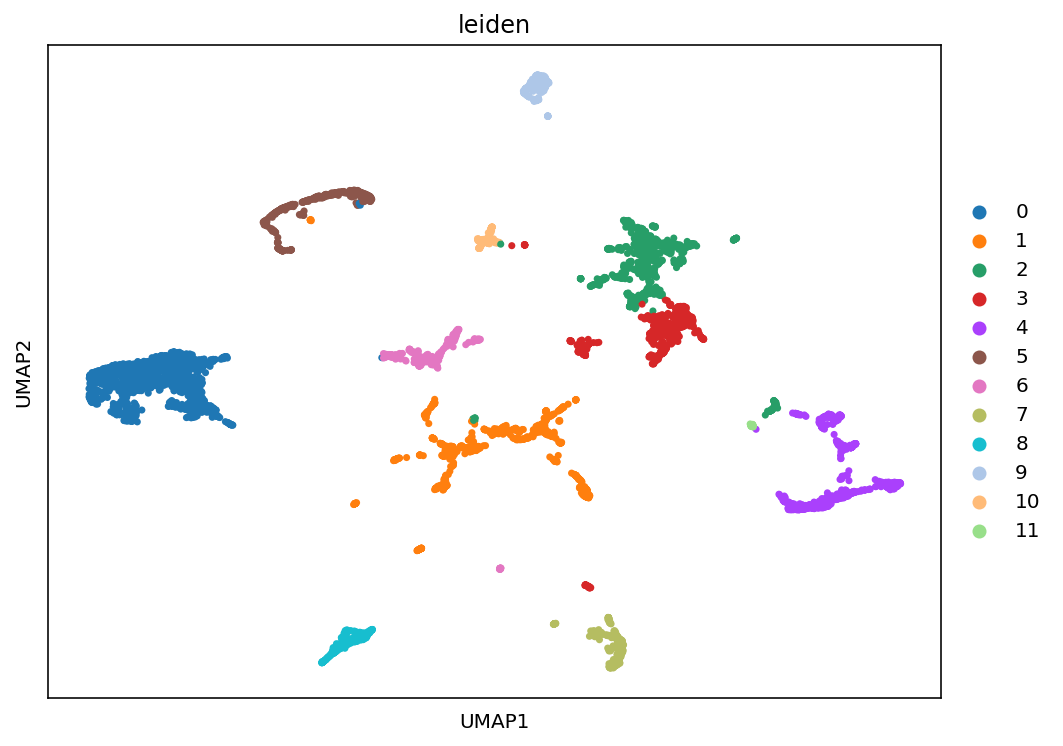

In [14]:
# Run leiden clustering on the neural data alone
# The resolution parameter was tuned until we got
# decent predictability, shown below
sc.tl.leiden( adataMP, resolution=0.13 )
fig = plt.figure(figsize=(8,6))
sc.pl.umap( adataMP, color='leiden', size=50, legend_loc='right margin', ax=fig.gca() )
plt.show()

In [16]:
checkLogisticPredictability( adataMP.X, adataMP.obs.leiden.astype(int).values, trainRatio=trainRatio )

100%|████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.61s/it]


array([0.9809509 , 0.93800917, 0.93322094, 0.94401091, 0.96079785,
       0.96722811, 0.97551982, 0.97996473, 0.98887054, 0.96581217,
       0.98686028, 0.80326002])

In [83]:
# Calculate nearest neighbor averages to 
# clean up the plots a bit
nnm = adataMP.obsp['connectivities']
sums = nnm.sum(1).A.flatten()
sums[sums==0] = 1
nnm = nnm.multiply( 1/sums[:,None] )
adataMP.layers['knnAvg'] = nnm @ adataMP.X

In [628]:
# Re-naming subclusters based on how I want to plot them
adataMP.obs['rSubcluster'] = -1
adataMP.obs.loc[adataMP.obs.leiden=='2','rSubcluster'] = 0
adataMP.obs.loc[adataMP.obs.leiden=='1','rSubcluster'] = 1
adataMP.obs.loc[adataMP.obs.leiden=='3','rSubcluster'] = 2
adataMP.obs.loc[adataMP.obs.leiden=='8','rSubcluster'] = 3
adataMP.obs.loc[adataMP.obs.leiden=='4','rSubcluster'] = 4
adataMP.obs.loc[adataMP.obs.leiden=='9','rSubcluster'] = 5
adataMP.obs.loc[adataMP.obs.leiden=='7','rSubcluster'] = 6
adataMP.obs.loc[adataMP.obs.leiden=='5','rSubcluster'] = 7
adataMP.obs.loc[adataMP.obs.leiden=='0','rSubcluster'] = 8
adataMP.obs.loc[adataMP.obs.leiden=='6','rSubcluster'] = 9
adataMP.obs.loc[adataMP.obs.leiden=='10','rSubcluster'] = 10
adataMP.obs.loc[adataMP.obs.leiden=='11','rSubcluster'] = 11

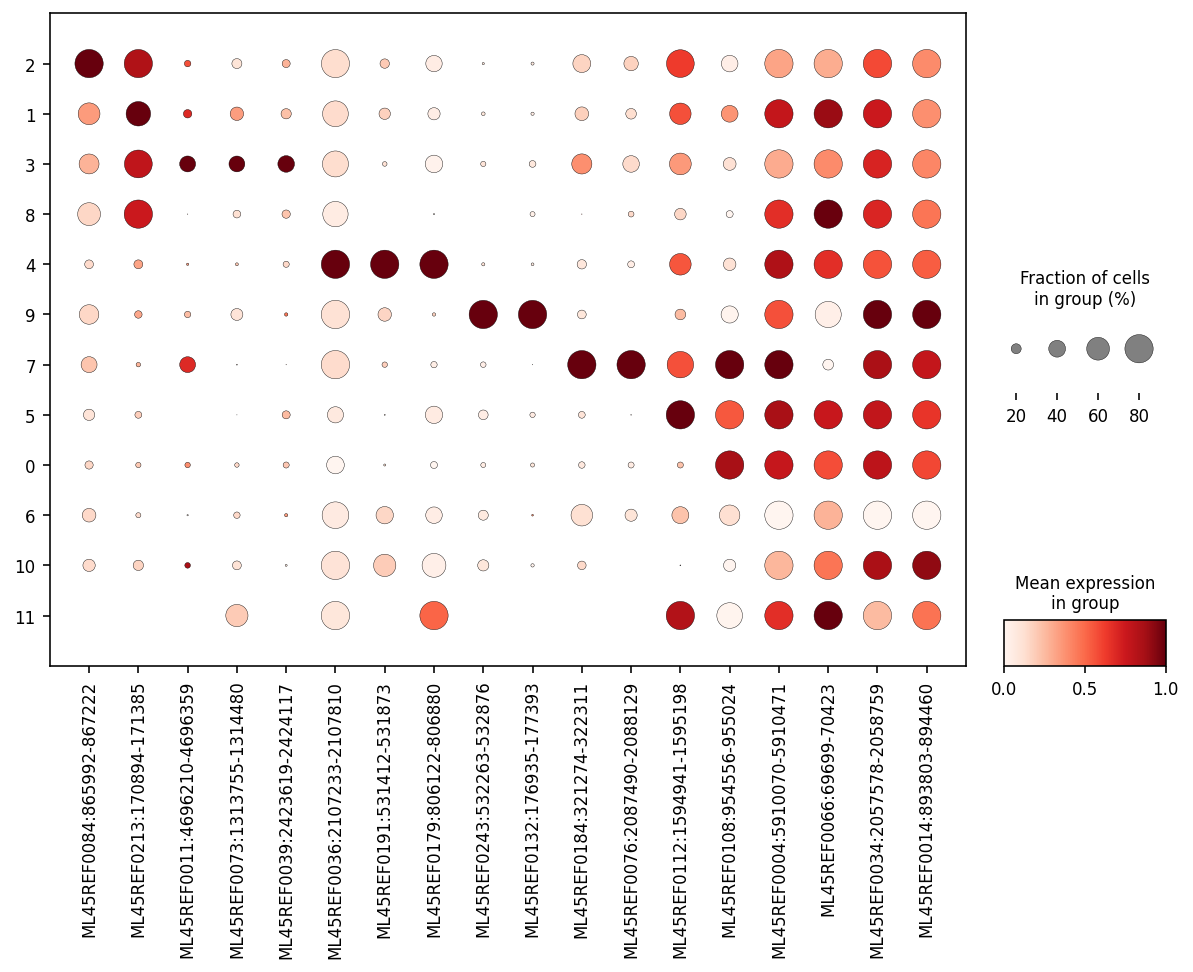

In [839]:
sc.pl.dotplot( adataMP, groupby='leiden', use_raw=False, show=False,
               mean_only_expressed=True, standard_scale='var', figsize=(10,6), 
               dot_min=0, dot_max=0.8, layer='knnAvg',
               categories_order=['2','1','3','8','4','9','7','5','0','6','10','11'],
               var_names=['ML45REF0084:865992-867222', # ChAT (Mlig455_068578)
                          'ML45REF0213:170894-171385', # VAChT (Mlig455_062533)
                          'ML45REF0011:4696210-4696359', # DDC1 (Mlig455_008932)
                          'ML45REF0073:1313755-1314480', # SerT (Mlig455_036417)
                          'ML45REF0039:2423619-2424117', # TPH1 (Mlig455_023709)
                          'ML45REF0036:2107233-2107810', # DDC2 (Mlig455_022323)
                          'ML45REF0191:531412-531873', # TH (Mlig455_060113)
                          'ML45REF0179:806122-806880', # VMAT1 (Mlig455_058555)
                          'ML45REF0243:532263-532876', # ZNT2 (Mlig455_065421)
                          'ML45REF0132:176935-177393', # ZIP6 (Mlig455_050869)
                          'ML45REF0184:321274-322311', # GAD (Mlig455_059173)
                          'ML45REF0076:2087490-2088129', # VIAAT (Mlig455_037473)
                          'ML45REF0112:1594941-1595198', # VGLUT1 (Mlig455_046916)
                          'ML45REF0108:954556-955024', # VGLUT2 (Mlig455_045935)
                          'ML45REF0004:5910070-5910471', # GLS (Mlig455_003560)
                          'ML45REF0066:69699-70423', # rootletin (Mlig455_033971)
                          'ML45REF0034:2057578-2058759', # PC2 (Mlig455_021418)
                          'ML45REF0014:893803-894460'] ) # 7b2 (Mlig455_010515)
plt.savefig( 'Plots/EDFig3/PanelED3b_Mlig.svg', format='svg' )
plt.show()

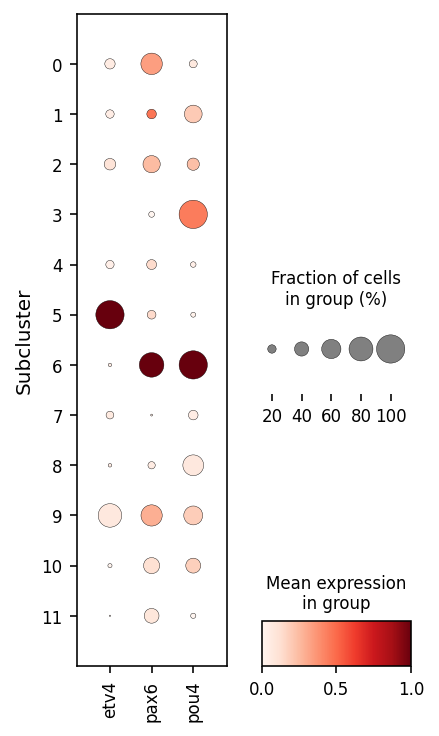

In [840]:
TFgenes = [ 'ML45REF0013:586784-587814', # ETV5 (Mlig455_009762)
            'ML45REF0072:1799232-1799888', # PAX6 (Mlig455_036182)
            'ML45REF0041:1771710-1772272' ] # POU4 (Mlig455_024541)

g = sc.pl.dotplot( adataMP, groupby='rSubcluster', use_raw=False, show=False, layer='knnAvg',
                   mean_only_expressed=True, standard_scale='var', var_names=TFgenes, figsize=(3,6) )
g['mainplot_ax'].set_xticklabels( ['etv5','pax6','pou4'] )
g['mainplot_ax'].set_ylabel( 'Subcluster' )
plt.savefig( 'Plots/EDFig7/PanelED7b_Mlig.svg', format='svg' )
plt.show()

In [ ]:
adataMP.obs[['SEACell','leiden','rSubcluster']].to_csv( 'Metadata/Mlig.neural_subcluster_annotations.csv' )

In [ ]:
adataM = sc.read_h5ad( 'ChromVARDeviations/Mlig.SEACells_devs.h5ad' )
adataM = adataM[adataM.obs.GroupFigure.str.startswith('Neural'),:].copy()

In [ ]:
# Transfer the subcluster annotations to the SEACells
scl = adataMP.obs
adataM.obs['subcluster'] = -1
for cell in tqdm( adataM.obs_names ):
    # Check that we have an annotation for this SEACell
    if cell not in scl.SEACell.values:
        continue
    # Have all of the members vote
    sub = scl[scl.SEACell==cell].rSubcluster.value_counts()
    sub = sub / sub.sum()
    # If more than 70% are in the same subcluster,
    # transfer that annotation
    if sub.max() > 0.7:
        adataM.obs.loc[cell,'subcluster'] = sub.idxmax()

In [ ]:
del adataMP

gc.collect()

# *S. mediterranea* subclustering

In [ ]:
# Read in the RNA data and transfer annotations
adataPG = sc.read_h5ad( 'GEXCounts/Smed/Smed.raw_RNA_counts.h5ad' )
adataPG.obs = sc.read_h5ad( 'ArchROutputs/Smed/Smed.peaks.h5ad' )\
                .obs.loc[adataPG.obs_names,:]
sc.pp.normalize_per_cell( adataPG )
sc.pp.log1p( adataPG, base=2 )

adataPG = adataPG[adataPG.obs.GroupFigure.str.startswith('Neural'),:].copy()
adataPG.obsm['X_PVI'] = pd.read_csv( 'scVI_models/Smed.scvi_neural_latent_dims.csv',
                                     index_col=0 ).loc[adataPG.obs_names,:].values
adataPG.obs['SEACell'] = pd.read_csv( 'SEACellsOutput/Smed.all_SEACell_assignments.csv', 
                                      index_col=0 ).loc[adataPG.obs_names,'SEACell']

adataPG

In [43]:
sc.external.pp.bbknn( adataPG, batch_key='Sample', neighbors_within_batch=10, 
                      use_rep="X_PVI", trim=0 )

In [ ]:
sc.tl.umap( adataPP, min_dist=0.05, spread=1.5 )
fig = plt.figure(figsize=(8,6))
sc.pl.umap( adataPP, color='GroupFigure', size=50, legend_loc='right margin', ax=fig.gca() )
plt.show()

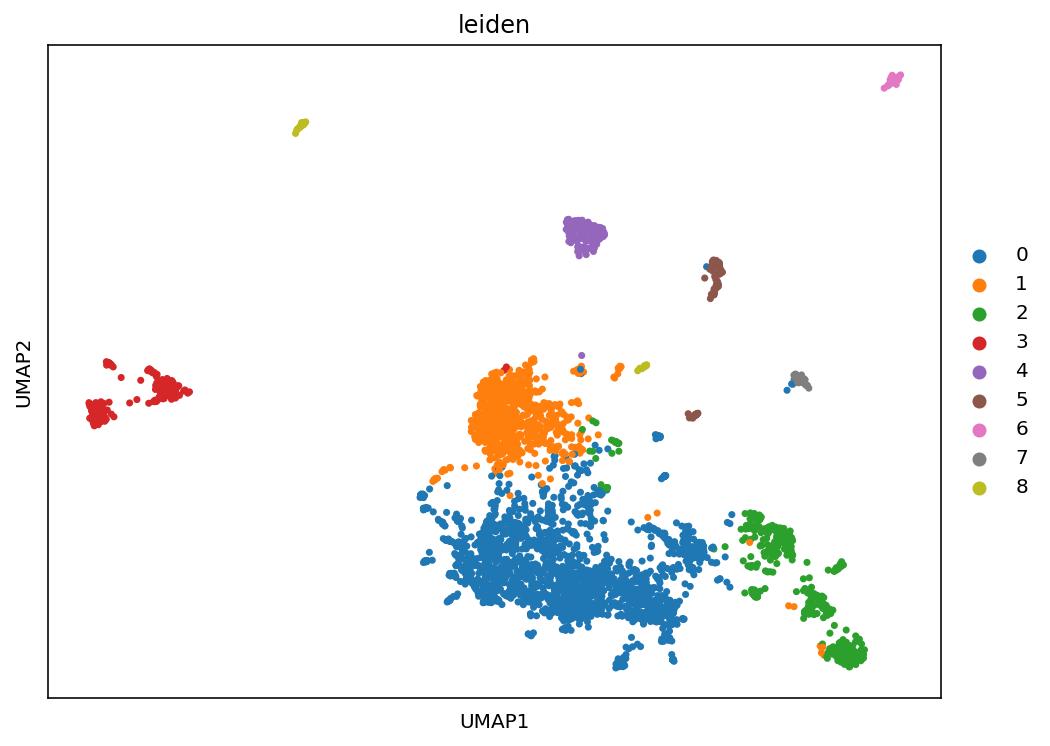

In [45]:
sc.tl.leiden( adataPG, resolution=0.2 )
fig = plt.figure(figsize=(8,6))
sc.pl.umap( adataPG, color='leiden', size=50, legend_loc='right margin', ax=fig.gca() )
plt.show()

In [49]:
checkLogisticPredictability( adataPG.X, adataPG.obs.leiden.astype(int).values, trainRatio=trainRatio )

100%|██████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.01it/s]


array([0.93572964, 0.87473241, 0.93662879, 0.98769271, 0.98113214,
       0.89486812, 0.97659817, 0.94788842, 0.94511342])

In [48]:
# Nearest neighbor averaging
nnm = adataPG.obsp['connectivities']
# zero out off block diagonal to avoid 
# mixing between sexual and asexual
for sample in ['Smed','S2F2']:
    nnm[adataPG.obs.Sample.str.startswith(sample),:]\
       [:,~adataPG.obs.Sample.str.startswith(sample)] = 0
    nnm[~adataPG.obs.Sample.str.startswith(sample),:]\
       [:,adataPG.obs.Sample.str.startswith(sample)] = 0
sums = nnm.sum(1).A.flatten()
sums[sums==0] = 1
nnm = nnm.multiply( 1/sums[:,None] )
adataPG.layers['knnAvg'] = nnm @ adataPG.X

In [ ]:
# re-naming
adataPG.obs['rSubcluster'] = -1
adataPG.obs.loc[adataPG.obs.leiden=='0','rSubcluster'] = 0
adataPG.obs.loc[adataPG.obs.leiden=='7','rSubcluster'] = 1
adataPG.obs.loc[adataPG.obs.leiden=='2','rSubcluster'] = 2
adataPG.obs.loc[adataPG.obs.leiden=='3','rSubcluster'] = 3
adataPG.obs.loc[adataPG.obs.leiden=='4','rSubcluster'] = 4
adataPG.obs.loc[adataPG.obs.leiden=='6','rSubcluster'] = 5
adataPG.obs.loc[adataPG.obs.leiden=='1','rSubcluster'] = 6
adataPG.obs.loc[adataPG.obs.leiden=='5','rSubcluster'] = 7
adataPG.obs.loc[adataPG.obs.leiden=='8','rSubcluster'] = 8

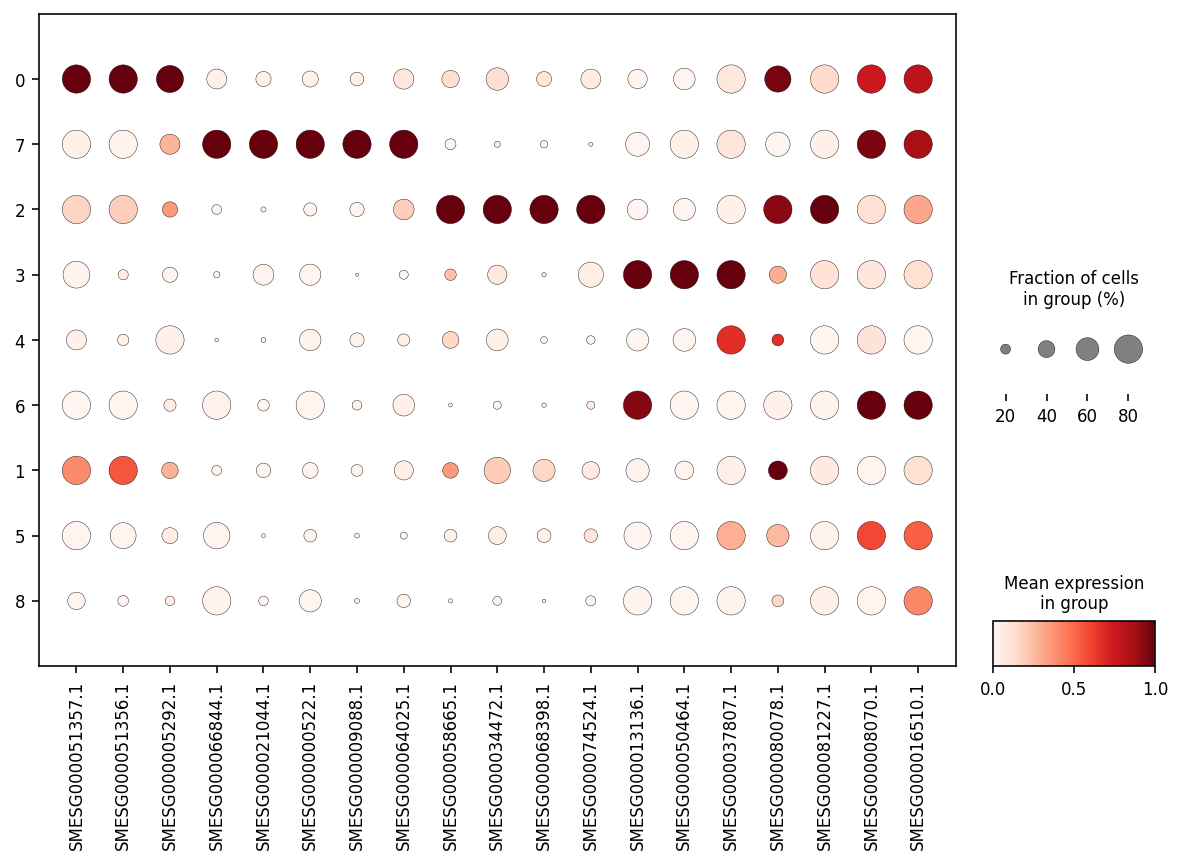

In [841]:
sc.pl.dotplot( adataPG, groupby='leiden', use_raw=False, show=False,
               mean_only_expressed=True, standard_scale='var', figsize=(10,6), 
               dot_min=0, dot_max=0.8, layer='knnAvg',
               categories_order=['0','7','2','3','4','6','1','5','8'],
               var_names=['SMESG000051357.1', # ChAT 
                          'SMESG000051356.1', # VAChT 
                          'SMESG000005292.1', # TBH
                          'SMESG000066844.1', # DDC1
                          'SMESG000021044.1', # SerT 
                          'SMESG000000522.1', # TPH2 
                          'SMESG000009088.1', # VMAT1a
                          'SMESG000064025.1', # VMAT1b
                          'SMESG000058665.1', # DDC
                          'SMESG000034472.1', # TH
                          'SMESG000068398.1', # DAT 
                          'SMESG000074524.1', # CAV1 
                          'SMESG000013136.1', # ZNT2 
                          'SMESG000050464.1', # ZIP6
                          'SMESG000037807.1', # otoferlin 
                          'SMESG000080078.1', # VGLUT 
                          'SMESG000081227.1', # rootletin 
                          'SMESG000008070.1', # PC2
                          'SMESG000016510.1'] ) # 7b2
plt.savefig( 'Plots/EDFig3/PanelED3b_Smed.svg', format='svg' )
plt.show()

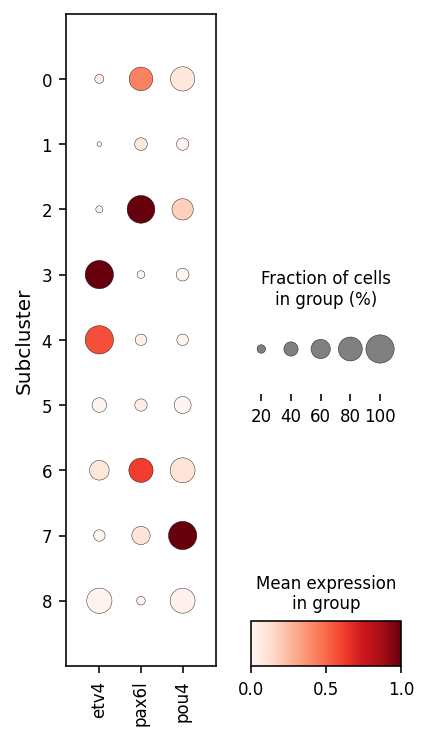

In [842]:
TFgenes = [ 'SMESG000008885.1', # ETV4
            'SMESG000004009.1', # PAX6-like
            'SMESG000013430.1' ] # POU4

g = sc.pl.dotplot( adataPG, groupby='rSubcluster', use_raw=False, show=False, layer='knnAvg',
                   mean_only_expressed=True, standard_scale='var', var_names=TFgenes, figsize=(3,6) )
g['mainplot_ax'].set_xticklabels( ['etv4','pax6l','pou4'] )
g['mainplot_ax'].set_ylabel( 'Subcluster' )
plt.savefig( 'Plots/EDFig7/PanelED7b_Smed.svg', format='svg' )
plt.show()

In [ ]:
adataPG.obs[['SEACell','leiden','rSubcluster']].to_csv( 'Metadata/Smed.neural_subcluster_annotations.csv' )

In [ ]:
adataP = sc.read_h5ad( 'ChromVARDeviations/Smed.SEACells_devs.h5ad' )
adataP = adataP[adataP.obs.GroupFigure.str.startswith('Neural'),:].copy()

In [ ]:
# Transfer the subcluster annotations to the SEACells
scl = adataPG.obs
adataP.obs['subcluster'] = -1
for cell in tqdm( adataP.obs_names ):
    # Check that we have an annotation for this SEACell
    if cell not in scl.SEACell.values:
        continue
    # Have all of the members vote
    sub = scl[scl.SEACell==cell].rSubcluster.value_counts()
    sub = sub / sub.sum()
    # If more than 70% are in the same subcluster,
    # transfer that annotation
    if sub.max() > 0.7:
        adataP.obs.loc[cell,'subcluster'] = sub.idxmax()

In [ ]:
del adataPG

gc.collect()

# *S. mansoni* subclustering

In [ ]:
# Read in the RNA data and transfer annotations
adataSG = sc.read_h5ad( 'GEXCounts/Sman/Sman.raw_rna_counts.h5ad' )
adataSG.var_names = [ g.replace('-','_') for g in adataSG.var_names ]
# Reading in the ATAC data too since it's a bit higher quality
adataSP = sc.read_h5ad( 'ArchROutputs/Sman/Sman.peaks.h5ad' )[adataSG.obs_names,:].copy()
adataSG.obs = adataSP.obs.copy()
sc.pp.normalize_per_cell( adataSG )
sc.pp.log1p( adataSG, base=2 )

adataSG = adataSG[adataSG.obs.GroupFigure.str.startswith('Neural'),:].copy()
adataSG.obsm['X_PVI'] = pd.read_csv( 'scVI_models/Sman.pvi_neural_latent_dims.csv',
                                     index_col=0 ).loc[adataSG.obs_names,:].values
adataSG.obs['SEACell'] = pd.read_csv( 'SEACellsOutput/Sman.all_SEACell_assignments.csv', 
                                      index_col=0 ).loc[adataSG.obs_names,'SEACell']

adataSG

In [ ]:
sc.external.pp.bbknn( adataSG, batch_key='Sample', neighbors_within_batch=10, 
                      use_rep="X_PVI", trim=0 )

In [ ]:
sc.tl.umap( adataSG, min_dist=0.05, spread=1.5 )
fig = plt.figure(figsize=(8,6))
sc.pl.umap( adataSG, color='GroupFigure', size=50, legend_loc='right margin', ax=fig.gca() )
plt.show()

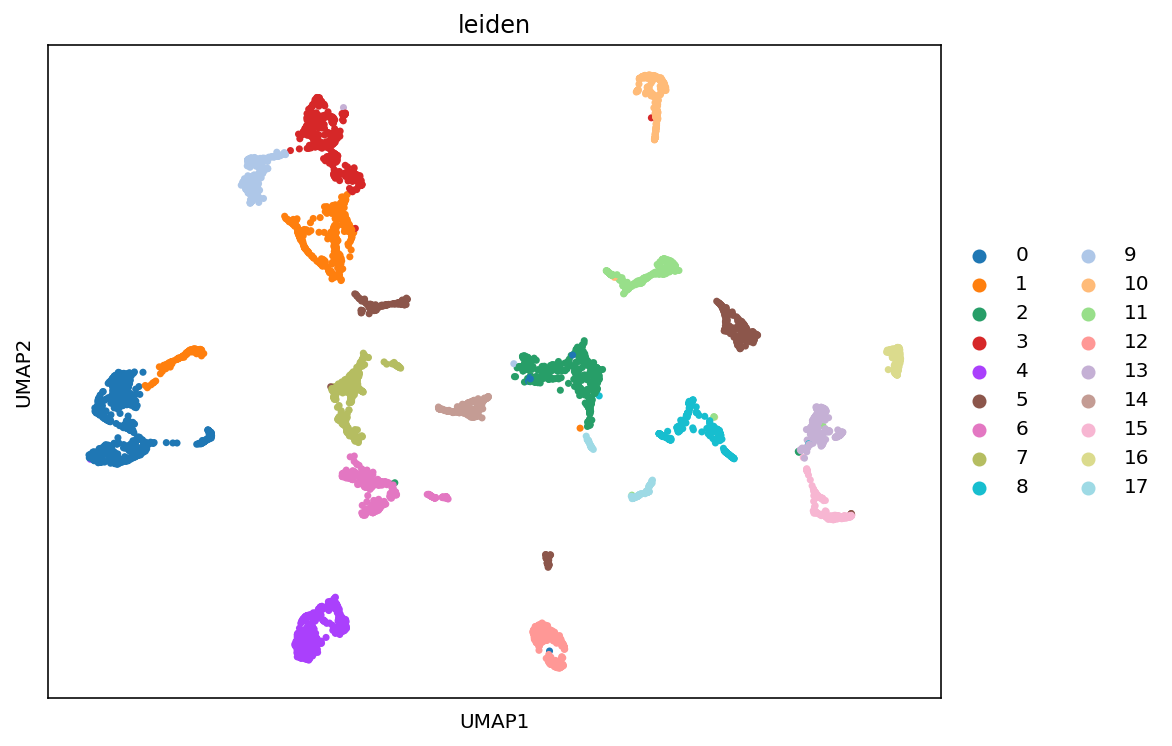

In [56]:
sc.tl.leiden( adataSG, resolution=0.3 )
fig = plt.figure(figsize=(8,6))
sc.pl.umap( adataSG, color='leiden', size=50, legend_loc='right margin', ax=fig.gca() )
plt.show()

In [58]:
# Using the peak accessibilities as predictors here instead of the
# RNA expression since this is what the embedding was based on,
# and the data quality is a bit higher than the RNA 
checkLogisticPredictability( adataSP.X, adataSG.obs.leiden.astype(int).values, trainRatio=trainRatio )

100%|████████████████████████████████████████████████| 18/18 [00:57<00:00,  3.18s/it]


array([0.97295061, 0.94382038, 0.78589226, 0.92406344, 0.93935625,
       0.9379277 , 0.93721106, 0.90139328, 0.87286324, 0.95508441,
       0.95247964, 0.89934245, 0.96884742, 0.93295541, 0.94464605,
       0.9838459 , 0.94387477, 0.79015309])

In [ ]:
# Adult and juvenile data can have quite different scales since they
# were from totally different technologies and experiments so instead
# of nearest-neighbor averaging, just going to normalize the rms values
# of each gene to be 1 for both conditions independet of one another
X = adataSG.X.A
for s in ['adult','juvenile']:
    mask = adataSG.obs.Sample.str.startswith(s)
    x = X[mask,:]
    rms = (x**2).mean(0)**0.5
    rms[rms==0] = 1
    X[mask,:] = x / sds[None,:]
X = np.nan_to_num( X )
adataSG.layers['batchNorm'] = sparse.csr_matrix( X )

In [ ]:
# Re-naming
adataSG.obs['rSubcluster'] = -1
adataSG.obs.loc[adataSG.obs.leiden=='15','rSubcluster'] = 0
adataSG.obs.loc[adataSG.obs.leiden=='8','rSubcluster'] = 1
adataSG.obs.loc[adataSG.obs.leiden=='13','rSubcluster'] = 2
adataSG.obs.loc[adataSG.obs.leiden=='2','rSubcluster'] = 3
adataSG.obs.loc[adataSG.obs.leiden=='12','rSubcluster'] = 4
adataSG.obs.loc[adataSG.obs.leiden=='3','rSubcluster'] = 5
adataSG.obs.loc[adataSG.obs.leiden=='9','rSubcluster'] = 6
adataSG.obs.loc[adataSG.obs.leiden=='4','rSubcluster'] = 7
adataSG.obs.loc[adataSG.obs.leiden=='6','rSubcluster'] = 8
adataSG.obs.loc[adataSG.obs.leiden=='0','rSubcluster'] = 9
adataSG.obs.loc[adataSG.obs.leiden=='10','rSubcluster'] = 10
adataSG.obs.loc[adataSG.obs.leiden=='11','rSubcluster'] = 11
adataSG.obs.loc[adataSG.obs.leiden=='14','rSubcluster'] = 12
adataSG.obs.loc[adataSG.obs.leiden=='1','rSubcluster'] = 13
adataSG.obs.loc[adataSG.obs.leiden=='7','rSubcluster'] = 14
adataSG.obs.loc[adataSG.obs.leiden=='16','rSubcluster'] = 15
adataSG.obs.loc[adataSG.obs.leiden=='17','rSubcluster'] = 16
adataSG.obs.loc[adataSG.obs.leiden=='5','rSubcluster'] = 17

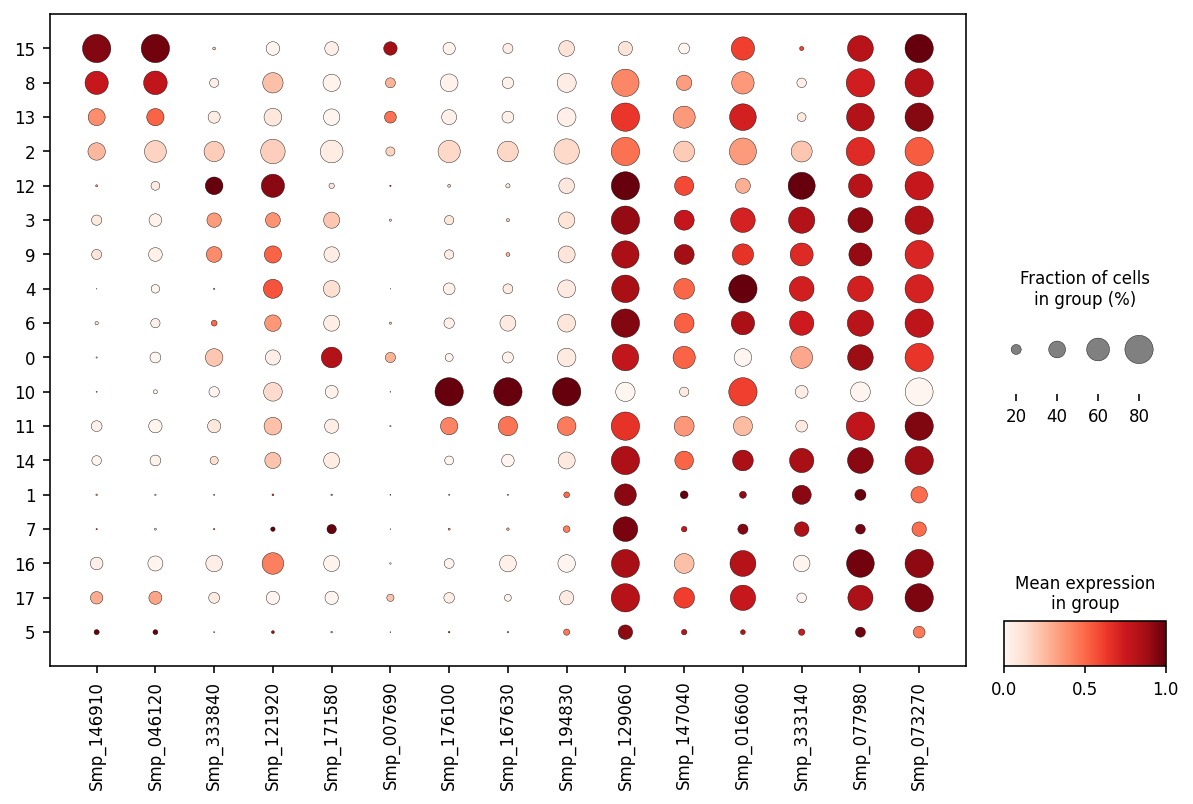

In [846]:
sc.pl.dotplot( adataSG, groupby='leiden', use_raw=False, show=False,
               mean_only_expressed=True, standard_scale='var', figsize=(10,6), 
               dot_min=0, dot_max=0.8, layer='batchNorm',
               categories_order=['15','8','13','2','12','3','9','4','6','0','10','11','14','1','7','16','17','5'],
               var_names=['Smp_146910', # ChAT 
                          'Smp_046120', # VAChT 
                          'Smp_333840', # SerT 
                          'Smp_121920', # VMAT1
                          'Smp_171580', # DDC 
                          'Smp_007690', # TH 
                          'Smp_176100', # ZNT2 
                          'Smp_167630', # ZIP6 
                          'Smp_194830', # KK7
                          'Smp_129060', # VGLUT
                          'Smp_147040', # GLS
                          'Smp_016600', # EAAT2
                          'Smp_333140', # rootletin
                          'Smp_077980', # PC2
                          'Smp_073270'] ) # 7b2
plt.savefig( 'Plots/EDFig3/PanelED3b_Sman.svg', format='svg' )
plt.show()

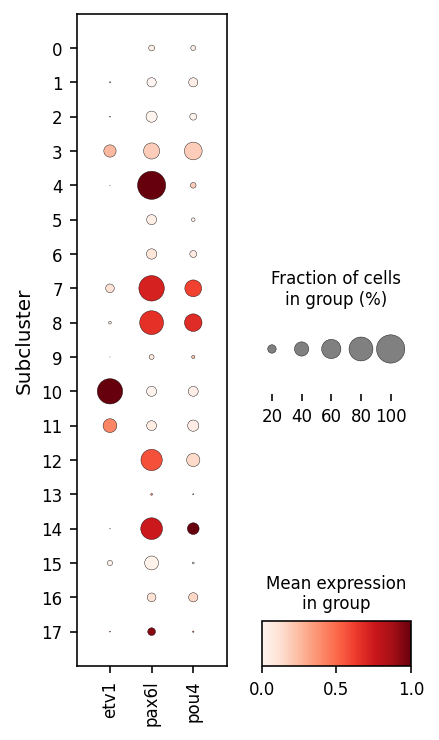

In [851]:
TFgenes = [ 'Smp_342280', # ETV4 
            'Smp_142940', # PAX6-like
            'Smp_340200' ] # POU4

g = sc.pl.dotplot( adataSG, groupby='rSubcluster', use_raw=False, show=False, layer='batchNorm',
                   mean_only_expressed=True, standard_scale='var', var_names=TFgenes, figsize=(3,6) )
g['mainplot_ax'].set_xticklabels( ['etv1','pax6l','pou4'] )
g['mainplot_ax'].set_ylabel( 'Subcluster' )
plt.savefig( 'Plots/EDFig7/PanelED7b_Sman.svg', format='svg' )
plt.show()

In [ ]:
adataSG.obs[['SEACell','leiden','rSubcluster']].to_csv( 'Metadata/Sman.neural_subcluster_annotations.csv' )

In [ ]:
adataS = sc.read_h5ad( 'ChromVARDeviations/Sman.SEACells_devs.h5ad' )
adataS = adataS[adataS.obs.GroupFigure.str.startswith('Neural'),:].copy()

In [ ]:
# Transfer the subcluster annotations to the SEACells
scl = adataSG.obs
adataS.obs['subcluster'] = -1
for cell in tqdm( adataS.obs_names ):
    # Check that we have an annotation for this SEACell
    if cell not in scl.SEACell.values:
        continue
    # Have all of the members vote
    sub = scl[scl.SEACell==cell].rSubcluster.value_counts()
    sub = sub / sub.sum()
    # If more than 70% are in the same subcluster,
    # transfer that annotation
    if sub.max() > 0.7:
        adataS.obs.loc[cell,'subcluster'] = sub.idxmax()

In [ ]:
del adataSG
del adataSP

gc.collect()

# Motif module analysis

In [ ]:
alpha = 0.1
minResponse = 1

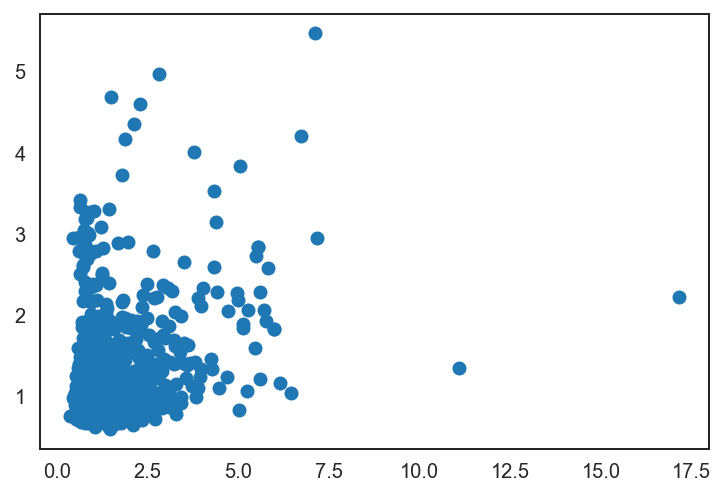

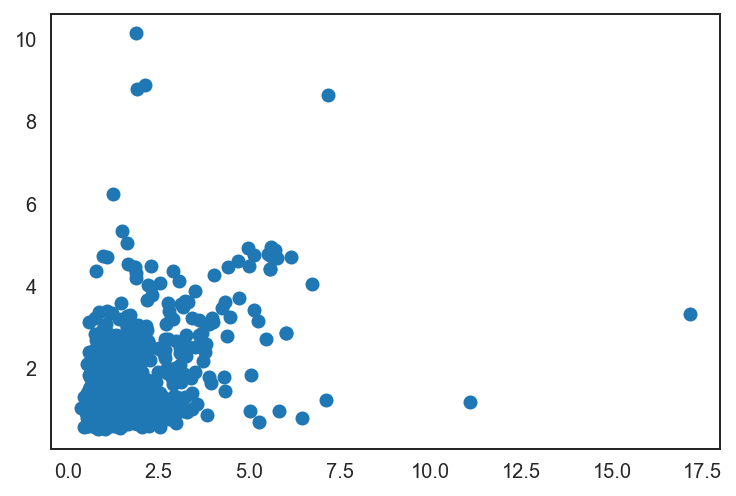

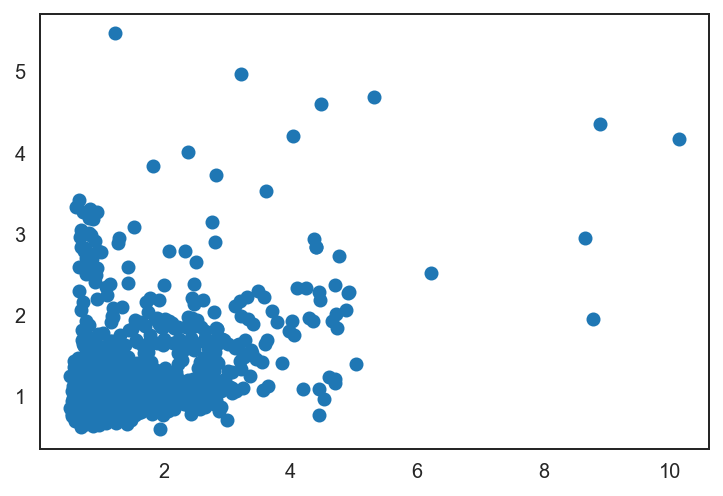

In [458]:
# Comparing motif deviation variability between species
plt.scatter( adataM.X.A.std(0)[None,:],
             adataP.X.A.std(0)[None,:] )
plt.show()
plt.scatter( adataM.X.A.std(0)[None,:],
             adataS.X.A.std(0)[None,:] )
plt.show()
plt.scatter( adataS.X.A.std(0)[None,:],
             adataP.X.A.std(0)[None,:] )
plt.show()

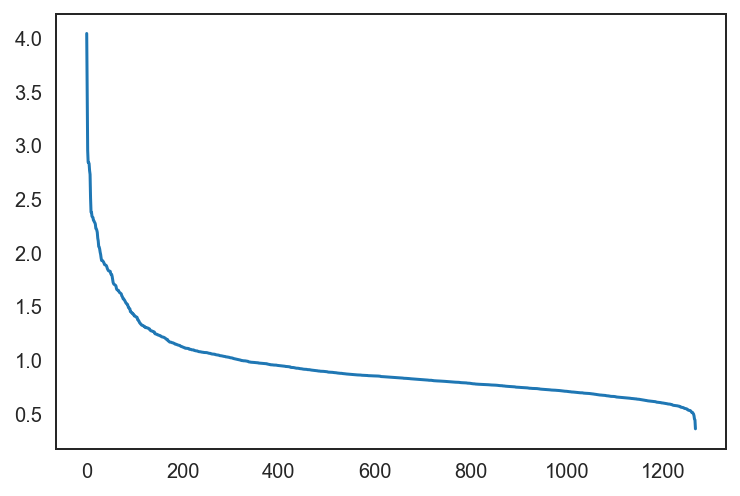

Index(['WC_0275|WRKY48(0.943)', 'WC_0514|Trl(1.901)', 'JC_0280|RFX2(0.147)',
       'JC_0065|HOXC4(0.160)', 'JC_0047|Dlx2(0.053)', 'WC_1290|PHD1(1.097)',
       'WC_0470|DOF2.4(1.076)', 'JC_0303|PHYPADRAFT_140773(0.030)',
       'JC_0066|NK7.1(0.157)', 'WC_0542|KLF4(1.630)', 'JC_0004|HCM1(0.290)',
       'WC_0009|z(0.845)', 'WC_1093|SPI1(2.470)', 'JC_0118|MSN4(0.063)',
       'JC_0019|ZNF384(0.534)', 'WC_0912|DOF2.4(0.430)',
       'WC_0386|Clamp(2.490)', 'WC_0618|Trl(2.877)', 'JC_0216|eor-1(0.028)',
       'JC_0255|POU4F3(0.087)'],
      dtype='object')

In [459]:
# Check out the most variable motifs across all three datasets
sds = np.concatenate( (adataM.X.A.std(0)[None,:],
                       adataP.X.A.std(0)[None,:],
                       adataS.X.A.std(0)[None,:]), axis=0 ).min(0)

plt.plot( np.sort( sds )[::-1] )
plt.show()
adataM.var_names[np.argsort(sds)[::-1]][:20]

In [461]:
# Subset of motifs that are highly variable
# in all three species
highlyVariable = adataM.var_names[sds>1]
print( highlyVariable.size )
highlyVariable

319


Index(['JC_0000|BIM2(0.105)', 'JC_0001|Pax2(0.321)', 'JC_0004|HCM1(0.290)',
       'JC_0006|MOT2(0.189)', 'JC_0007|usp(0.031)', 'JC_0009|PBF(0.050)',
       'JC_0010|dl(0.000)', 'JC_0011|REL(0.162)', 'JC_0012|ELK3(0.088)',
       'JC_0013|Mecom(0.000)',
       ...
       'WC_1796|daf-12(5.646)', 'WC_1917|daf-12(3.496)', 'WC_1938|CCA1(2.222)',
       'WC_1967|SFP1(2.967)', 'WC_1970|ZNF460(5.054)', 'WC_1973|ZNF148(1.330)',
       'WC_1974|ZNF740(6.457)', 'WC_1977|Trl(4.401)', 'WC_1999|DOF1.8(1.052)',
       'WC_2006|BATF3(4.894)'],
      dtype='object', length=319)

## Find subcluster marker motifs

In [462]:
# Prepare the data
X = zscore( adataM[:,sds>=minResponse].X.toarray(), axis=0 )
features = adataM.var_names[sds>=minResponse]
uLabels = np.sort(adataM.obs.subcluster.unique())
uLabels = uLabels[uLabels!=-1]
labels = adataM.obs.subcluster.astype(int).values

# Record p-values and average z-scored 
# deviations per-subcluster
pM = np.zeros( (uLabels.size,X.shape[1]) )
zM = np.zeros_like( pM )
for i, label in tqdm(enumerate(uLabels)):
    # Compare each subcluster to all others
    fg = X[labels==label,:]
    zM[i,:] = fg.mean(0)
    bg = X[labels!=label,:]
    res = stats.mannwhitneyu( fg, bg, axis=0, alternative='greater' )
    pM[i,:] = res.pvalue
    
zM = pd.DataFrame( data=zM, index=uLabels, columns=features )
pM = pd.DataFrame( data=pM, index=uLabels, columns=features )
# Run multiple test correction
pM = pM.stack()
_, pM.iloc[:], _, _ = sm.stats.multipletests( pM, alpha=alpha,
                                              method='fdr_bh' )
pM = pM.unstack().loc[uLabels,features]

binnedM = (zM>=minResponse) & (pM<alpha)
# Print number of subclusters each motif is 'on' in
binnedM.sum(0).value_counts()

12it [00:00, 12.99it/s]


1    156
2    100
0     42
3     17
4      4
dtype: int64

In [463]:
# Same deal for the planarian
X = zscore( adataP[:,sds>=minResponse].X.toarray(), axis=0 )
features = adataP.var_names[sds>=minResponse]
uLabels = np.sort(adataP.obs.subcluster.unique())
uLabels = uLabels[uLabels!=-1]
labels = adataP.obs.subcluster.astype(int).values

pP = np.zeros( (uLabels.size,X.shape[1]) )
zP = np.zeros_like( pP )
for i, label in tqdm(enumerate(uLabels)):
    fg = X[labels==label,:]
    zP[i,:] = fg.mean(0)
    bg = X[labels!=label,:]
    res = stats.mannwhitneyu( fg, bg, axis=0, alternative='greater' )
    pP[i,:] = res.pvalue
    
zP = pd.DataFrame( data=zP, index=uLabels, columns=features )
pP = pd.DataFrame( data=pP, index=uLabels, columns=features )
pP = pP.stack()
_, pP.iloc[:], _, _ = sm.stats.multipletests( pP, alpha=alpha,
                                              method='fdr_bh' )
pP = pP.unstack().loc[uLabels,features]

binnedP = (zP>=minResponse) & (pP<alpha)
binnedP.sum(0).value_counts()

9it [00:00, 14.95it/s]


1    147
0    131
2     39
3      2
dtype: int64

In [464]:
# Same deal for the schistosome
X = zscore( adataS[:,sds>=minResponse].X.toarray(), axis=0 )
features = adataS.var_names[sds>=minResponse]
uLabels = np.sort(adataS.obs.subcluster.unique())
uLabels = uLabels[uLabels!=-1]
labels = adataS.obs.subcluster.astype(int).values

pS = np.zeros( (uLabels.size,X.shape[1]) )
zS = np.zeros_like( pS )
for i, label in tqdm(enumerate(uLabels)):
    fg = X[labels==label,:]
    zS[i,:] = fg.mean(0)
    bg = X[labels!=label,:]
    res = stats.mannwhitneyu( fg, bg, axis=0, alternative='greater' )
    pS[i,:] = res.pvalue
    
zS = pd.DataFrame( data=zS, index=uLabels, columns=features )
pS = pd.DataFrame( data=pS, index=uLabels, columns=features )
pS = pS.stack()
_, pS.iloc[:], _, _ = sm.stats.multipletests( pS, alpha=alpha,
                                              method='fdr_bh' )
pS = pS.unstack().loc[uLabels,features]

binnedS = (zS>=minResponse) & (pS<alpha)
binnedS.sum(0).value_counts()

18it [00:01, 13.11it/s]


1    153
2     87
0     42
3     33
4      3
5      1
dtype: int64

In [465]:
# Motifs that are both highly variable, and good markers of
# at least one subcluster for all three species
allGood = ((binnedM.sum(0)>0)&(binnedP.sum(0)>0)&(binnedS.sum(0)>0))
allGood = allGood[allGood].index
print( allGood.size )
allGood.to_list()

155


['JC_0001|Pax2(0.321)',
 'JC_0004|HCM1(0.290)',
 'JC_0006|MOT2(0.189)',
 'JC_0010|dl(0.000)',
 'JC_0012|ELK3(0.088)',
 'JC_0014|FOXI1(0.063)',
 'JC_0018|HMG-I/Y(0.019)',
 'JC_0024|PAX6(0.000)',
 'JC_0030|SOX8(0.153)',
 'JC_0047|Dlx2(0.053)',
 'JC_0058|AHL20(0.142)',
 'JC_0062|PLAG1(0.000)',
 'JC_0065|HOXC4(0.160)',
 'JC_0066|NK7.1(0.157)',
 'JC_0067|Lim1(0.115)',
 'JC_0069|Lim3(0.213)',
 'JC_0070|Deaf1(0.231)',
 'JC_0072|schlank(0.000)',
 'JC_0073|GATA3(0.177)',
 'JC_0078|VDR(0.345)',
 'JC_0079|exd(0.002)',
 'JC_0080|onecut(0.099)',
 'JC_0096|Foxn1(0.350)',
 'JC_0099|CAT8(0.184)',
 'JC_0101|AZF1(0.282)',
 'JC_0105|STB4(0.223)',
 'JC_0106|CHA4(0.393)',
 'JC_0115|FZF1(0.000)',
 'JC_0117|FOSL1(0.043)',
 'JC_0129|MAC1(0.000)',
 'JC_0130|HMRA1(0.000)',
 'JC_0131|CMTA2(0.171)',
 'JC_0141|PHD1(0.122)',
 'JC_0142|PHO2(0.396)',
 'JC_0147|RFX1(0.285)',
 'JC_0158|SPT23(0.000)',
 'JC_0161|ERF069(0.129)',
 'JC_0166|TBS1(0.000)',
 'JC_0170|XBP1(0.014)',
 'JC_0172|YAP5(0.000)',
 'JC_0182|ZIC4(0.145)'

In [ ]:
binnedM.index = [ 'Mlig'+str(c) for c in binnedM.index ]
binnedP.index = [ 'Smed'+str(c) for c in binnedP.index ]
binnedS.index = [ 'Sman'+str(c) for c in binnedS.index ]

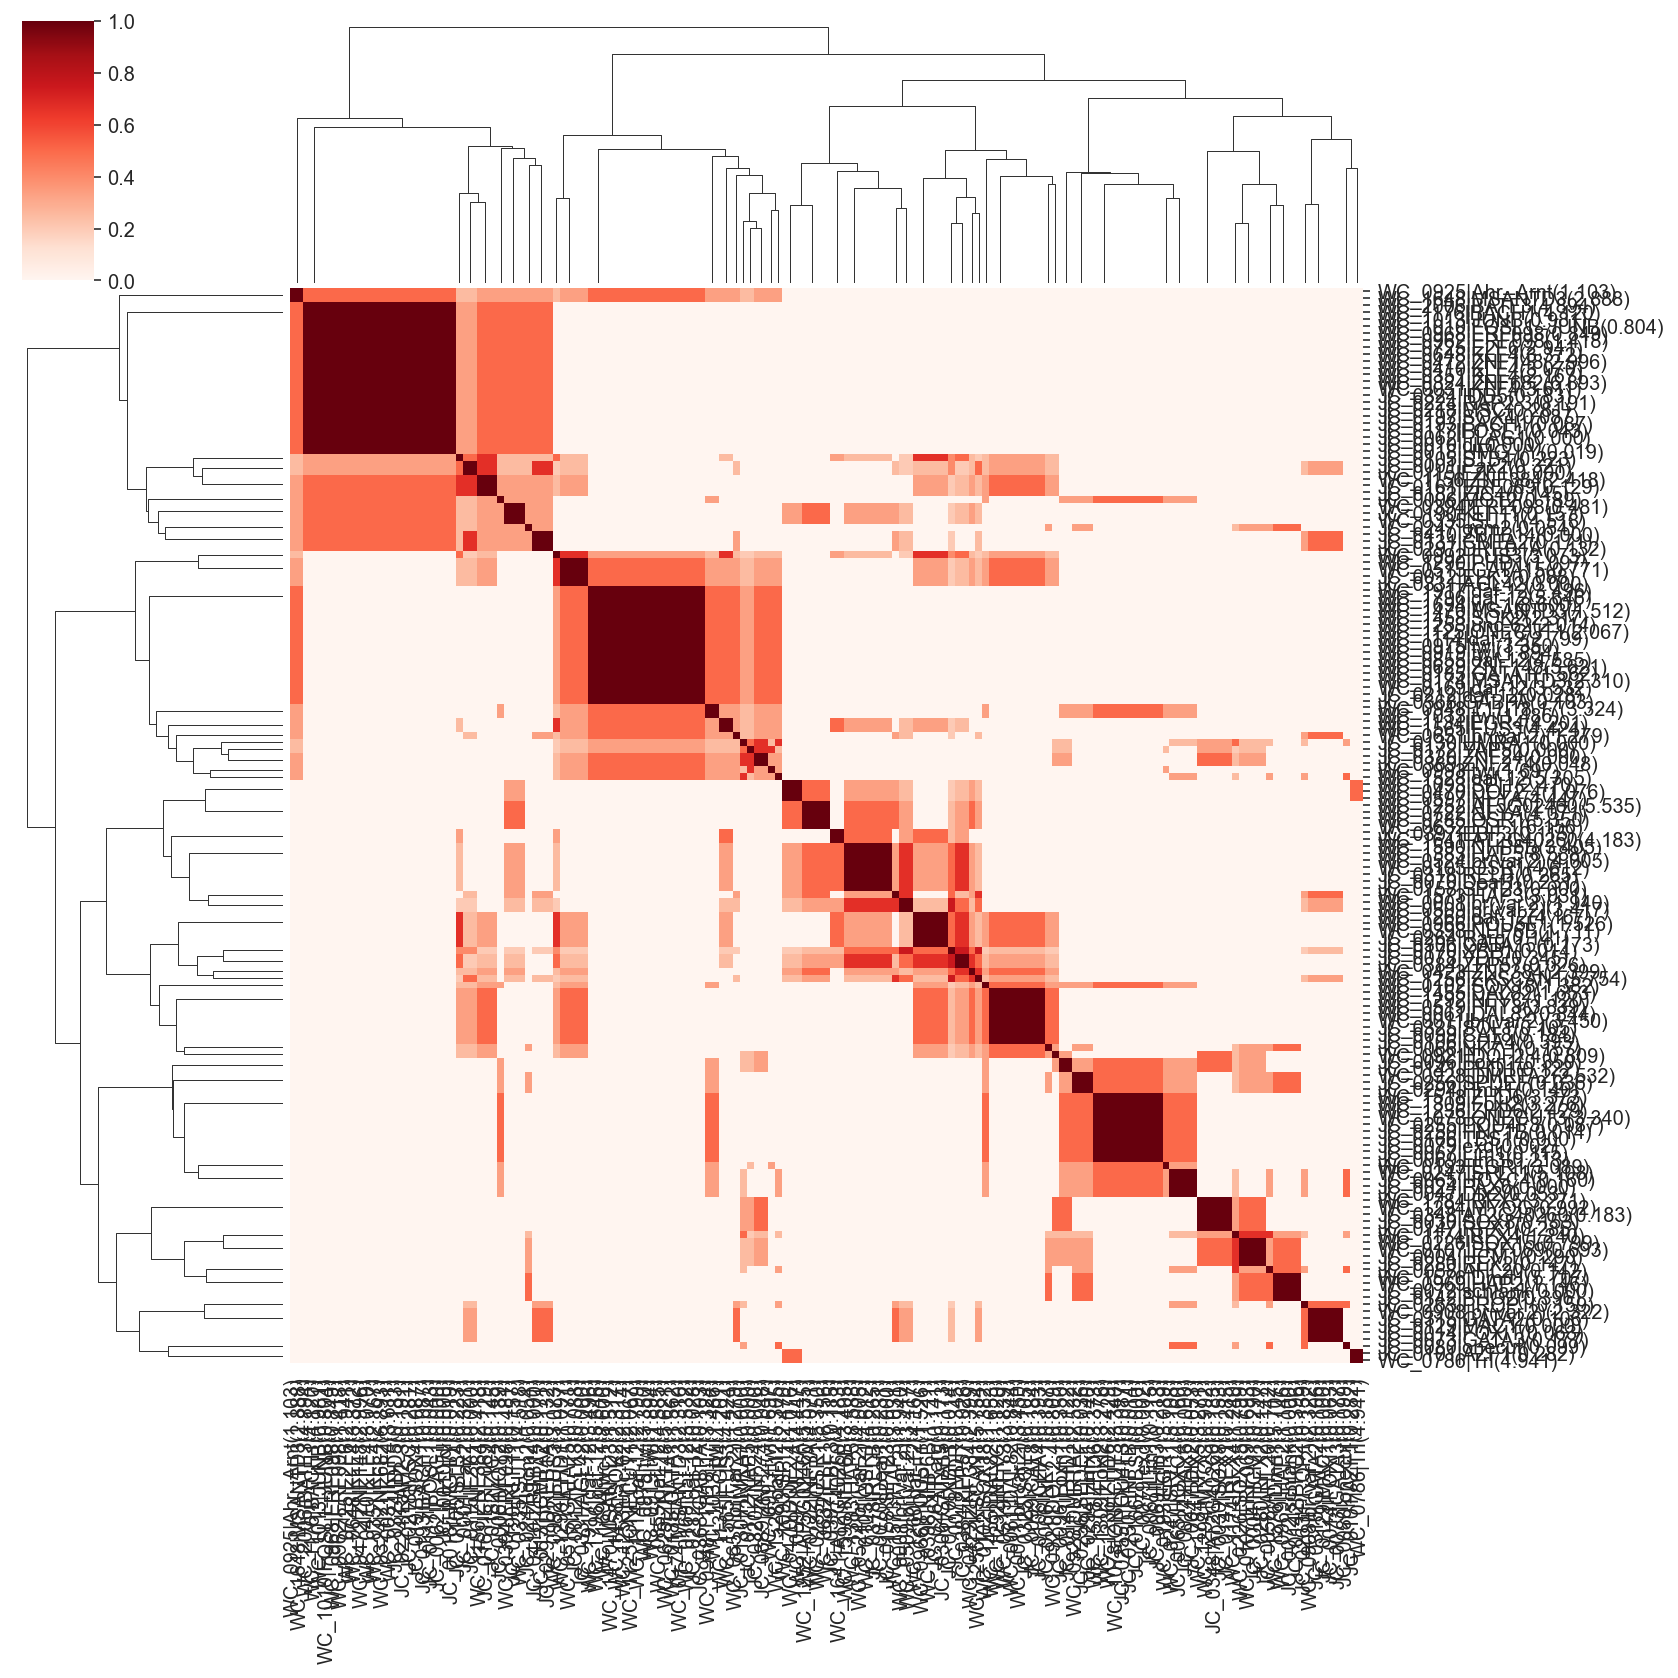

In [565]:
# motif-motif Jaccard similarity based on subcluster-binarized accessibility
X = binnedM.loc[:,allGood].T.astype(int)
X = X.loc[X.sum(1)>0,:]
intersect = X.values @ X.values.T
sizes = np.diag( intersect ).copy()
sizes = np.repeat( sizes[None,:], sizes.size, axis=0 )
union = sizes + sizes.T - intersect
jSimM = intersect / union
g = sns.clustermap( jSimM, metric='euclidean', method='average', cmap='Reds', robust=True )
g.ax_heatmap.set_xticks(np.arange(X.index.size)[::1]+0.5)
g.ax_heatmap.set_xticklabels(X.index[g.dendrogram_col.reordered_ind][::1], rotation=90)
g.ax_heatmap.set_yticks(np.arange(X.index.size)[::1]+0.5)
g.ax_heatmap.set_yticklabels(X.index[g.dendrogram_row.reordered_ind][::1], rotation=0)
plt.show()

In [566]:
# Build adjacency matrix using Jaccard 
# similarity of 1 as the edges
G = ig.Graph.Adjacency( (jSimM==1).tolist() )
G.vs['label'] = allGood
# Find connected components of this graph
# as the motif accessibility modules
comp = G.connected_components( mode='weak' )

In [567]:
modsM = np.array(comp.membership)
u, c = np.unique( modsM, return_counts=True )
print( '{0} components, {1} with more than 1 member'.format( u.size, (c>1).sum() ) )
np.array(list(zip(u[c>1],c[c>1]))).T

49 components, 28 with more than 1 member


array([[ 0,  1,  3,  4,  5,  6,  7, 10, 11, 12, 13, 15, 16, 17, 20, 21,
        24, 25, 27, 29, 30, 31, 32, 35, 37, 40, 41, 44],
       [ 2,  4, 22,  4,  5,  4,  5, 10,  7,  4,  2,  2,  8,  2,  3,  3,
         3, 17,  3,  5,  2,  2,  2,  4,  3,  2,  2,  2]])

In [568]:
# Pull out and organize the non-trivial modules
# with more than one member motif
ntModsM = u[c>1]
slices = []
for mod in ntModsM:
    tmp = binnedM.loc[:,allGood].iloc[:,modsM==mod].T
    tmp['Mod'] = mod
    tmp = tmp.set_index( 'Mod', append=True ).T
    slices.append( tmp )
binModM = pd.concat( slices, axis=1 )
binModM = binModM.groupby( 'Mod', axis=1 ).any()
binModM.astype(int)

Mod     0   1   3   4   5   6   7   10  11  12  ...  27  29  30  31  32  35  \
Mlig0    0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   1   1   
Mlig1    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Mlig2    0   0   0   0   0   0   0   0   1   0  ...   0   1   0   1   1   0   
Mlig3    0   1   0   0   0   0   1   0   0   0  ...   0   0   1   0   0   0   
Mlig4    0   0   0   1   0   0   0   0   0   0  ...   0   0   1   0   0   0   
Mlig5    1   0   0   1   0   0   0   0   0   0  ...   0   1   0   0   0   0   
Mlig6    0   0   0   0   0   1   0   1   0   0  ...   1   0   0   0   0   0   
Mlig7    0   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   
Mlig8    0   1   0   0   0   0   0   0   0   1  ...   1   0   0   0   0   0   
Mlig9    1   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Mlig10   1   0   0   0   1   0   0   0   0   0  ...   0   0   0   0   1   0   
Mlig11   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

Mod     37  40  41  44  
Mlig0    1   0   0   0  
Mlig1    1   0   0   0  
Mlig2    0   0   0   1  
Mlig3    0   0   0   0  
Mlig4    0   1   1   1  
Mlig5    0   0   0   0  
Mlig6    0   0   1   0  
Mlig7    0   0   0   0  
Mlig8    0   0   0   0  
Mlig9    0   1   0   0  
Mlig10   0   0   0   0  
Mlig11   0   0   0   0  

[12 rows x 28 columns]

Binarized accessibility patterns below were also used to generate the plots for **Fig. 4b**

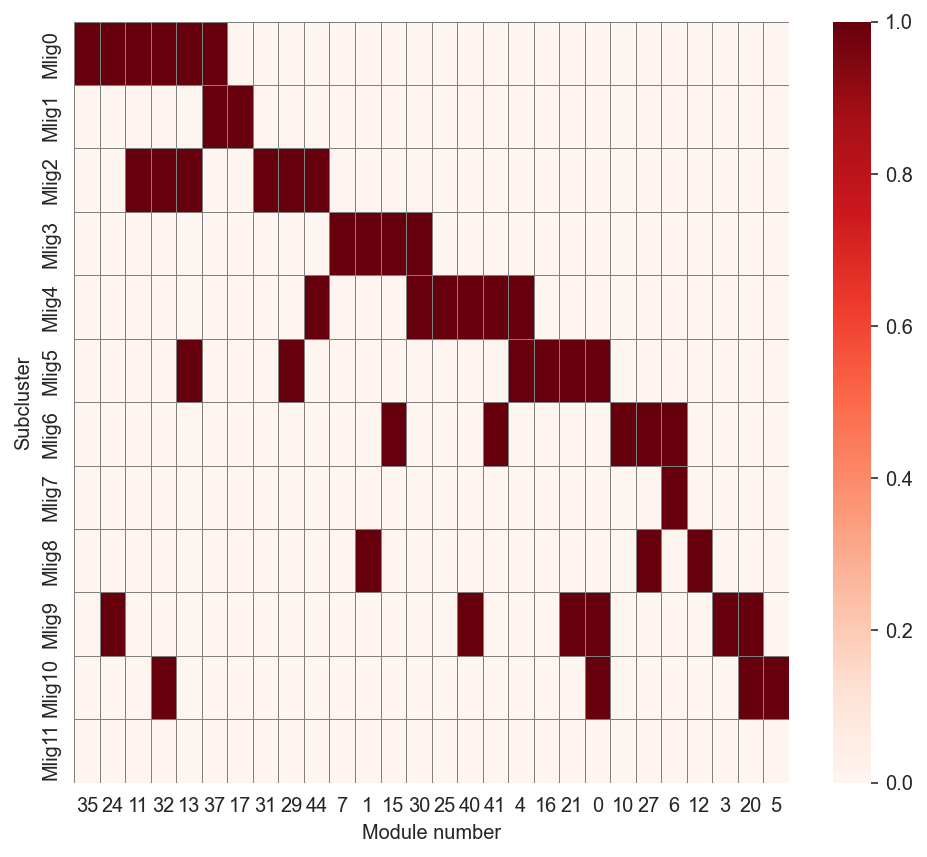

In [569]:
# Just sorting the modules and subclusters to look a little nicer
source = binModM.copy()
slices = []
for row in binModM.index:
    mask = binModM.loc[row,:]
    tmp = source.loc[:,mask]
    for subrow in tmp.index[::-1]:
        tmp = tmp.sort_values( by=subrow, axis=1 )
    slices.append( tmp )
    source = source.loc[:,~mask]
    
f = plt.figure( figsize=(8,7) )
sns.heatmap( pd.concat( slices, axis=1 ), cmap='Reds', ax=f.gca(), linewidths=0.5, linecolor='grey' )
f.gca().set_xlabel( 'Module number' )
f.gca().set_ylabel( 'Subcluster' )
plt.savefig( 'Plots/EDFig7/PanelED7a_Mlig.svg', format='svg' )
plt.show()

In [570]:
# re-do the numbering so the order  
# from the plot goes from 0 to N
reorderMods = pd.concat(slices,axis=1).columns
rModsM = modsM.copy()
for i, m in enumerate(reorderMods):
    rModsM[modsM==m] = i
for i, m in enumerate(np.sort(modsM[~np.isin(modsM,ntModsM)])):
    rModsM[modsM==m] = ntModsM.size + i

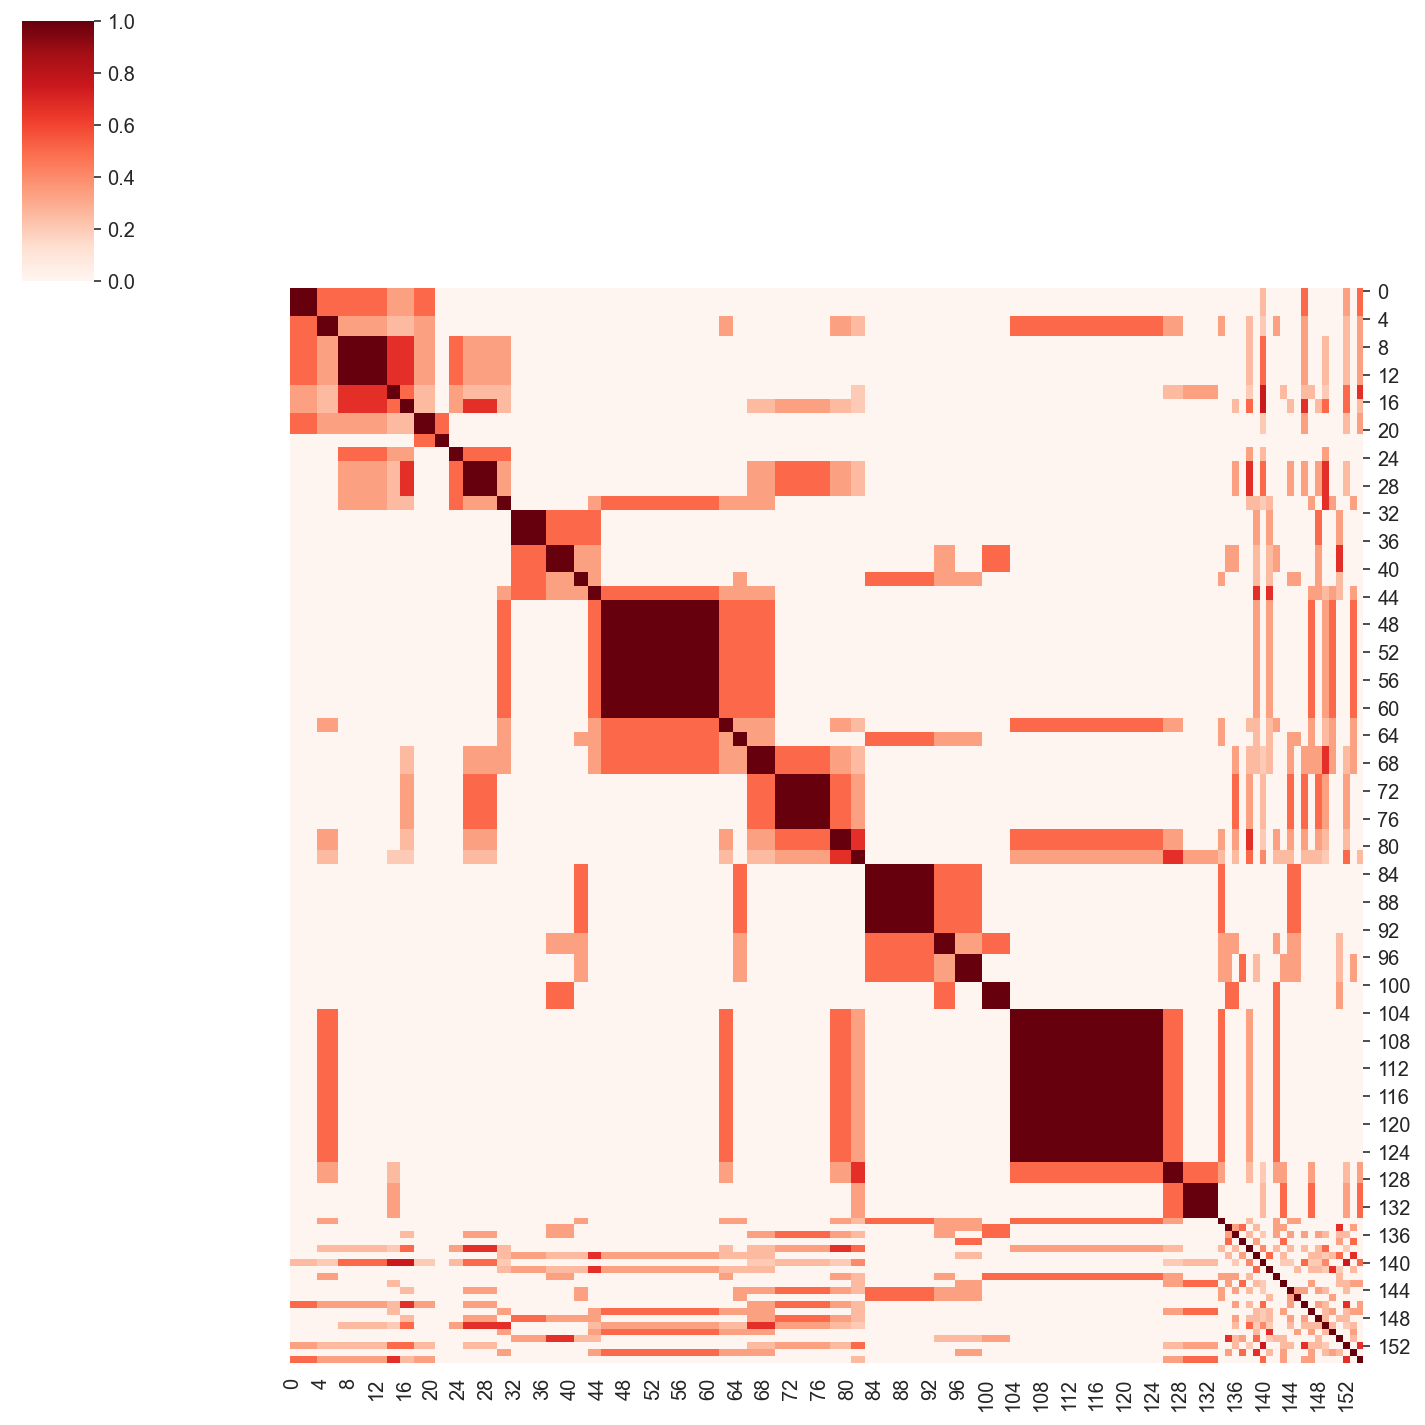

In [576]:
# Same plot as the first one, just rearranged
# so the modules follow the order we just determined
X = jSimM[g.dendrogram_row.reordered_ind,:]\
         [:,g.dendrogram_col.reordered_ind]
featLabels = allGood[g.dendrogram_row.reordered_ind]
modLabels = rModsM[g.dendrogram_row.reordered_ind]
shufInd = np.concatenate([np.argwhere(modLabels==m).flatten() for m in np.arange(modLabels.max()+1)])

X = X[shufInd,:][:,shufInd]
featLabels = featLabels[shufInd]
modLabels = modLabels[shufInd]
sns.clustermap( X, cmap='Reds', row_cluster=False, col_cluster=False )
plt.show()

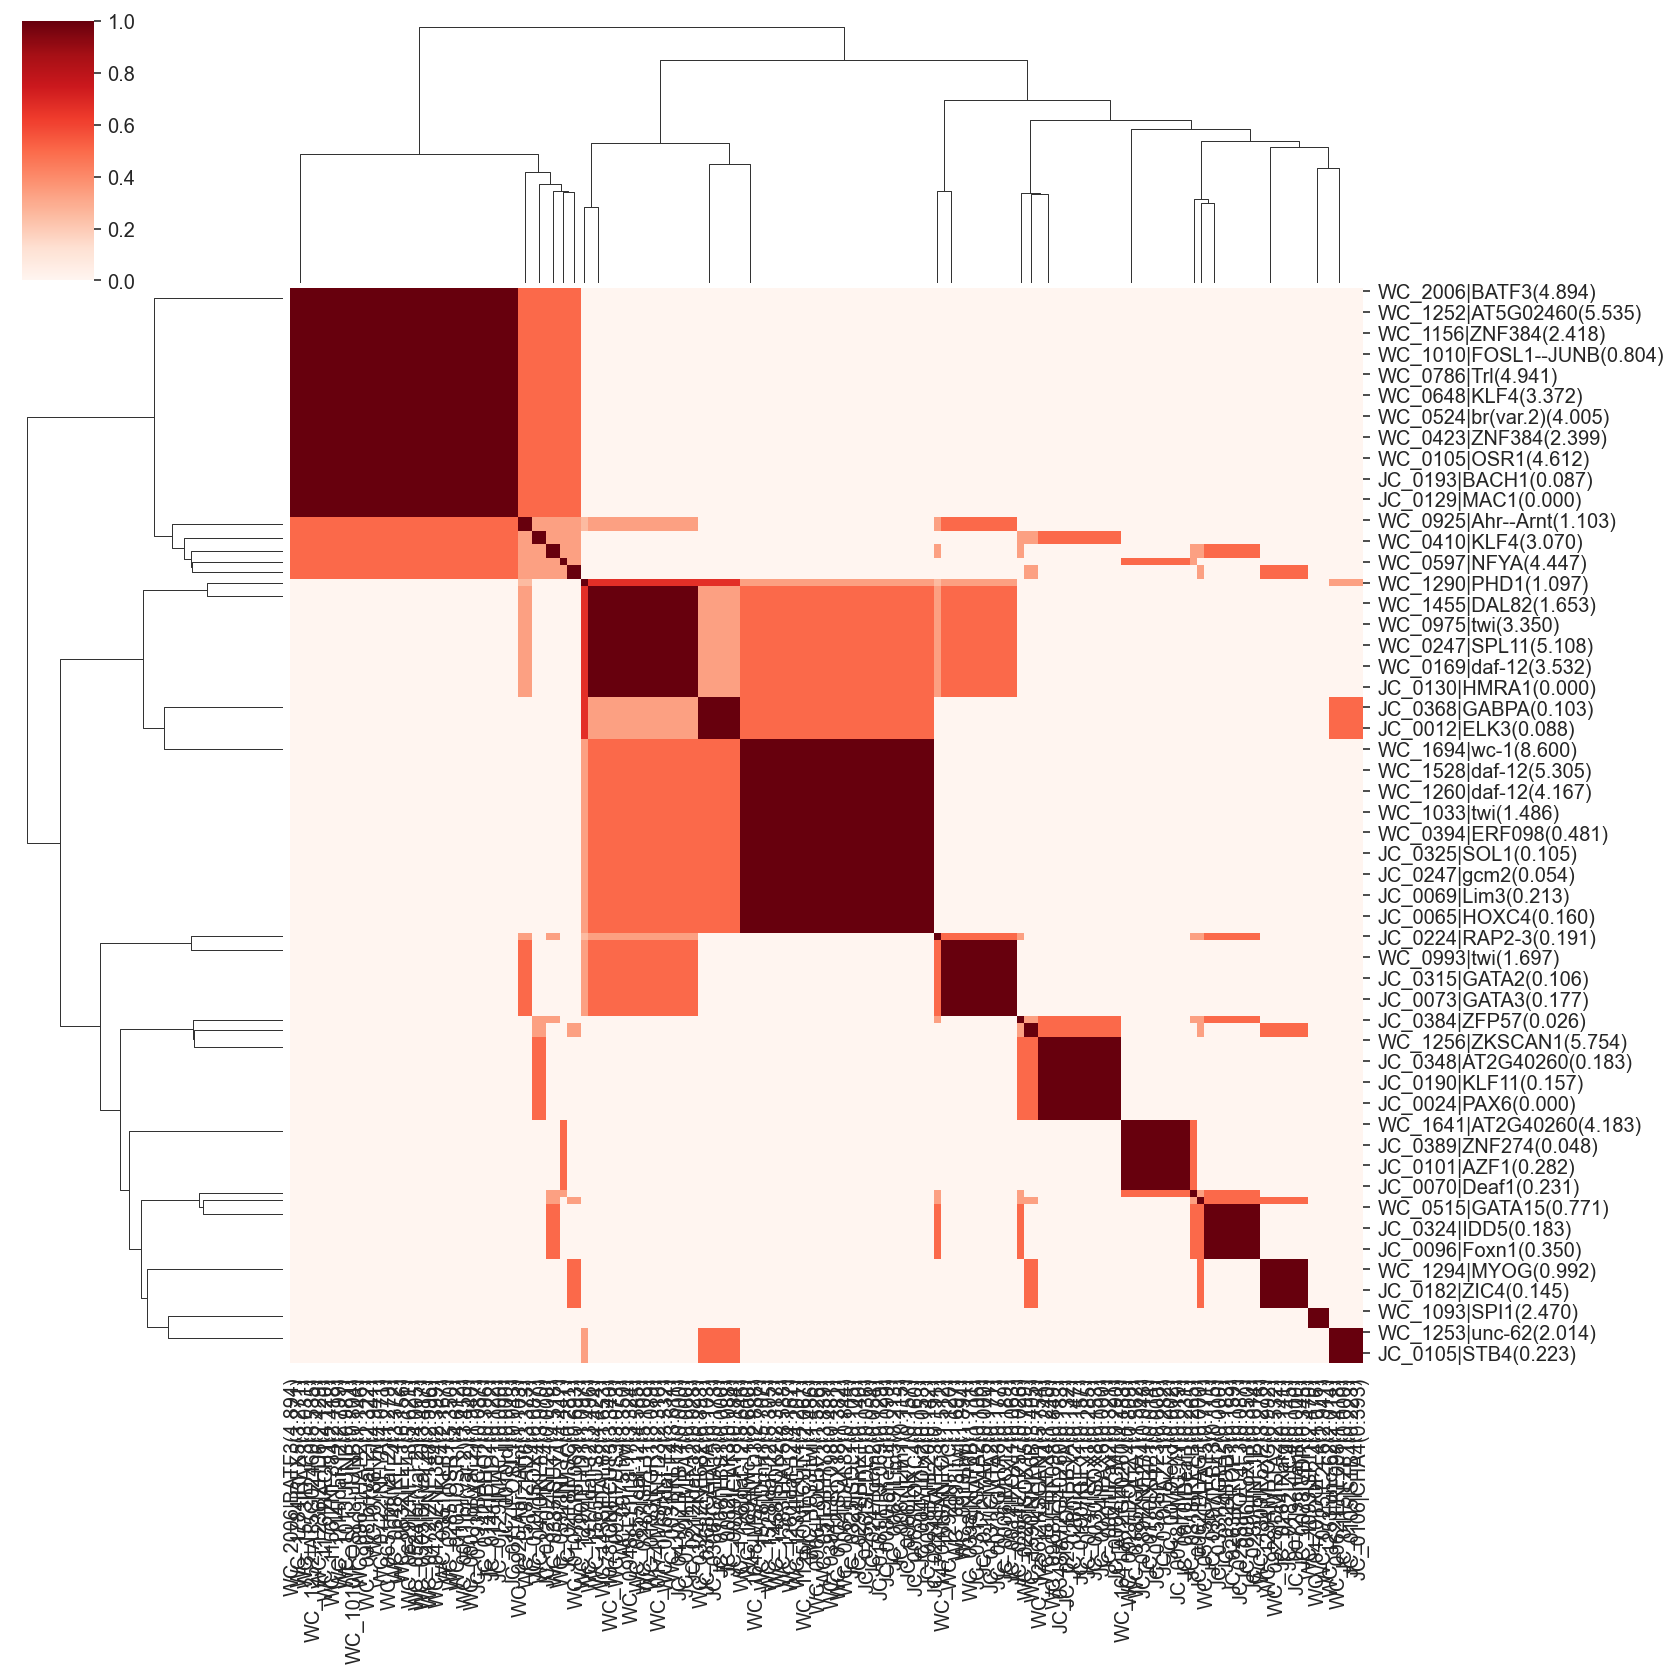

In [476]:
# motif-motif Jaccard similarity based on subcluster-binarized accessibility
X = binnedP.loc[:,allGood].T.astype(int)
X = X.loc[X.sum(1)>0,:]
intersect = X.values @ X.values.T
sizes = np.diag( intersect ).copy()
sizes = np.repeat( sizes[None,:], sizes.size, axis=0 )
union = sizes + sizes.T - intersect
jSimP = intersect / union
g = sns.clustermap( jSimP, metric='euclidean', method='average', cmap='Reds', robust=True )
g.ax_heatmap.set_xticks(np.arange(X.index.size)[::1]+0.5)
g.ax_heatmap.set_xticklabels(X.index[g.dendrogram_col.reordered_ind][::1], rotation=90)
g.ax_heatmap.set_yticks(np.arange(X.index.size)[::3]+0.5)
g.ax_heatmap.set_yticklabels(X.index[g.dendrogram_row.reordered_ind][::3], rotation=0)
plt.show()

In [477]:
# Same deal as before, make the adjacency matrix ...
G = ig.Graph.Adjacency( (jSimP==1).tolist() )
G.vs['label'] = allGood
# ..., find the connected components
comp = G.connected_components( mode='weak' )

In [478]:
modsP = np.array(comp.membership)
u, c = np.unique( modsP, return_counts=True )
print( '{0} components, {1} with more than 1 member'.format( u.size, (c>1).sum() ) )
np.array(list(zip(u[c>1],c[c>1]))).T

22 components, 16 with more than 1 member


array([[ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 15, 17, 18, 20],
       [12, 11, 33,  6, 10, 28,  7,  8,  5, 16,  2,  2,  2,  2,  3,  2]])

In [479]:
# Find all of the non-trivial modules
# alongside their accessibility patterns
ntModsP = u[c>1]
slices = []
for mod in ntModsP:
    tmp = binnedP.loc[:,allGood].iloc[:,modsP==mod].T
    tmp['Mod'] = mod
    tmp = tmp.set_index( 'Mod', append=True ).T
    slices.append( tmp )
binModP = pd.concat( slices, axis=1 )
binModP = binModP.groupby( 'Mod', axis=1 ).any()
binModP.astype(int)

Mod    0   1   2   3   4   5   7   8   9   10  11  12  15  17  18  20
Smed0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
Smed1   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
Smed2   1   0   0   0   0   0   0   0   0   0   1   0   0   1   0   0
Smed3   0   0   0   1   0   0   0   0   1   0   0   0   0   0   0   0
Smed4   0   0   0   1   0   1   0   0   0   1   0   0   0   0   0   0
Smed5   0   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0
Smed6   0   0   1   0   0   0   0   0   0   0   1   1   1   0   0   1
Smed7   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0
Smed8   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   1

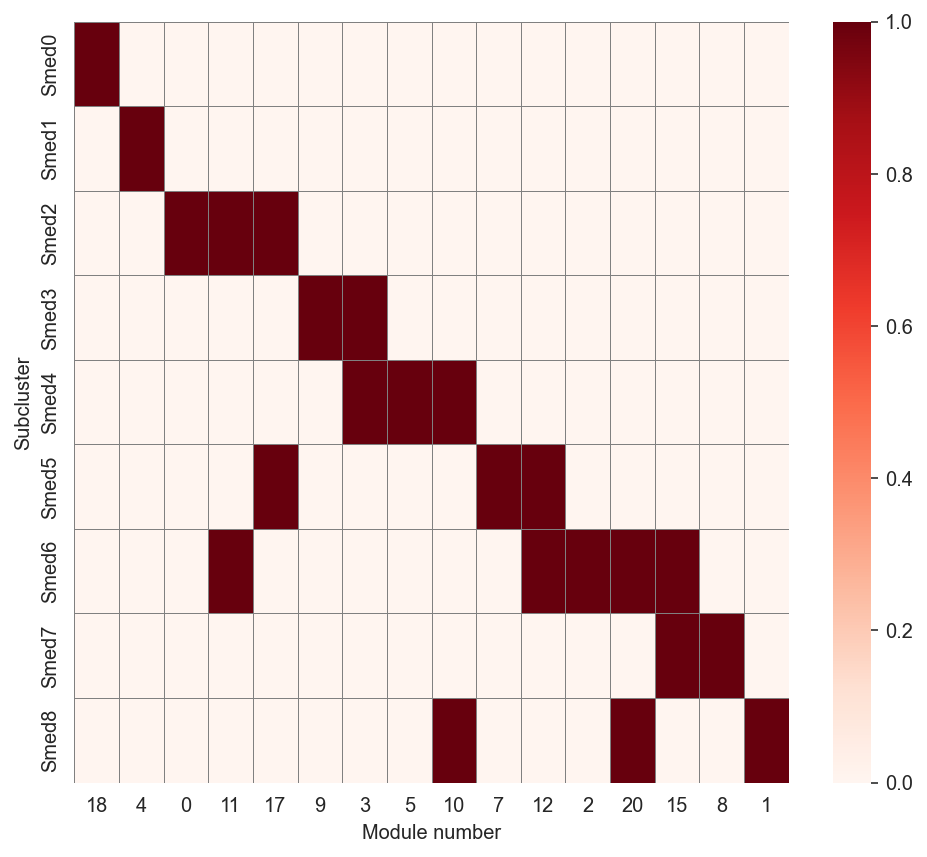

In [480]:
source = binModP.copy()
slices = []
for row in binModP.index:
    mask = binModP.loc[row,:]
    tmp = source.loc[:,mask]
    for subrow in tmp.index[::-1]:
        tmp = tmp.sort_values( by=subrow, axis=1 )
    slices.append( tmp )
    source = source.loc[:,~mask]
    
f = plt.figure( figsize=(8,7) )
sns.heatmap( pd.concat( slices, axis=1 ), cmap='Reds', ax=f.gca(), linewidths=0.5, linecolor='grey' )
f.gca().set_xlabel( 'Module number' )
f.gca().set_ylabel( 'Subcluster' )
plt.savefig( 'Plots/EDFig7/PanelED7a_Smed.svg', format='svg' )
plt.show()

In [481]:
reorderMods = pd.concat(slices,axis=1).columns
rModsP = modsP.copy()
for i, m in enumerate(reorderMods):
    rModsP[modsP==m] = i
for i, m in enumerate(np.sort(modsP[~np.isin(modsP,ntModsP)])):
    rModsP[modsP==m] = ntModsP.size + i

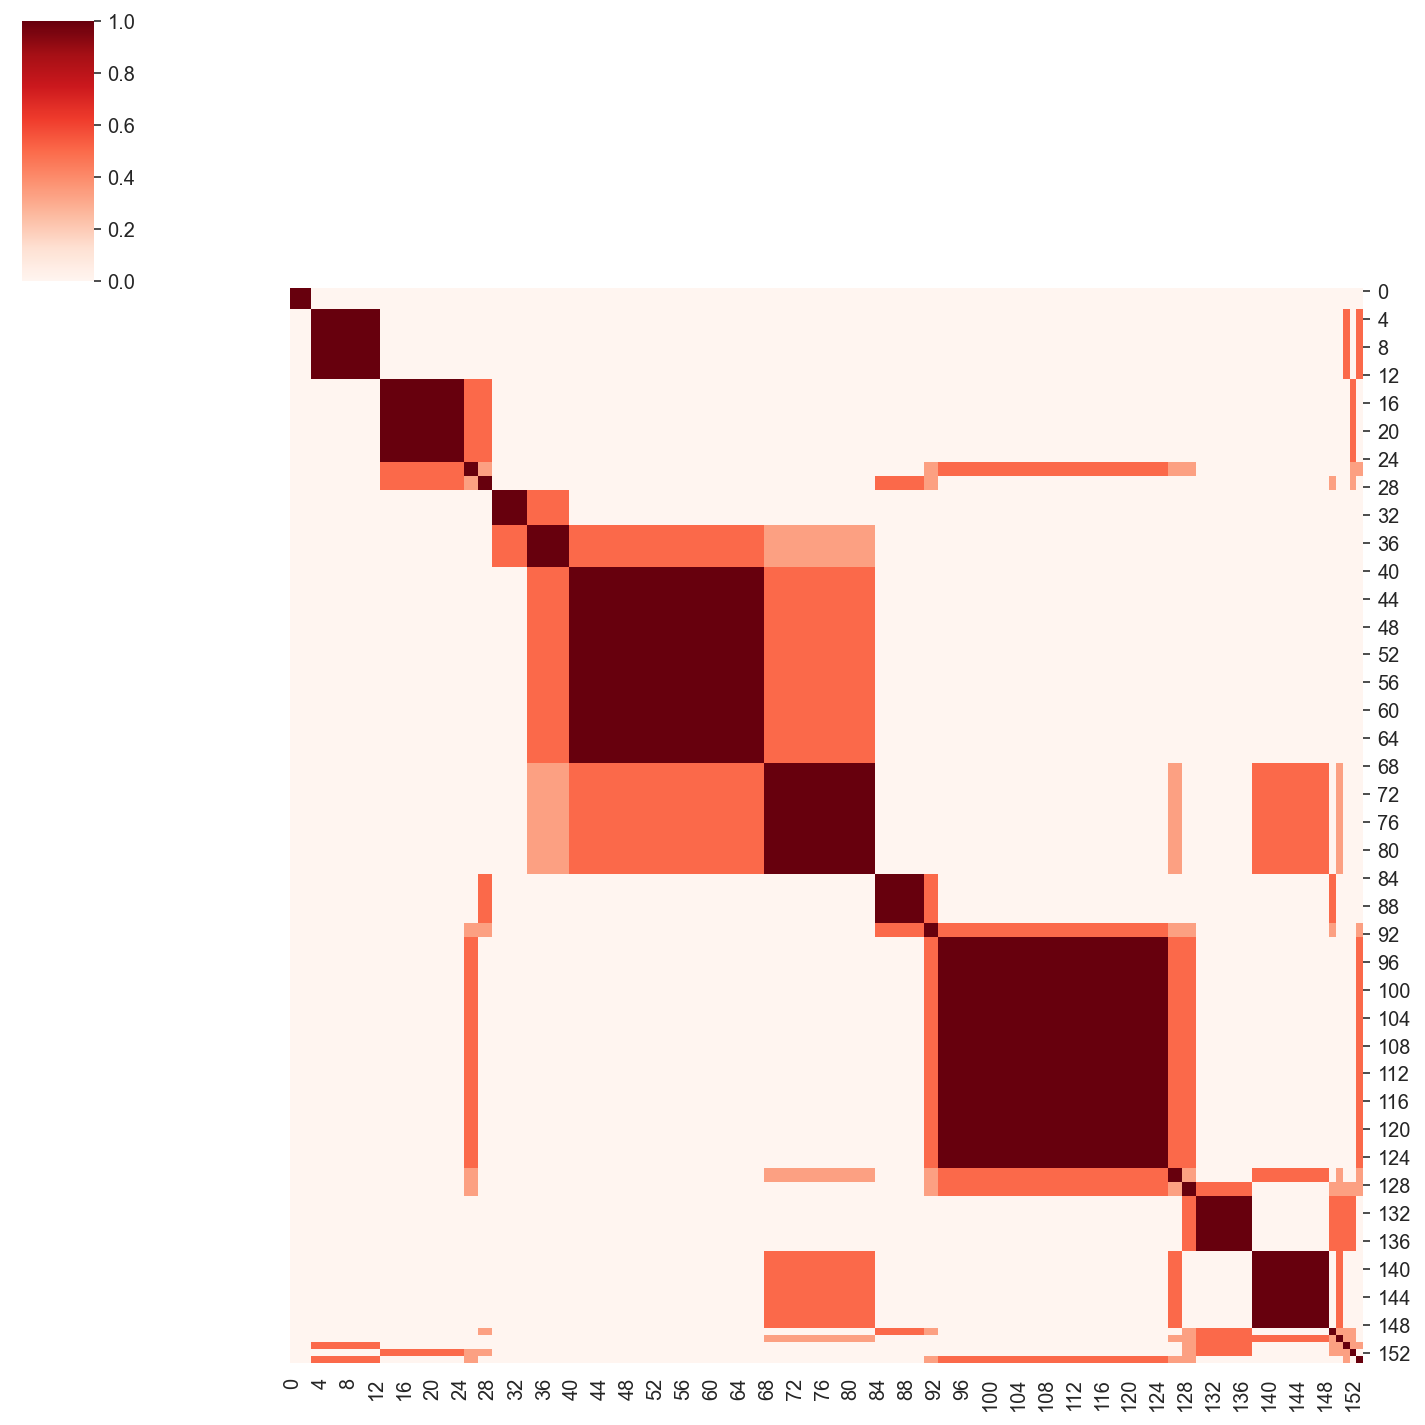

In [482]:
X = jSimP[g.dendrogram_row.reordered_ind,:]\
         [:,g.dendrogram_col.reordered_ind]
featLabels = allGood[g.dendrogram_row.reordered_ind]
modLabels = rModsP[g.dendrogram_row.reordered_ind]
shufInd = np.concatenate([np.argwhere(modLabels==m).flatten() for m in np.arange(modLabels.max())])

X = X[shufInd,:][:,shufInd]
featLabels = featLabels[shufInd]
modLabels = modLabels[shufInd]
sns.clustermap( X, cmap='Reds', row_cluster=False, col_cluster=False )
plt.show()

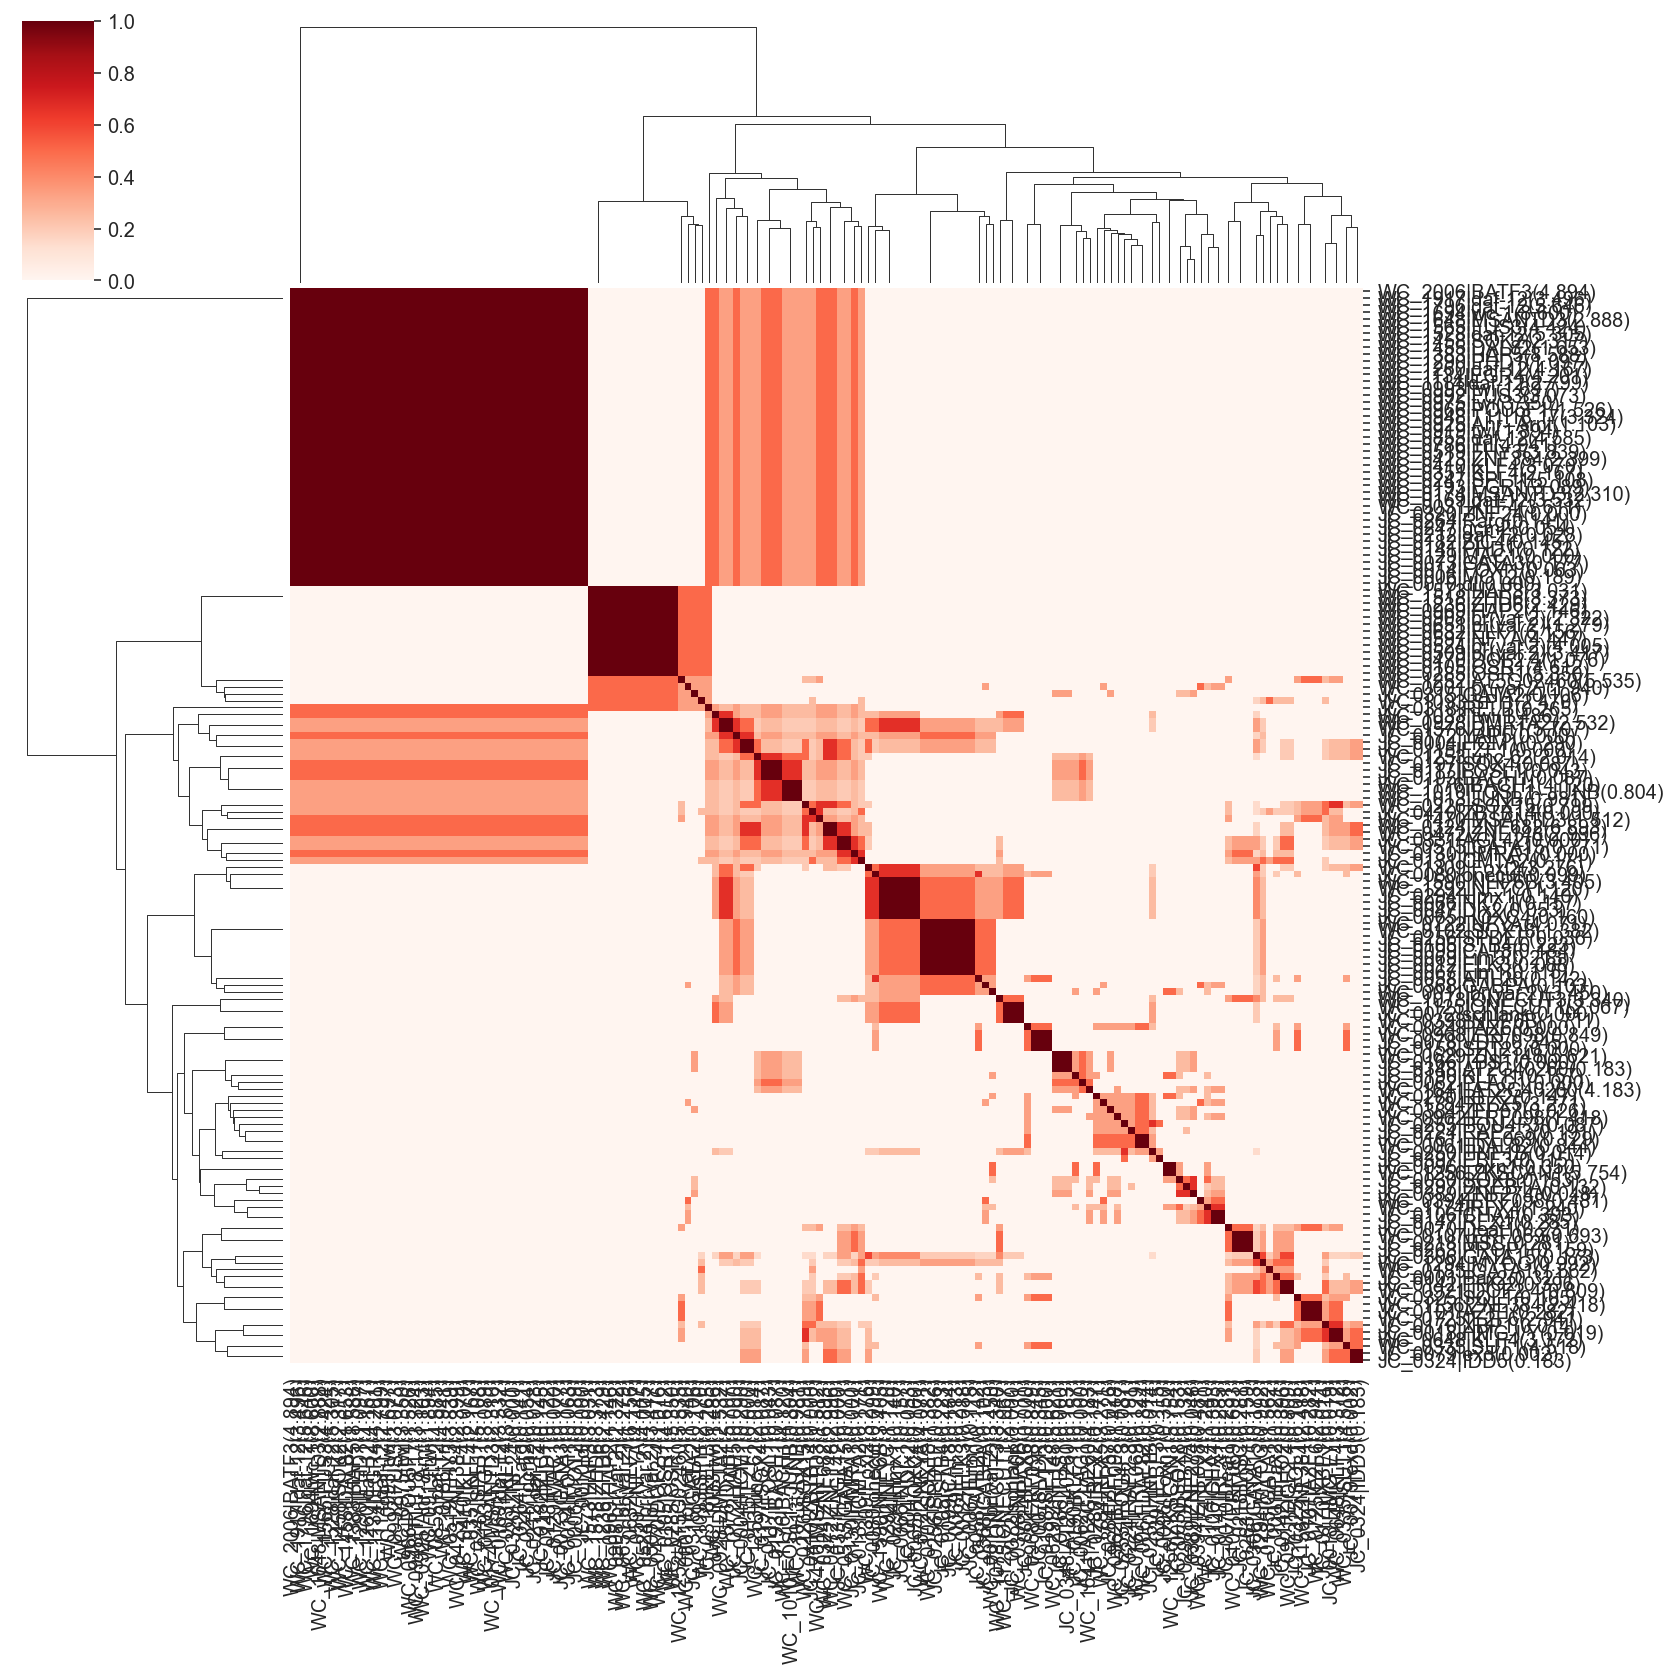

In [484]:
# motif-motif Jaccard similarity based on subcluster-binarized accessibility
X = binnedS.loc[:,allGood].T.astype(int)
X = X.loc[X.sum(1)>0,:]
intersect = X.values @ X.values.T
sizes = np.diag( intersect ).copy()
sizes = np.repeat( sizes[None,:], sizes.size, axis=0 )
union = sizes + sizes.T - intersect
jSimS = intersect / union
g = sns.clustermap( jSimS, metric='euclidean', method='average', cmap='Reds', robust=True )
g.ax_heatmap.set_xticks(np.arange(X.index.size)[::1]+0.5)
g.ax_heatmap.set_xticklabels(X.index[g.dendrogram_col.reordered_ind][::1], rotation=90)
g.ax_heatmap.set_yticks(np.arange(X.index.size)[::1]+0.5)
g.ax_heatmap.set_yticklabels(X.index[g.dendrogram_row.reordered_ind][::1], rotation=0)
plt.show()

In [485]:
G = ig.Graph.Adjacency( (jSimS==1).tolist() )
G.vs['label'] = allGood
comp = G.connected_components( mode='weak' )

In [486]:
modsS = np.array(comp.membership)
u, c = np.unique( modsS, return_counts=True )
print( '{0} components, {1} with more than 1 member'.format( u.size, (c>1).sum() ) )
np.array(list(zip(u[c>1],c[c>1]))).T

65 components, 21 with more than 1 member


array([[ 1,  2,  3,  4,  7, 11, 12, 13, 15, 16, 17, 18, 21, 22, 23, 27,
        37, 45, 48, 51, 53],
       [ 2, 43,  8,  2,  6,  3,  3,  2,  2,  3,  2,  3,  2,  2,  3,  3,
         2, 13,  2,  2,  3]])

In [487]:
ntModsS = u[c>1]
slices = []
for mod in ntModsS:
    tmp = binnedS.loc[:,allGood].iloc[:,modsS==mod].T
    tmp['Mod'] = mod
    tmp = tmp.set_index( 'Mod', append=True ).T
    slices.append( tmp )
binModS = pd.concat( slices, axis=1 )
binModS = binModS.groupby( 'Mod', axis=1 ).any()
binModS.astype(int)

Mod     1   2   3   4   7   11  12  13  15  16  ...  18  21  22  23  27  37  \
Sman0    0   0   0   0   0   0   0   0   0   0  ...   0   1   0   0   1   1   
Sman1    0   0   0   0   0   0   0   0   0   0  ...   0   1   0   0   0   0   
Sman2    0   0   0   1   0   0   0   0   0   1  ...   0   0   0   0   0   0   
Sman3    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman4    0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   
Sman5    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman6    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   1   0   0   
Sman7    0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   
Sman8    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman9    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman10   1   0   1   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman11   0   0   0   0   1   1   0   0   0   0  ...   0   0   0   0   0   0   
Sman12   0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   0   0   
Sman13   0   0   0   0   0   0   0   0   0   0  ...   1   0   0   1   0   0   
Sman14   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman15   1   0   0   1   0   0   0   1   0   0  ...   0   1   0   0   0   1   
Sman16   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
Sman17   1   1   0   0   0   0   0   0   0   0  ...   1   0   0   0   0   1   

Mod     45  48  51  53  
Sman0    0   0   0   0  
Sman1    0   0   0   0  
Sman2    0   0   0   0  
Sman3    1   0   0   0  
Sman4    0   0   0   0  
Sman5    0   0   0   0  
Sman6    0   0   0   0  
Sman7    0   0   0   0  
Sman8    0   0   0   0  
Sman9    0   0   0   0  
Sman10   0   0   1   0  
Sman11   0   0   1   0  
Sman12   0   0   0   0  
Sman13   0   0   0   1  
Sman14   0   0   0   1  
Sman15   0   1   0   0  
Sman16   0   0   0   0  
Sman17   0   1   1   1  

[18 rows x 21 columns]

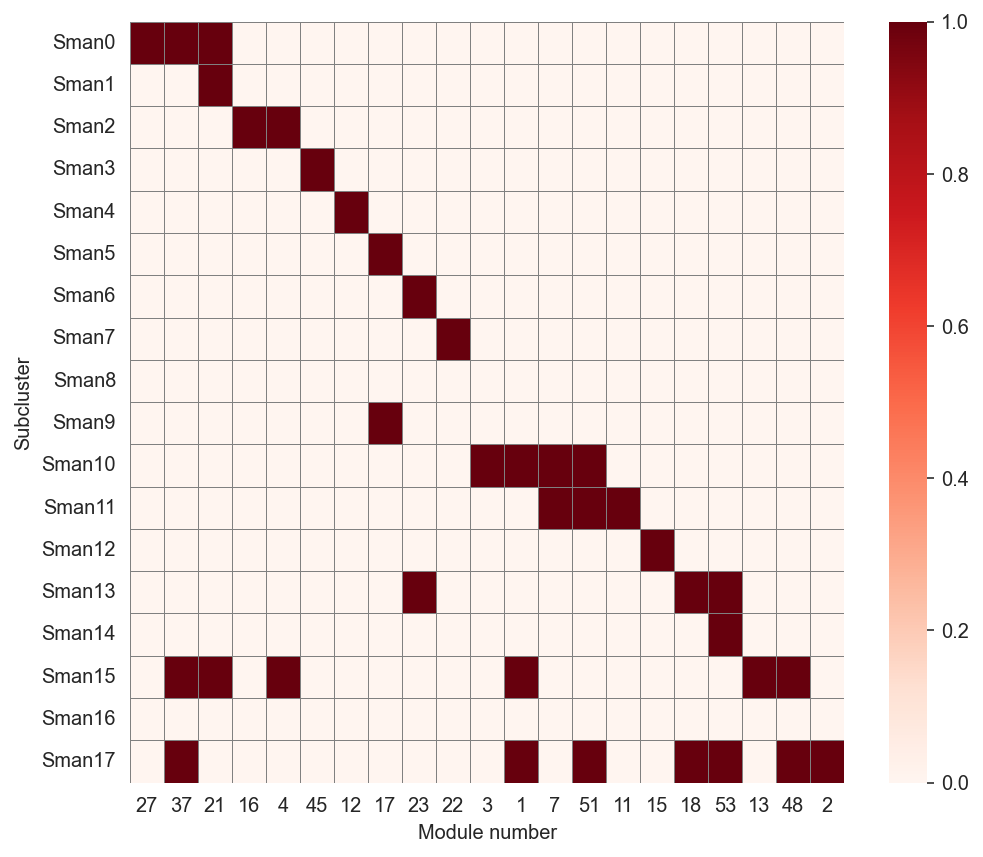

In [489]:
source = binModS.copy()
slices = []
for row in binModS.index:
    mask = binModS.loc[row,:]
    tmp = source.loc[:,mask]
    for subrow in tmp.index[::-1]:
        tmp = tmp.sort_values( by=subrow, axis=1 )
    slices.append( tmp )
    source = source.loc[:,~mask]
    
f = plt.figure( figsize=(8,7) )
sns.heatmap( pd.concat( slices, axis=1 ), cmap='Reds', ax=f.gca(), linewidths=0.5, linecolor='grey' )
f.gca().set_xlabel( 'Module number' )
f.gca().set_ylabel( 'Subcluster' )
plt.savefig( 'Plots/EDFig7/PanelED7a_Sman.svg', format='svg' )
plt.show()

In [490]:
reorderMods = pd.concat(slices,axis=1).columns
reorderMods
rModsS = modsS.copy()
for i, m in enumerate(reorderMods):
    rModsS[modsS==m] = i
for i, m in enumerate(np.sort(modsS[~np.isin(modsS,ntModsS)])):
    rModsS[modsS==m] = ntModsS.size + i

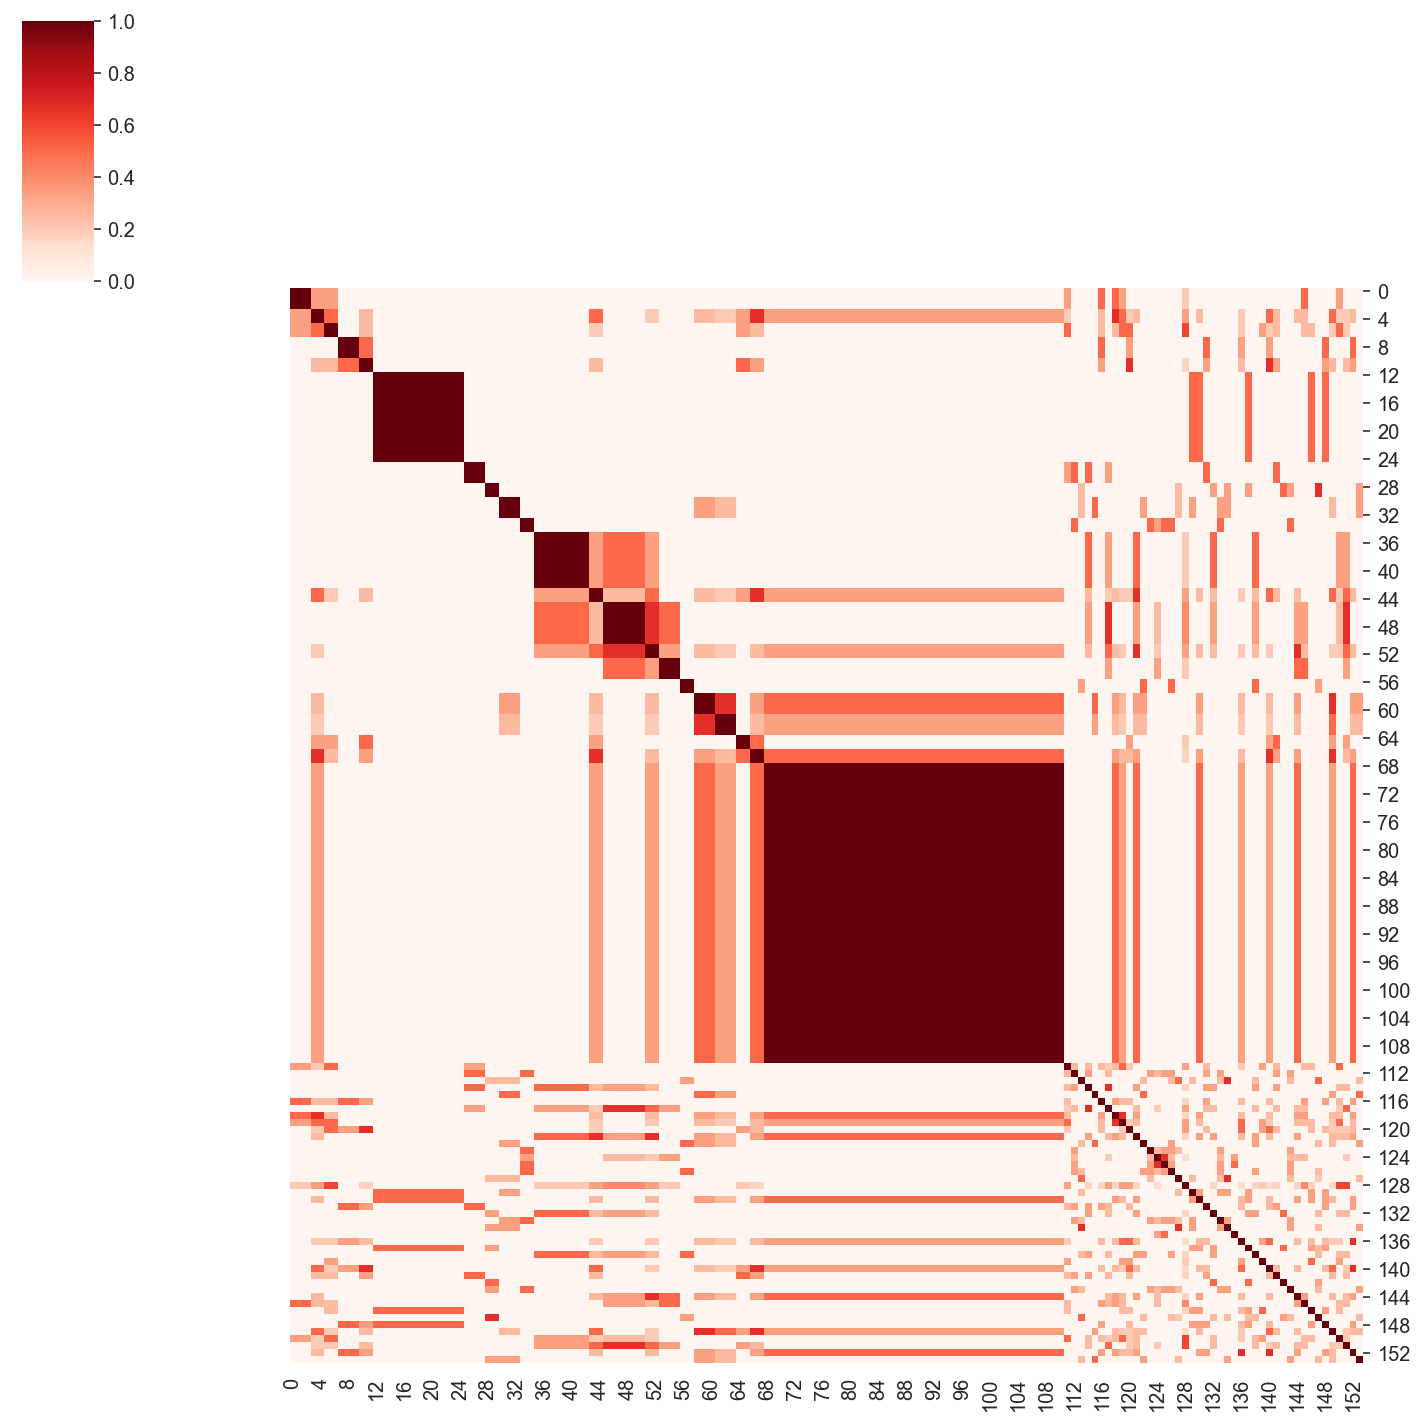

In [491]:
X = jSimS[g.dendrogram_row.reordered_ind,:]\
         [:,g.dendrogram_col.reordered_ind]
featLabels = allGood[g.dendrogram_row.reordered_ind]
modLabels = rModsS[g.dendrogram_row.reordered_ind]
shufInd = np.concatenate([np.argwhere(modLabels==m).flatten() for m in np.arange(modLabels.max())])

X = X[shufInd,:][:,shufInd]
featLabels = featLabels[shufInd]
modLabels = modLabels[shufInd]
sns.clustermap( X, cmap='Reds', row_cluster=False, col_cluster=False )
plt.show()

## Plot out binarized accessibilities for some key motifs

The binarized accessibility patterns here were used to generate the plots for panel 3d. Motifs are represented by columns with the target motif of interest in the first column. Subclusters for each species are represented by rows, and boxes are filled if the motif in that column is considered to be highly accessible in that subcluster. To generate the plots in Fig 3d, columns which exactly match the first are represented by filled circles. Columns which share some or all highly accessible subclusters with the first column but are either missing some, or include extras are represented as half-filled circles. Columns with no overlap are represented as empty circles

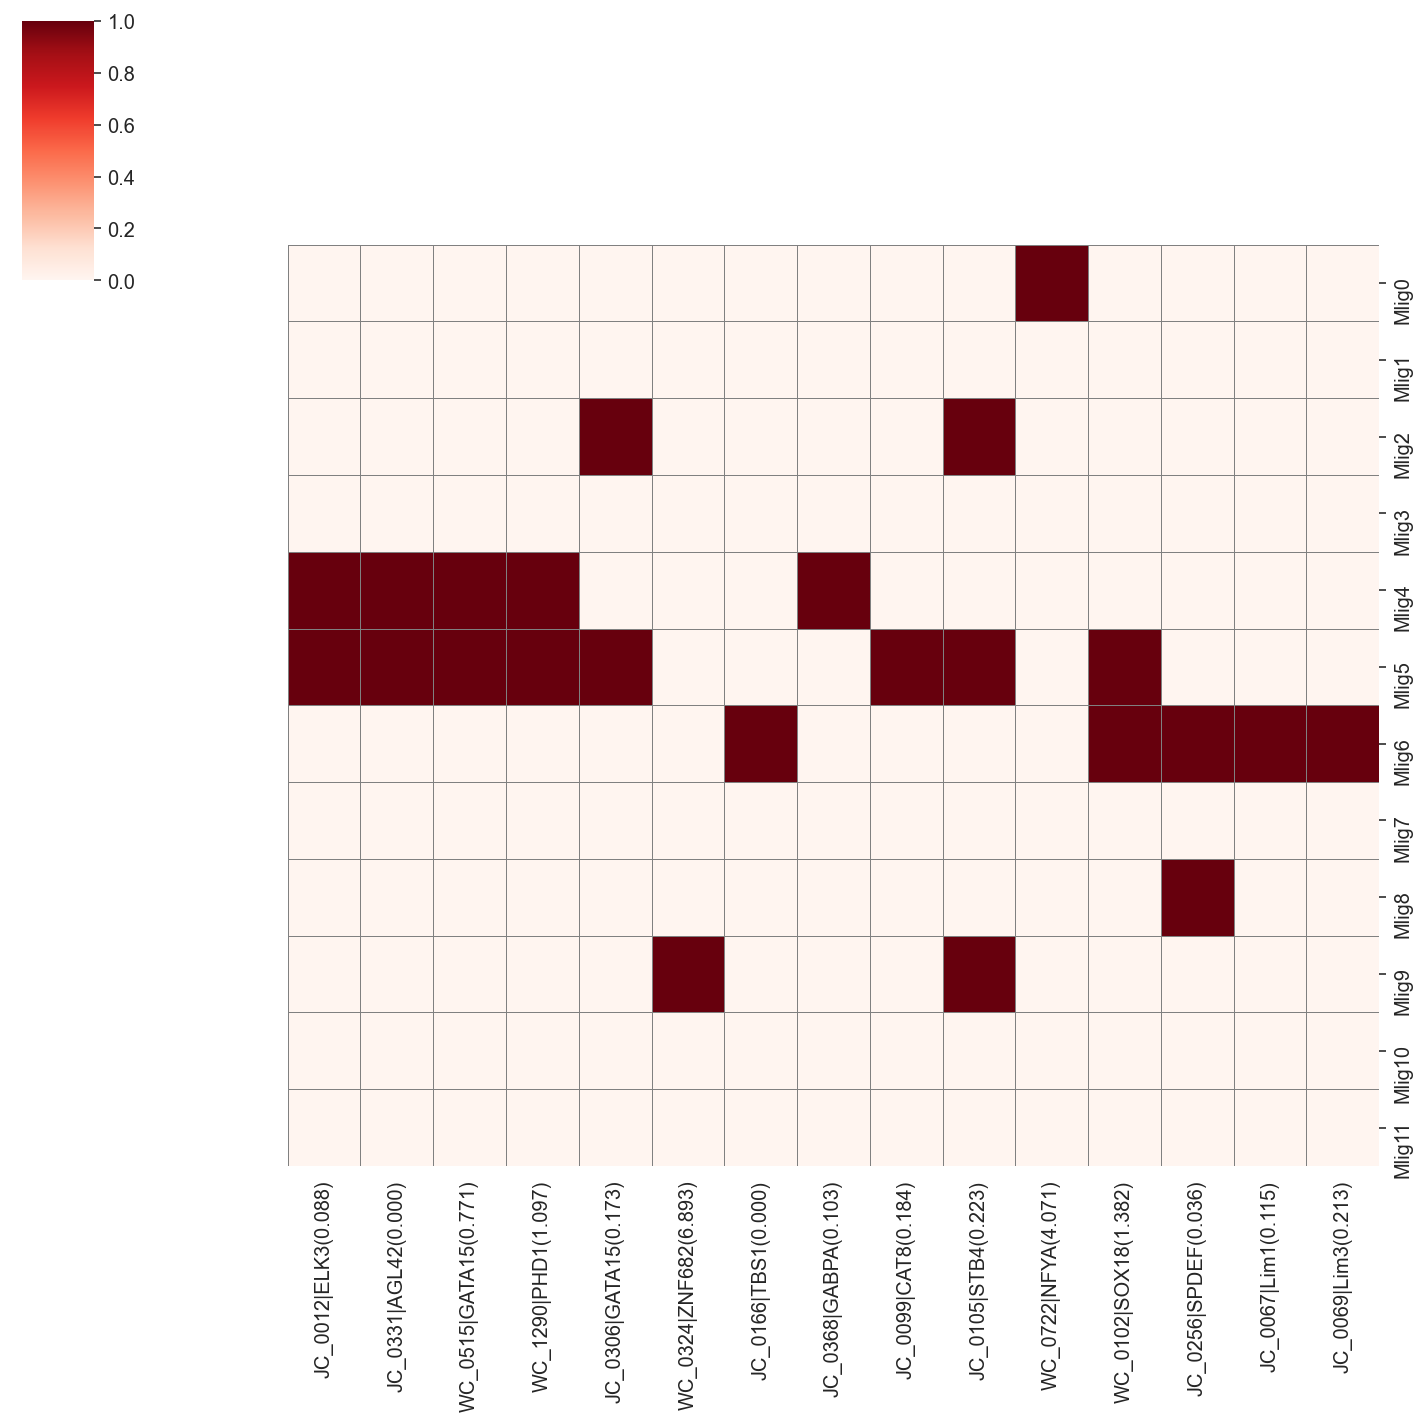

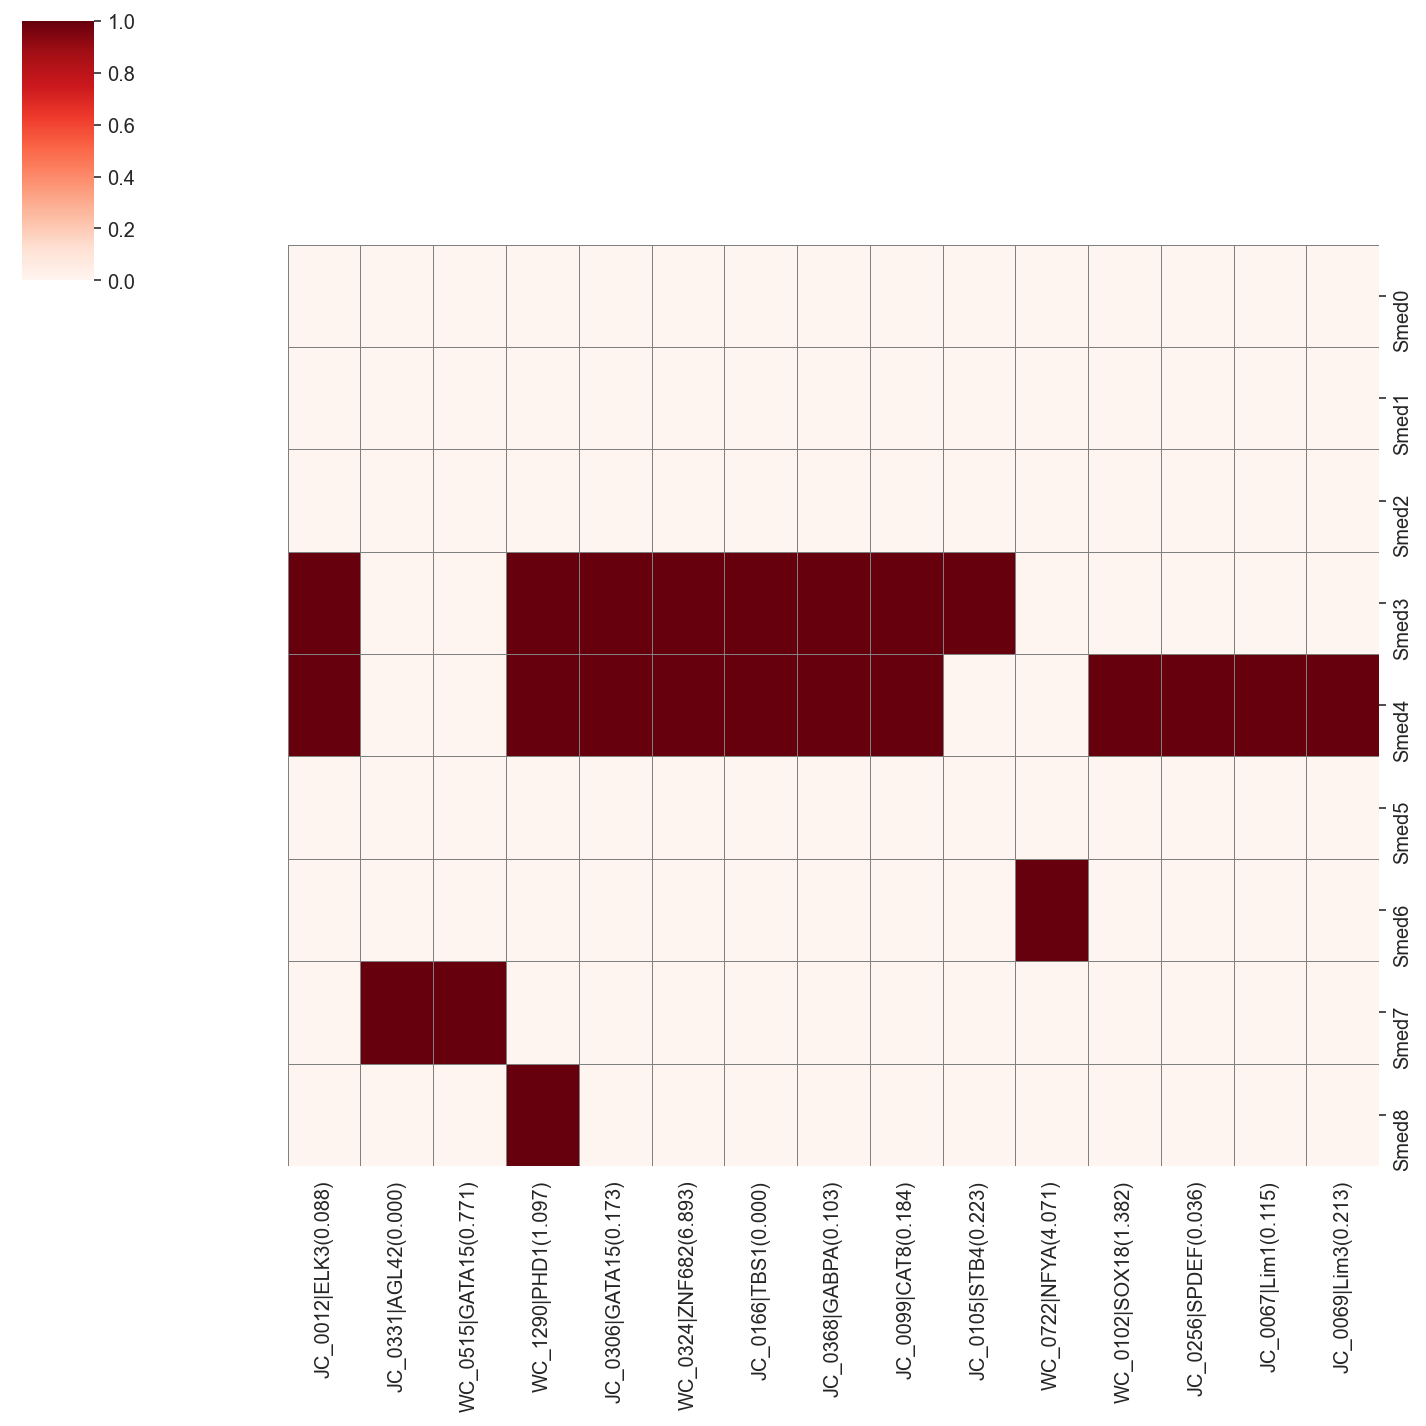

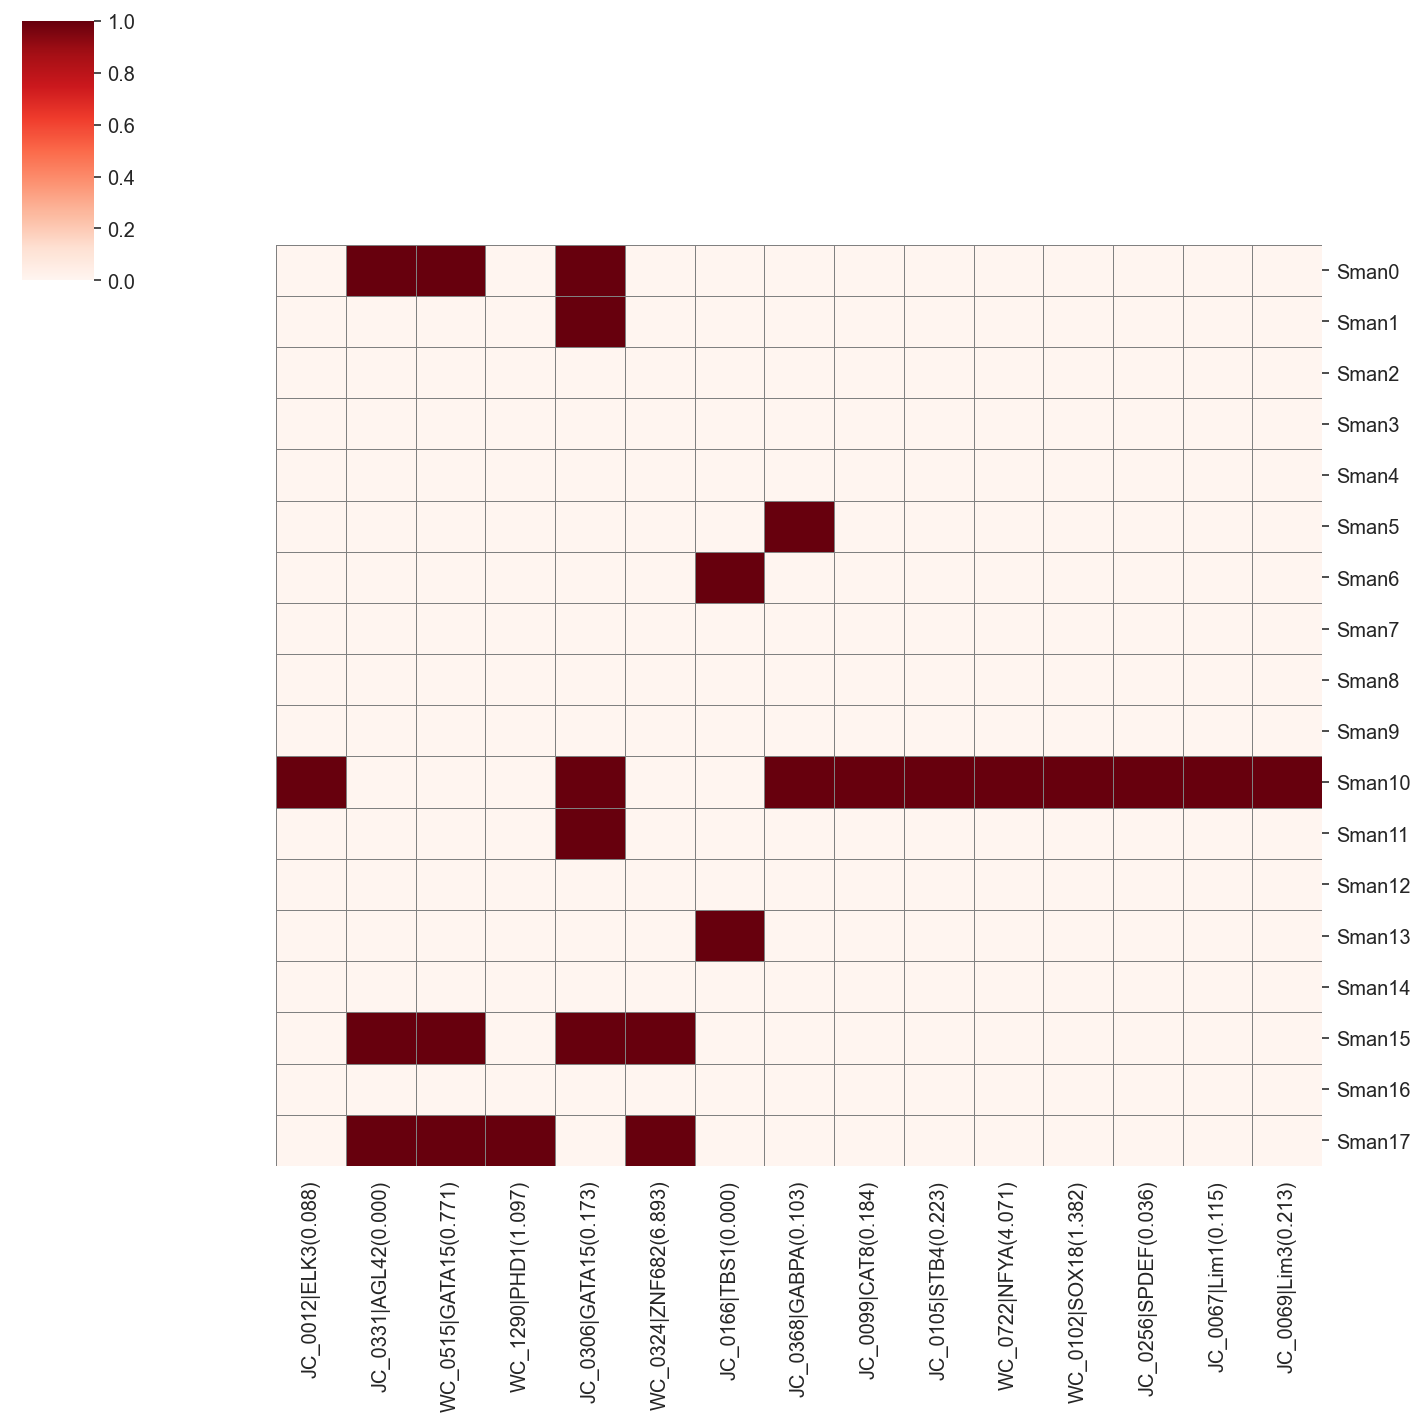

(39, 15)
Index(['JC_0012|ELK3(0.088)', 'JC_0331|AGL42(0.000)', 'WC_0515|GATA15(0.771)',
       'WC_1290|PHD1(1.097)', 'JC_0306|GATA15(0.173)', 'WC_0324|ZNF682(6.893)',
       'JC_0166|TBS1(0.000)', 'JC_0368|GABPA(0.103)', 'JC_0099|CAT8(0.184)',
       'JC_0105|STB4(0.223)', 'WC_0722|NFYA(4.071)', 'WC_0102|SOX18(1.382)',
       'JC_0256|SPDEF(0.036)', 'JC_0067|Lim1(0.115)', 'JC_0069|Lim3(0.213)'],
      dtype='object')


In [513]:
motifTarget = 'JC_0012|ELK3(0.088)'
# Grab the module numbers in each species
mM = rModsM[allGood==motifTarget]
mP = rModsP[allGood==motifTarget]
mS = rModsS[allGood==motifTarget]
# Pull out all motifs in the same module
# for at least one of the species
modMotifs = allGood[(rModsM==mM)|\
                    (rModsP==mP)|\
                    (rModsS==mS)]
# Grab module identities for these 
# motifs in each of the species
subModsM = rModsM[np.isin(allGood,modMotifs)]
binModsM = subModsM == subModsM[modMotifs==motifTarget][0]
subModsP = rModsP[np.isin(allGood,modMotifs)]
binModsP = subModsP == subModsP[modMotifs==motifTarget][0]
subModsS = rModsS[np.isin(allGood,modMotifs)]
binModsS = subModsS == subModsS[modMotifs==motifTarget][0]
# Subset the binary accessibility patterns
# to these motifs of interest
bM = binnedM.loc[:,modMotifs]
bP = binnedP.loc[:,modMotifs]
bS = binnedS.loc[:,modMotifs]
spLabels = np.concatenate( (['Mlig']*binnedM.shape[0],
                            ['Smed']*binnedP.shape[0],
                            ['Sman']*binnedS.shape[0]) )

B = pd.DataFrame( data=np.concatenate( (bM,bP,bS), axis=0 ),
                  index=np.concatenate( (binnedM.index,
                                         binnedP.index,
                                         binnedS.index) ),
                  columns=modMotifs )

g = sns.clustermap( B, robust=True, metric='hamming', method='average', cmap='Reds' )
plt.close()

# Redo the colummns so that any shared ones
# show up first/just make a somewhat nice
# order to look at
B = B.iloc[:,g.dendrogram_col.reordered_ind]
modMotifs = modMotifs[g.dendrogram_col.reordered_ind]
subModsM = subModsM[g.dendrogram_col.reordered_ind]
binModsM = binModsM[g.dendrogram_col.reordered_ind]
subModsP = subModsP[g.dendrogram_col.reordered_ind]
binModsP = binModsP[g.dendrogram_col.reordered_ind]
subModsS = subModsS[g.dendrogram_col.reordered_ind]
binModsS = binModsS[g.dendrogram_col.reordered_ind]
binTarg = modMotifs == motifTarget
reCol = np.concatenate( [np.argwhere(binTarg).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&~binModsP&binModsS).flatten()] )
B = B.iloc[:,reCol]
modMotifs = modMotifs[reCol]
subModsM = subModsM[reCol]
binModsM = binModsM[reCol]
subModsP = subModsP[reCol]
binModsP = binModsP[reCol]
subModsS = subModsS[reCol]
binModsS = binModsS[reCol]

# Plot the binarized accessibility patterns for each species
sns.clustermap( B.iloc[spLabels=='Mlig'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Smed'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Sman'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()
print( B.shape )
print( B.columns )

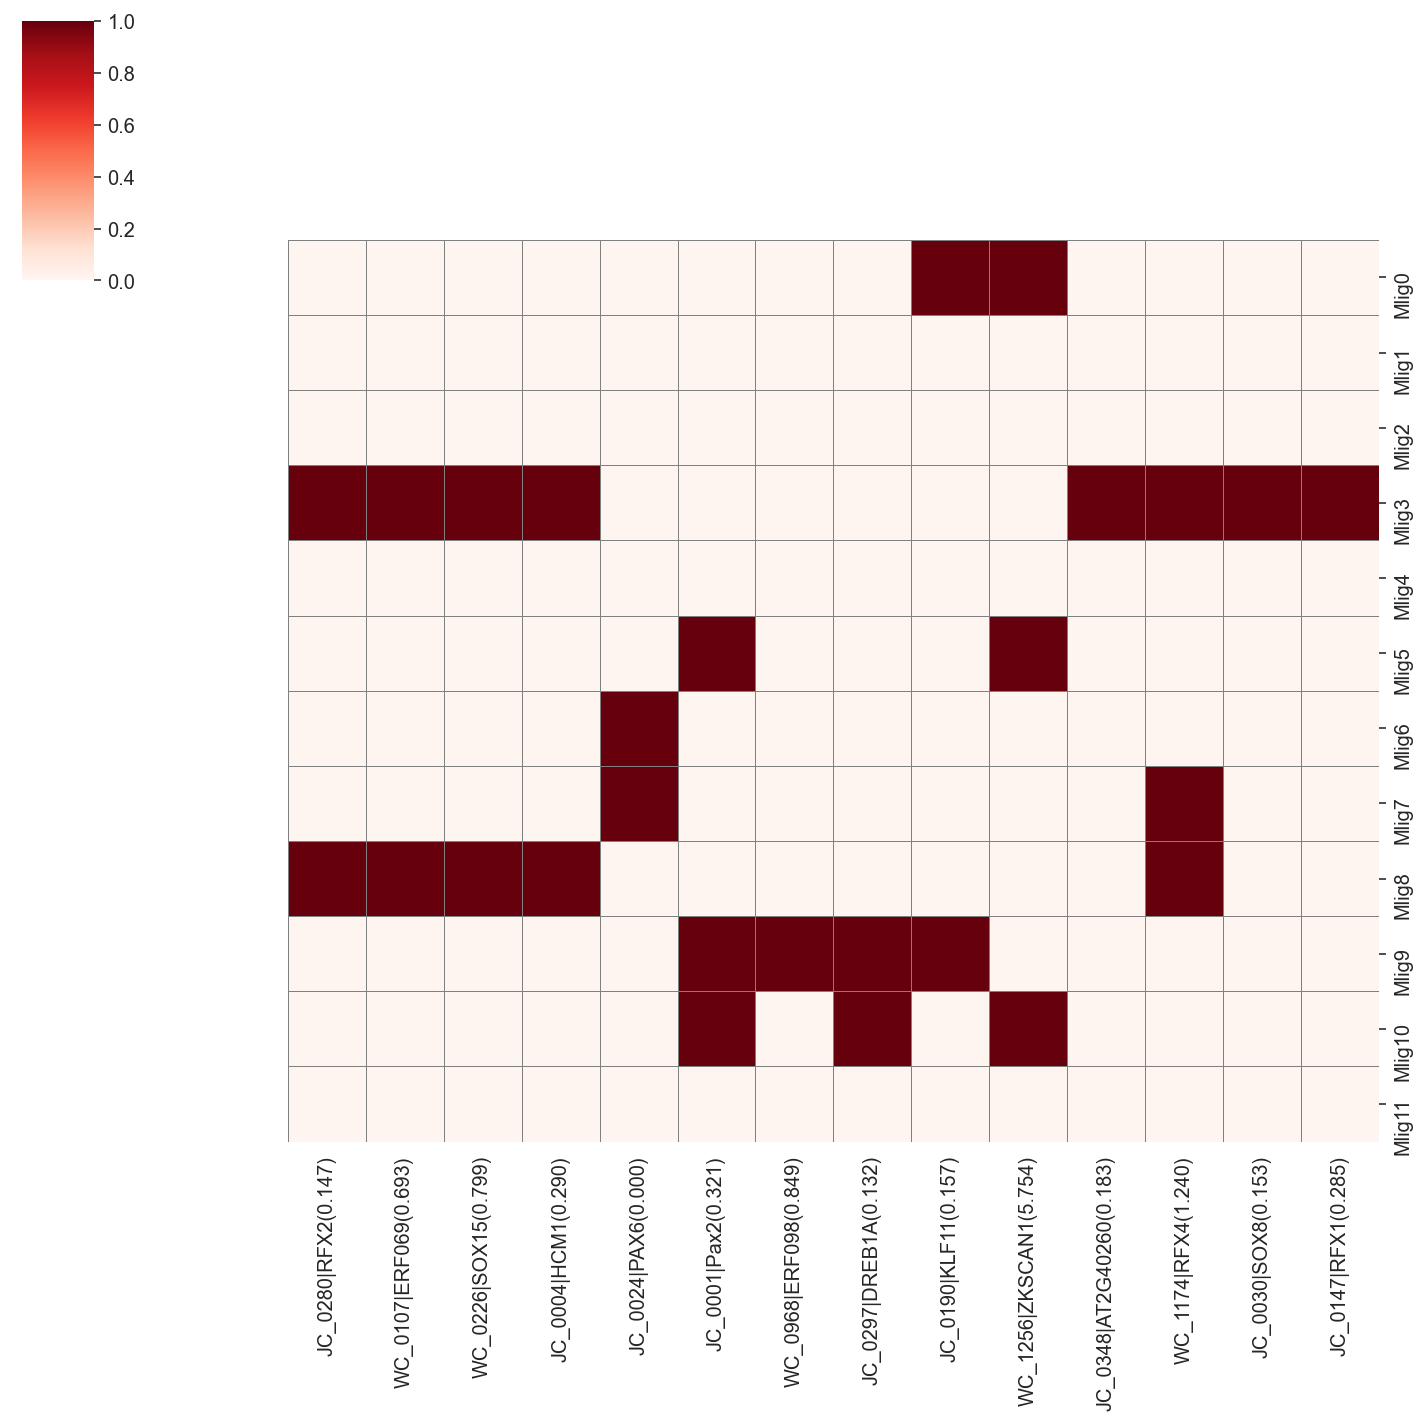

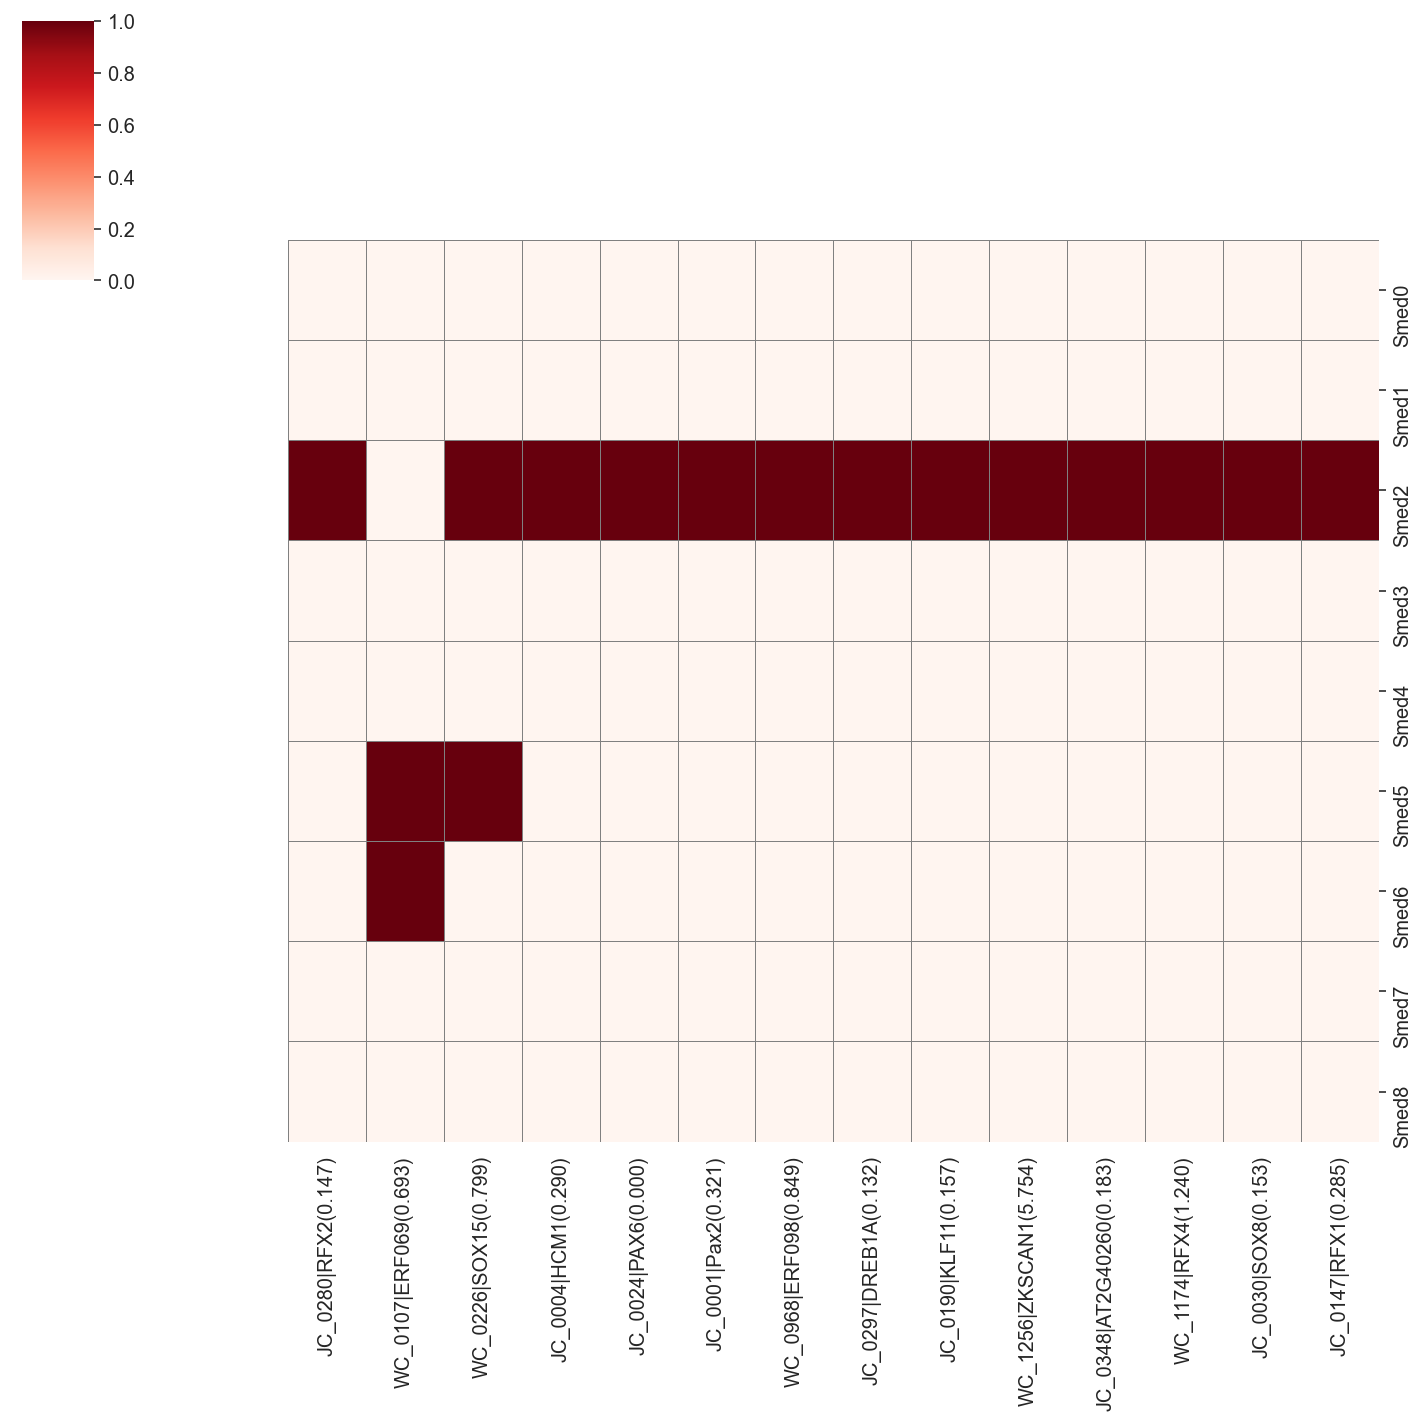

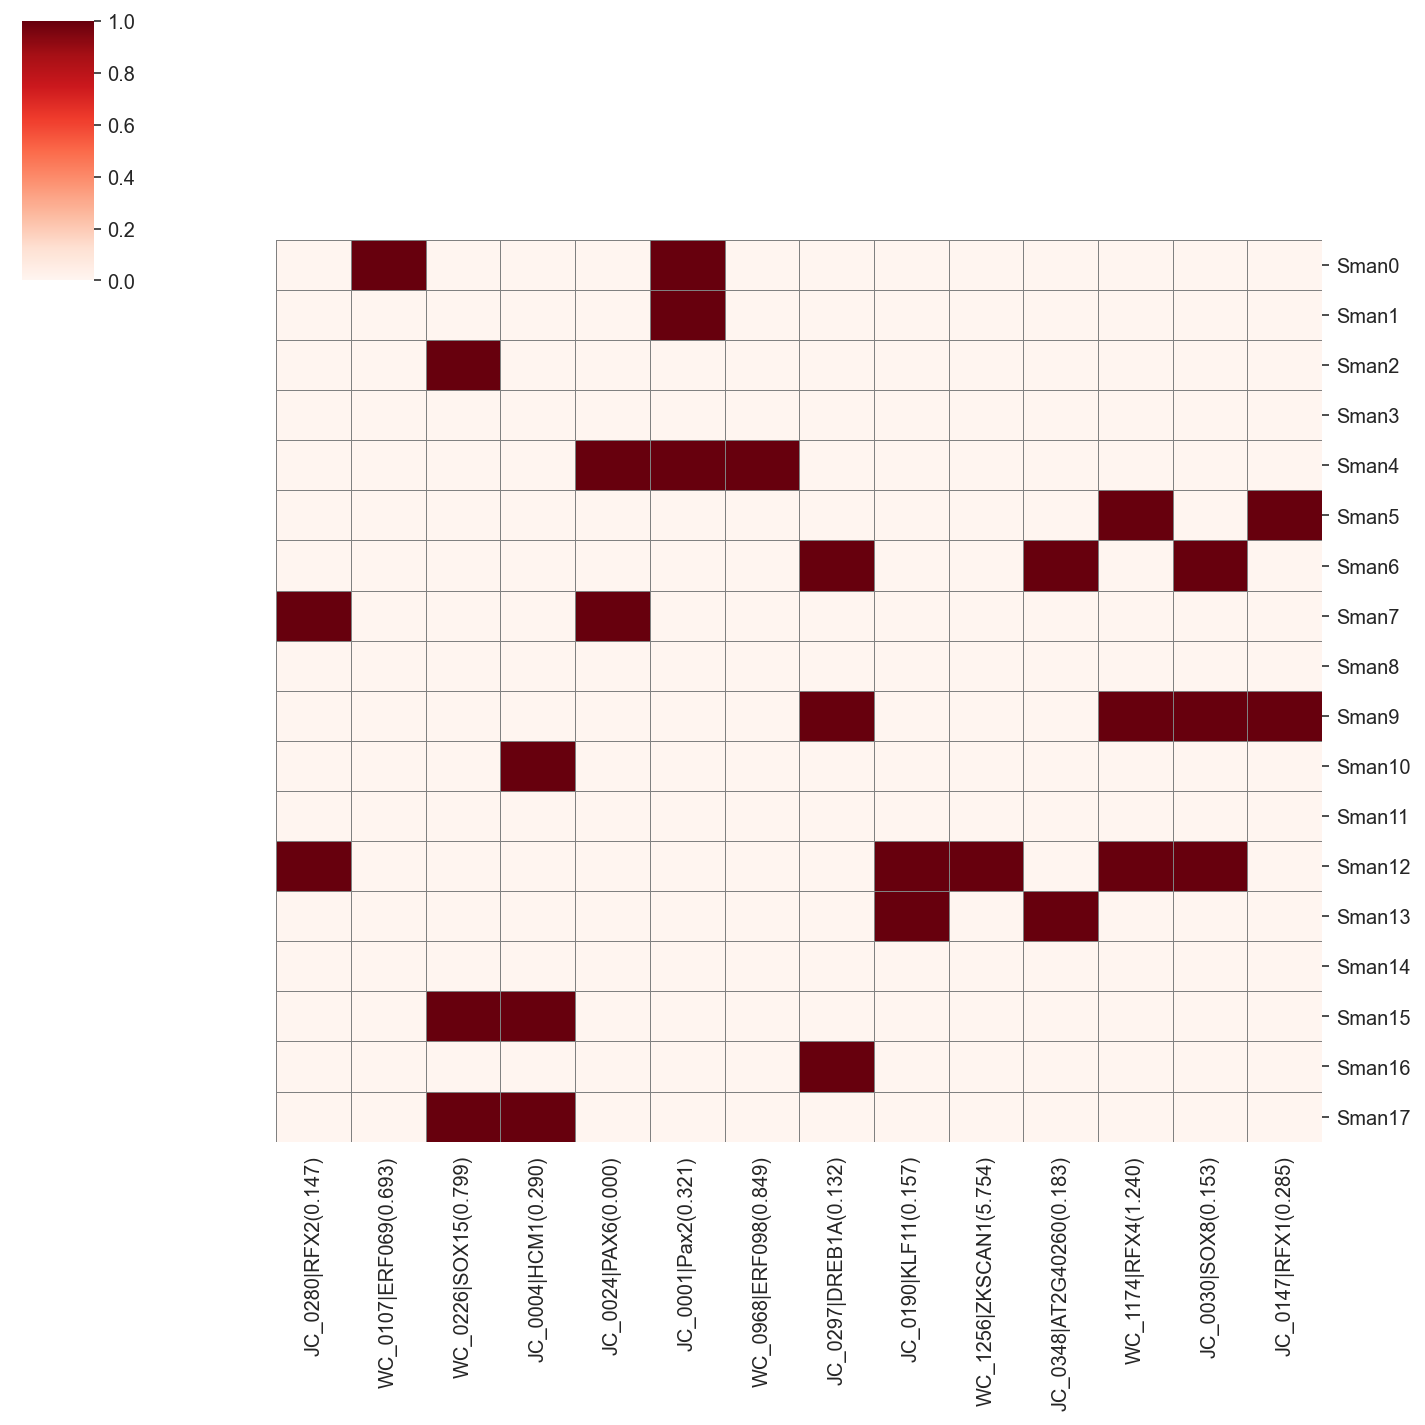

(39, 14)
Index(['JC_0280|RFX2(0.147)', 'WC_0107|ERF069(0.693)', 'WC_0226|SOX15(0.799)',
       'JC_0004|HCM1(0.290)', 'JC_0024|PAX6(0.000)', 'JC_0001|Pax2(0.321)',
       'WC_0968|ERF098(0.849)', 'JC_0297|DREB1A(0.132)',
       'JC_0190|KLF11(0.157)', 'WC_1256|ZKSCAN1(5.754)',
       'JC_0348|AT2G40260(0.183)', 'WC_1174|RFX4(1.240)',
       'JC_0030|SOX8(0.153)', 'JC_0147|RFX1(0.285)'],
      dtype='object')


In [497]:
# Same deal here for the RFX motif
motifTarget = 'JC_0280|RFX2(0.147)'
mM = rModsM[allGood==motifTarget]
mP = rModsP[allGood==motifTarget]
mS = rModsS[allGood==motifTarget]
modMotifs = allGood[(rModsM==mM)|\
                    (rModsP==mP)|\
                    (rModsS==mS)]
subModsM = rModsM[np.isin(allGood,modMotifs)]
binModsM = subModsM == subModsM[modMotifs==motifTarget][0]
subModsP = rModsP[np.isin(allGood,modMotifs)]
binModsP = subModsP == subModsP[modMotifs==motifTarget][0]
subModsS = rModsS[np.isin(allGood,modMotifs)]
binModsS = subModsS == subModsS[modMotifs==motifTarget][0]
bM = binnedM.loc[:,modMotifs]
bP = binnedP.loc[:,modMotifs]
bS = binnedS.loc[:,modMotifs]
spLabels = np.concatenate( (['Mlig']*binnedM.shape[0],
                            ['Smed']*binnedP.shape[0],
                            ['Sman']*binnedS.shape[0]) )

B = pd.DataFrame( data=np.concatenate( (bM,bP,bS), axis=0 ),
                  index=np.concatenate( (binnedM.index,
                                         binnedP.index,
                                         binnedS.index) ),
                  columns=modMotifs )

g = sns.clustermap( B, robust=True, metric='hamming', method='average', cmap='Reds' )
# plt.show()
plt.close()

## Redo the colummns
B = B.iloc[:,g.dendrogram_col.reordered_ind]
modMotifs = modMotifs[g.dendrogram_col.reordered_ind]
subModsM = subModsM[g.dendrogram_col.reordered_ind]
binModsM = binModsM[g.dendrogram_col.reordered_ind]
subModsP = subModsP[g.dendrogram_col.reordered_ind]
binModsP = binModsP[g.dendrogram_col.reordered_ind]
subModsS = subModsS[g.dendrogram_col.reordered_ind]
binModsS = binModsS[g.dendrogram_col.reordered_ind]
binTarg = modMotifs == motifTarget
reCol = np.concatenate( [np.argwhere(binTarg).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&~binModsP&binModsS).flatten()] )
B = B.iloc[:,reCol]
modMotifs = modMotifs[reCol]
subModsM = subModsM[reCol]
binModsM = binModsM[reCol]
subModsP = subModsP[reCol]
binModsP = binModsP[reCol]
subModsS = subModsS[reCol]
binModsS = binModsS[reCol]

sns.clustermap( B.iloc[spLabels=='Mlig'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Smed'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Sman'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()
print( B.shape )

print( B.columns )

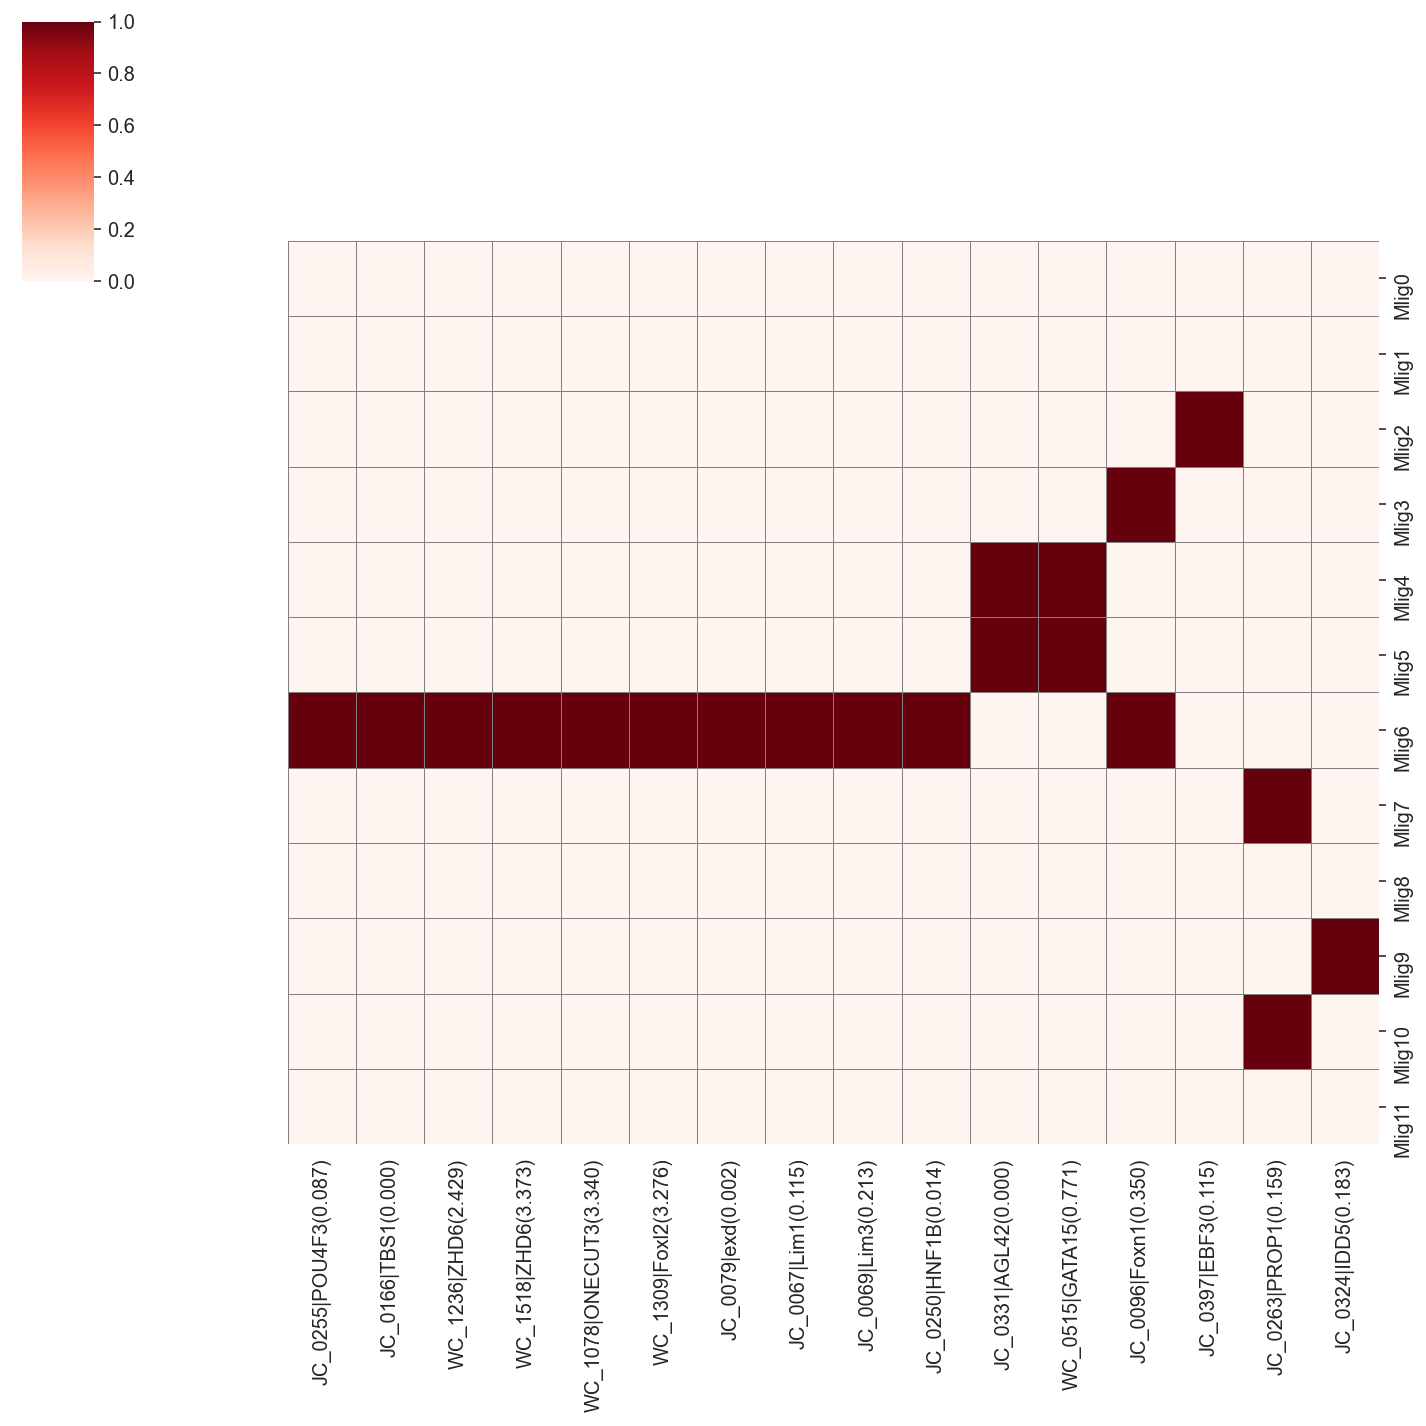

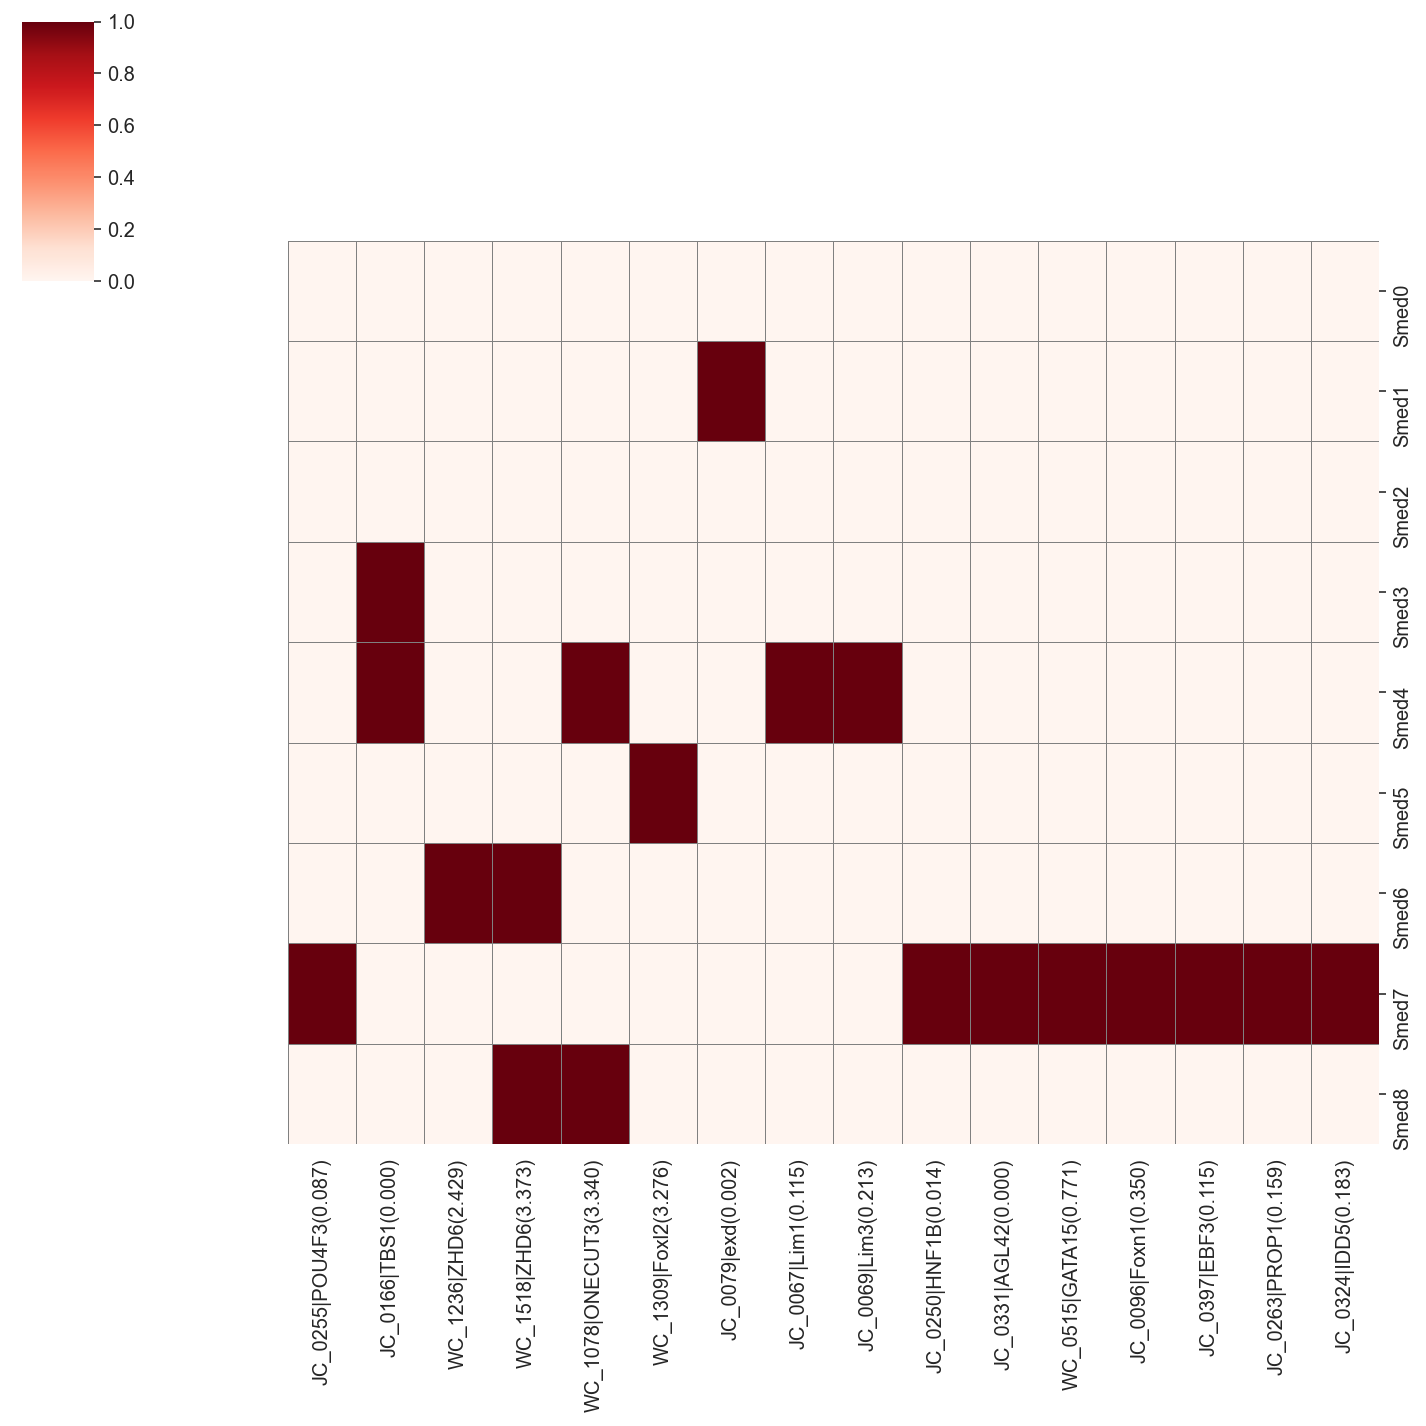

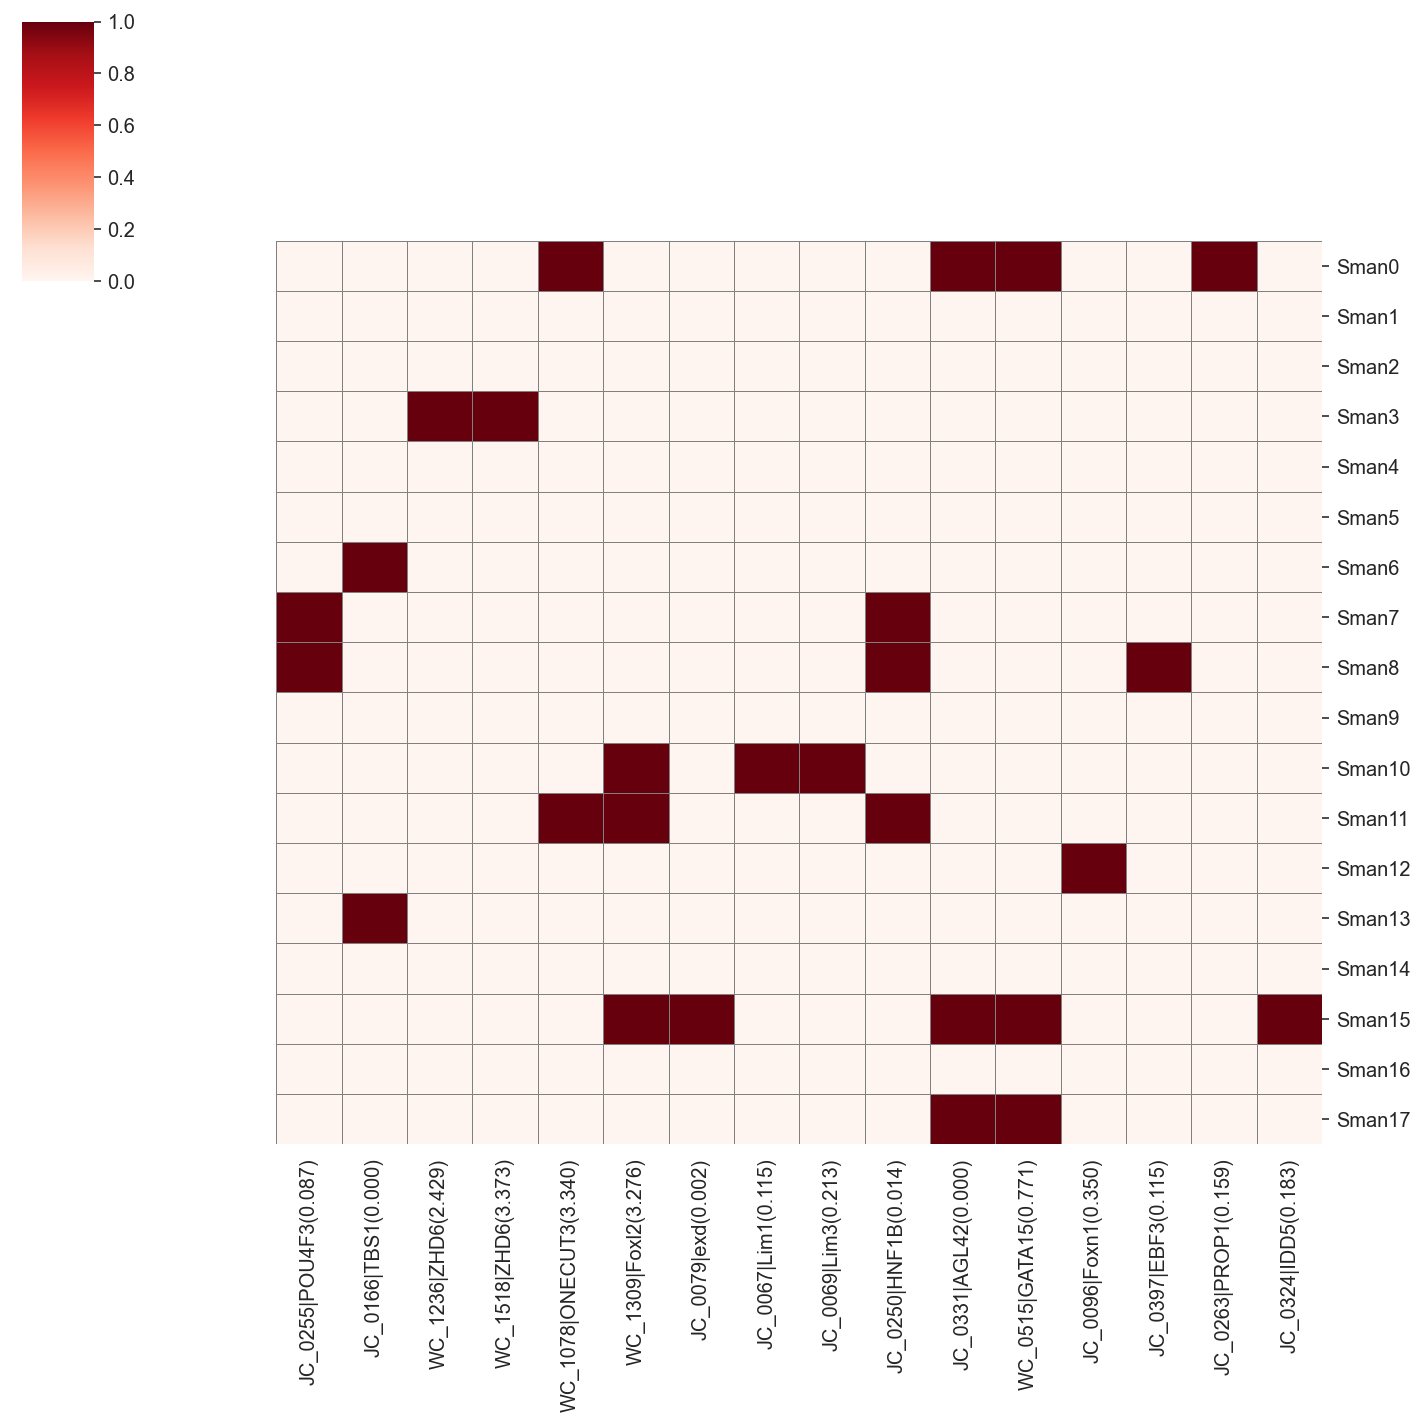

(39, 16)
Index(['JC_0255|POU4F3(0.087)', 'JC_0166|TBS1(0.000)', 'WC_1236|ZHD6(2.429)',
       'WC_1518|ZHD6(3.373)', 'WC_1078|ONECUT3(3.340)', 'WC_1309|Foxl2(3.276)',
       'JC_0079|exd(0.002)', 'JC_0067|Lim1(0.115)', 'JC_0069|Lim3(0.213)',
       'JC_0250|HNF1B(0.014)', 'JC_0331|AGL42(0.000)', 'WC_0515|GATA15(0.771)',
       'JC_0096|Foxn1(0.350)', 'JC_0397|EBF3(0.115)', 'JC_0263|PROP1(0.159)',
       'JC_0324|IDD5(0.183)'],
      dtype='object')


In [514]:
# Same deal here for the POU4 motif
motifTarget = 'JC_0255|POU4F3(0.087)'
mM = rModsM[allGood==motifTarget]
mP = rModsP[allGood==motifTarget]
mS = rModsS[allGood==motifTarget]
modMotifs = allGood[(rModsM==mM)|\
                    (rModsP==mP)|\
                    (rModsS==mS)]
subModsM = rModsM[np.isin(allGood,modMotifs)]
binModsM = subModsM == subModsM[modMotifs==motifTarget][0]
subModsP = rModsP[np.isin(allGood,modMotifs)]
binModsP = subModsP == subModsP[modMotifs==motifTarget][0]
subModsS = rModsS[np.isin(allGood,modMotifs)]
binModsS = subModsS == subModsS[modMotifs==motifTarget][0]
bM = binnedM.loc[:,modMotifs]
bP = binnedP.loc[:,modMotifs]
bS = binnedS.loc[:,modMotifs]
spLabels = np.concatenate( (['Mlig']*binnedM.shape[0],
                            ['Smed']*binnedP.shape[0],
                            ['Sman']*binnedS.shape[0]) )

B = pd.DataFrame( data=np.concatenate( (bM,bP,bS), axis=0 ),
                  index=np.concatenate( (binnedM.index,
                                         binnedP.index,
                                         binnedS.index) ),
                  columns=modMotifs )

g = sns.clustermap( B, robust=True, metric='hamming', method='average', cmap='Reds' )
# plt.show()
plt.close()

## Redo the colummns
B = B.iloc[:,g.dendrogram_col.reordered_ind]
modMotifs = modMotifs[g.dendrogram_col.reordered_ind]
subModsM = subModsM[g.dendrogram_col.reordered_ind]
binModsM = binModsM[g.dendrogram_col.reordered_ind]
subModsP = subModsP[g.dendrogram_col.reordered_ind]
binModsP = binModsP[g.dendrogram_col.reordered_ind]
subModsS = subModsS[g.dendrogram_col.reordered_ind]
binModsS = binModsS[g.dendrogram_col.reordered_ind]
binTarg = modMotifs == motifTarget
reCol = np.concatenate( [np.argwhere(binTarg).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&~binModsP&binModsS).flatten()] )
B = B.iloc[:,reCol]
modMotifs = modMotifs[reCol]
subModsM = subModsM[reCol]
binModsM = binModsM[reCol]
subModsP = subModsP[reCol]
binModsP = binModsP[reCol]
subModsS = subModsS[reCol]
binModsS = binModsS[reCol]

sns.clustermap( B.iloc[spLabels=='Mlig'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Smed'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Sman'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()
print( B.shape )
print( B.columns )

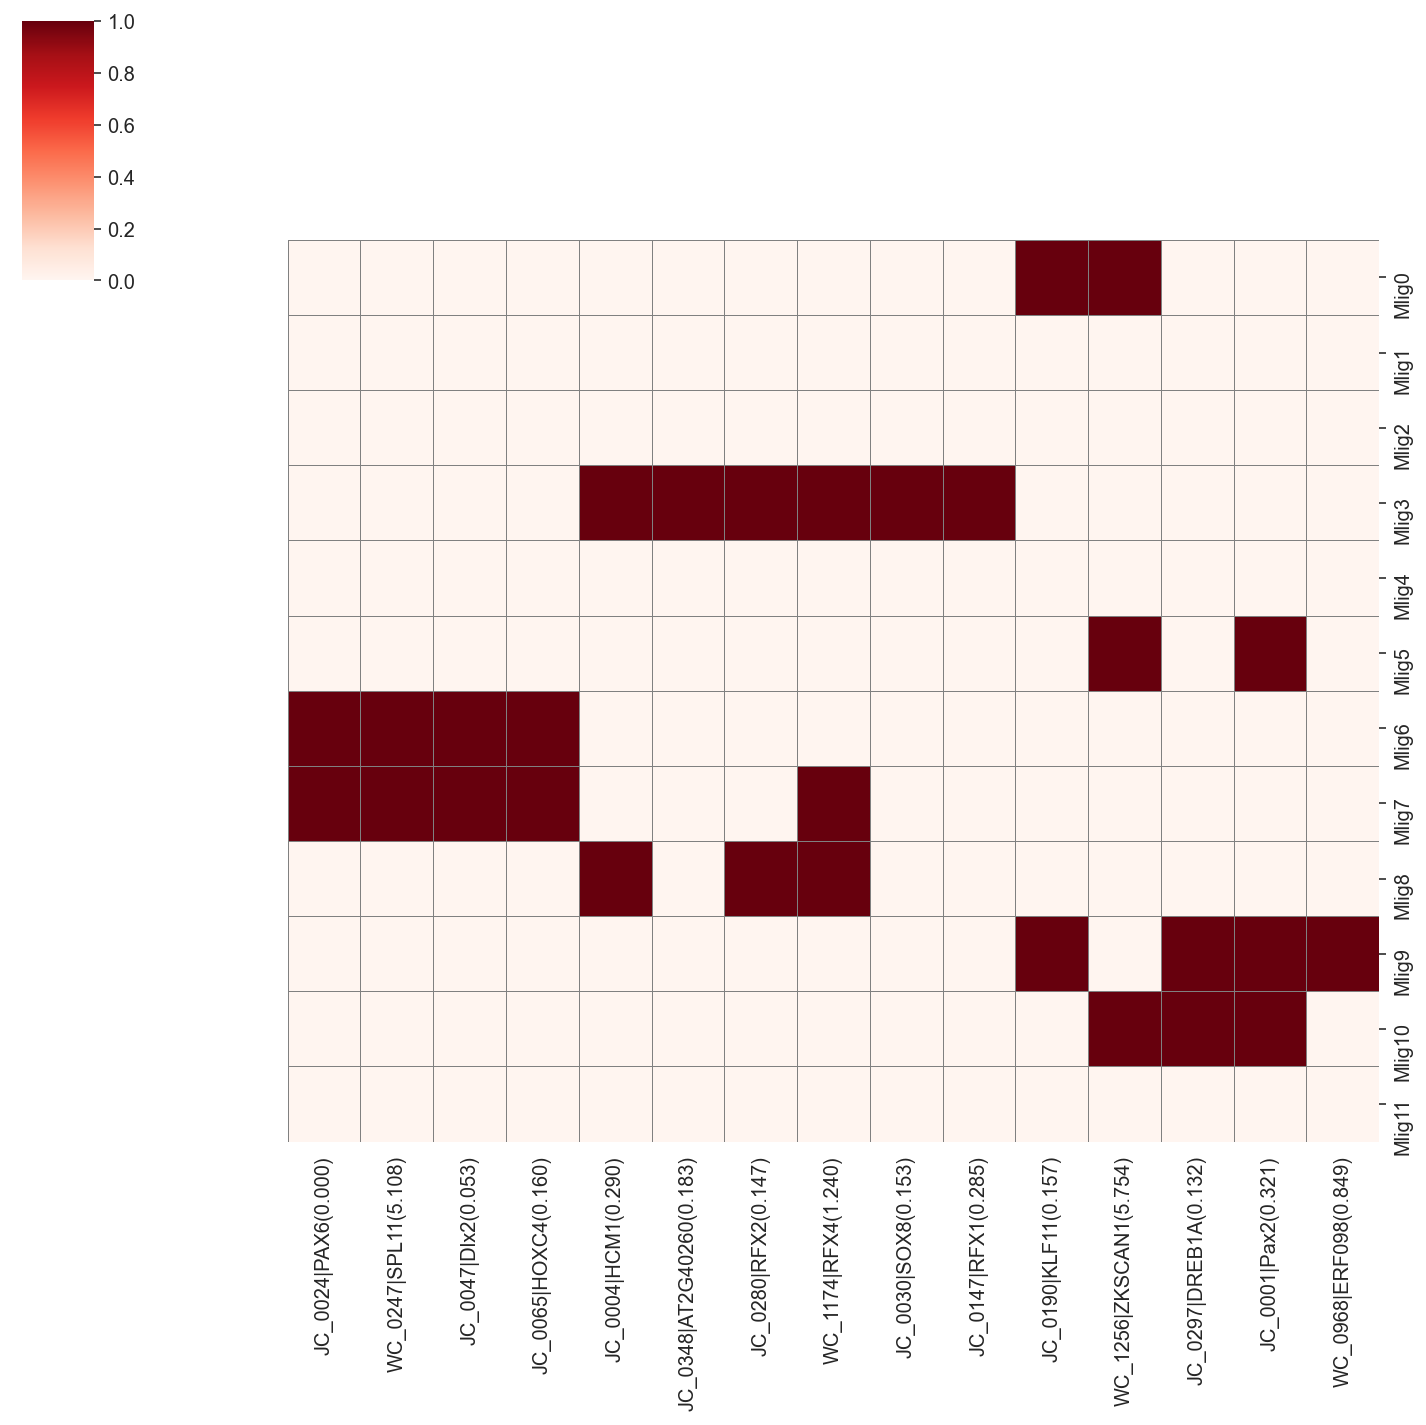

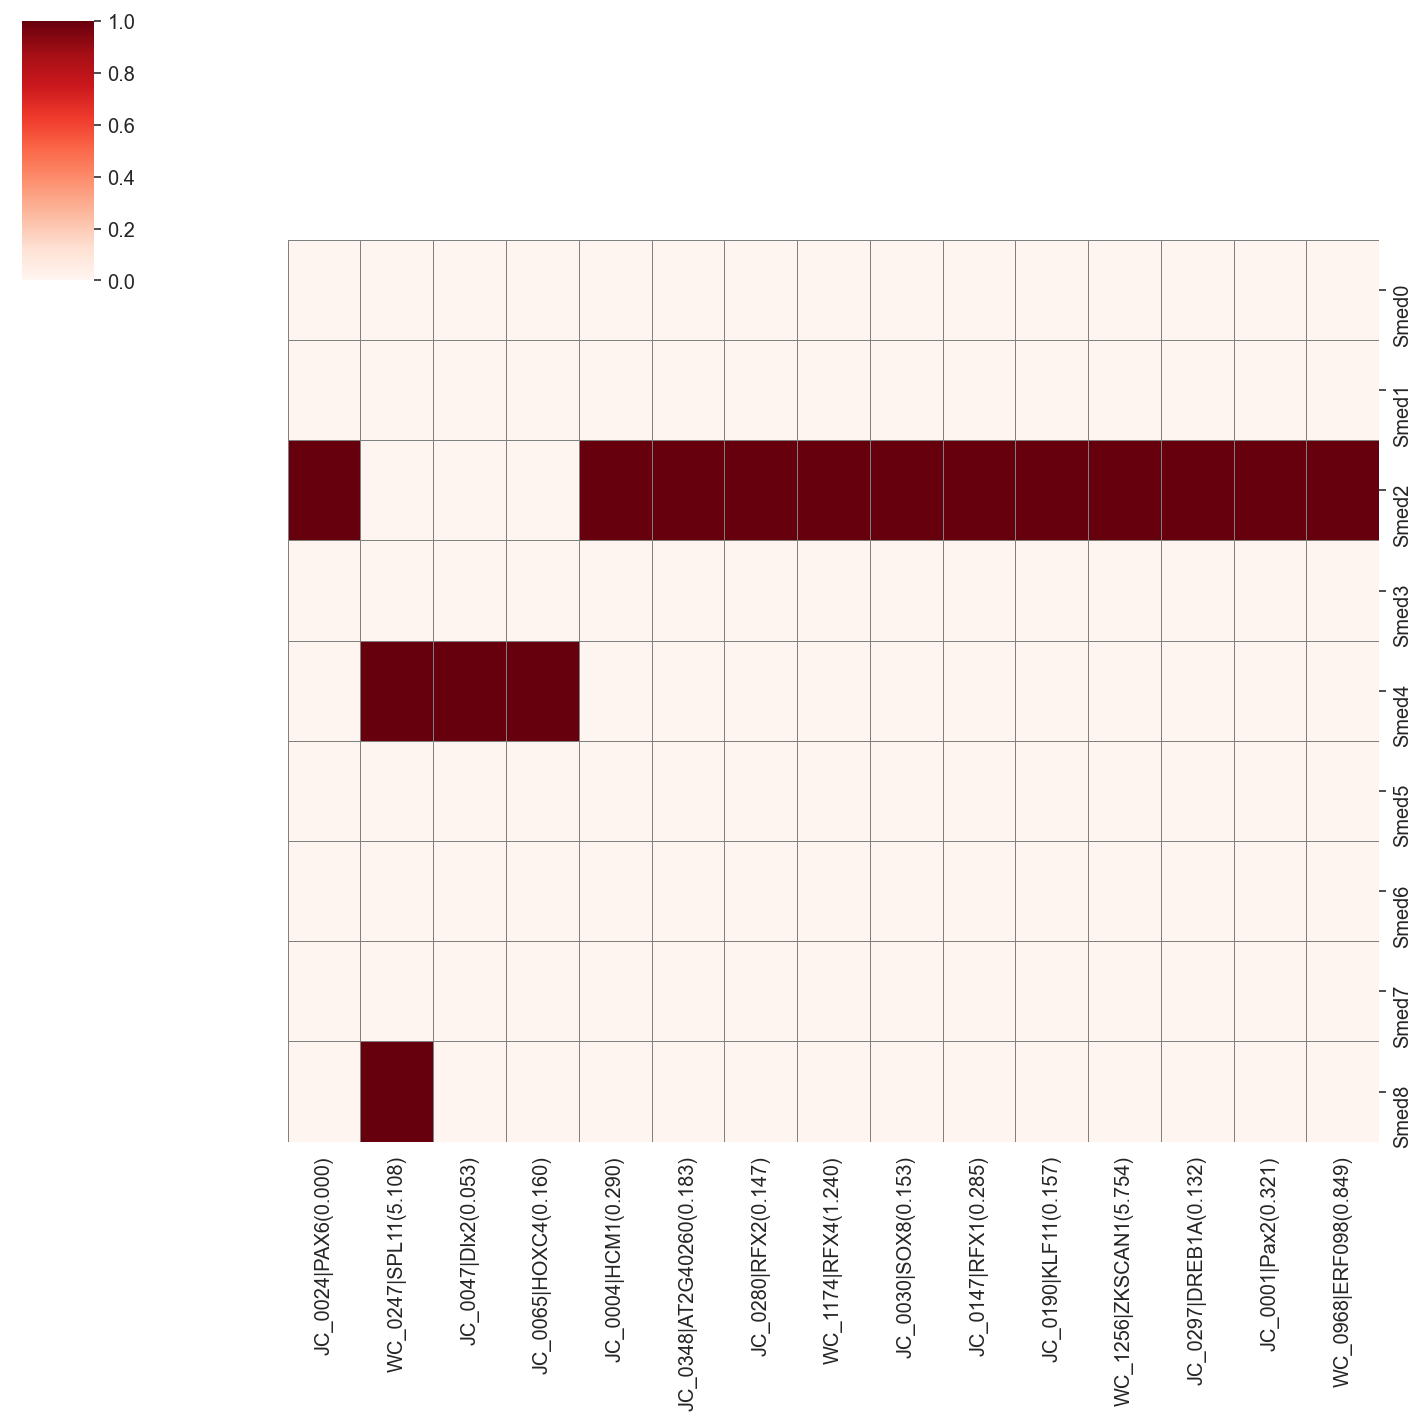

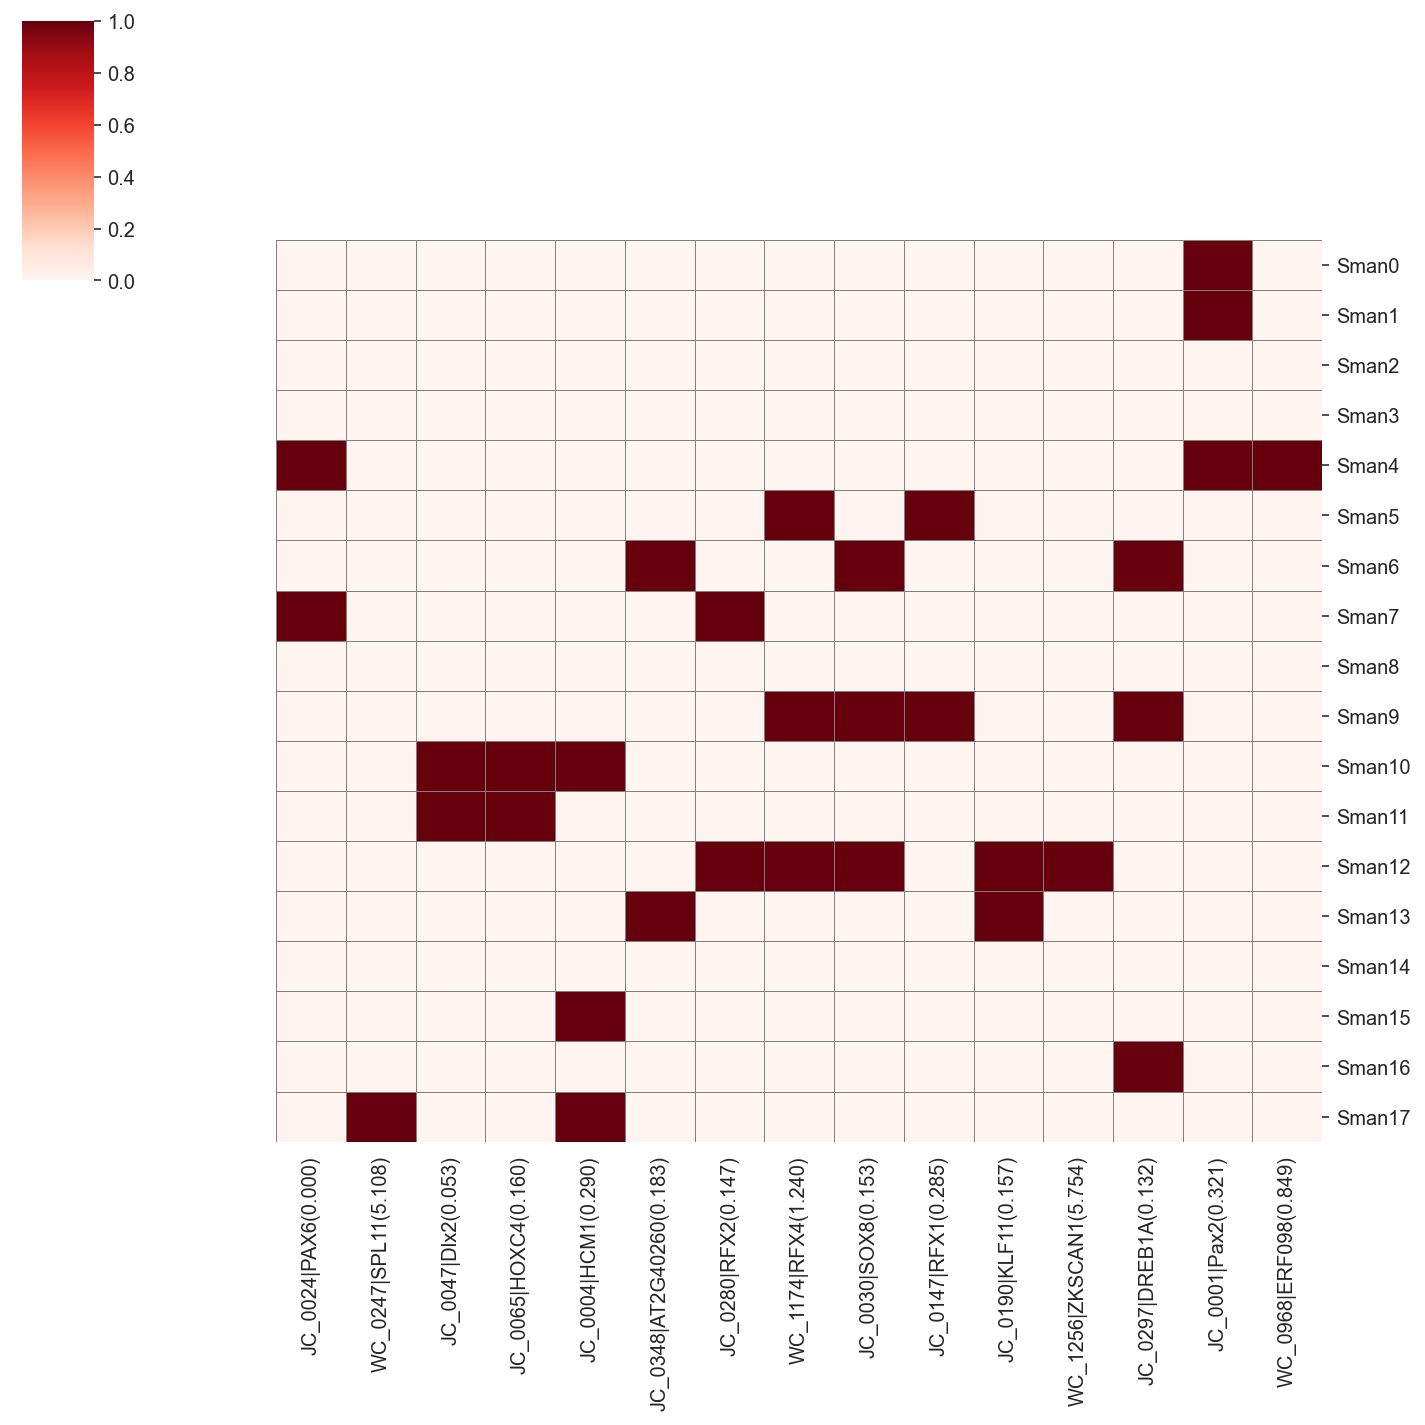

(39, 15)
Index(['JC_0024|PAX6(0.000)', 'WC_0247|SPL11(5.108)', 'JC_0047|Dlx2(0.053)',
       'JC_0065|HOXC4(0.160)', 'JC_0004|HCM1(0.290)',
       'JC_0348|AT2G40260(0.183)', 'JC_0280|RFX2(0.147)',
       'WC_1174|RFX4(1.240)', 'JC_0030|SOX8(0.153)', 'JC_0147|RFX1(0.285)',
       'JC_0190|KLF11(0.157)', 'WC_1256|ZKSCAN1(5.754)',
       'JC_0297|DREB1A(0.132)', 'JC_0001|Pax2(0.321)',
       'WC_0968|ERF098(0.849)'],
      dtype='object')


In [542]:
# Same deal here for the PAX motif
motifTarget = 'JC_0024|PAX6(0.000)'
mM = rModsM[allGood==motifTarget]
mP = rModsP[allGood==motifTarget]
mS = rModsS[allGood==motifTarget]
modMotifs = allGood[(rModsM==mM)|\
                    (rModsP==mP)|\
                    (rModsS==mS)]
subModsM = rModsM[np.isin(allGood,modMotifs)]
binModsM = subModsM == subModsM[modMotifs==motifTarget][0]
subModsP = rModsP[np.isin(allGood,modMotifs)]
binModsP = subModsP == subModsP[modMotifs==motifTarget][0]
subModsS = rModsS[np.isin(allGood,modMotifs)]
binModsS = subModsS == subModsS[modMotifs==motifTarget][0]
bM = binnedM.loc[:,modMotifs]
bP = binnedP.loc[:,modMotifs]
bS = binnedS.loc[:,modMotifs]
spLabels = np.concatenate( (['Mlig']*binnedM.shape[0],
                            ['Smed']*binnedP.shape[0],
                            ['Sman']*binnedS.shape[0]) )

B = pd.DataFrame( data=np.concatenate( (bM,bP,bS), axis=0 ),
                  index=np.concatenate( (binnedM.index,
                                         binnedP.index,
                                         binnedS.index) ),
                  columns=modMotifs )

g = sns.clustermap( B, robust=True, metric='hamming', method='average', cmap='Reds' )
# plt.show()
plt.close()

## Redo the colummns
B = B.iloc[:,g.dendrogram_col.reordered_ind]
modMotifs = modMotifs[g.dendrogram_col.reordered_ind]
subModsM = subModsM[g.dendrogram_col.reordered_ind]
binModsM = binModsM[g.dendrogram_col.reordered_ind]
subModsP = subModsP[g.dendrogram_col.reordered_ind]
binModsP = binModsP[g.dendrogram_col.reordered_ind]
subModsS = subModsS[g.dendrogram_col.reordered_ind]
binModsS = binModsS[g.dendrogram_col.reordered_ind]
binTarg = modMotifs == motifTarget
reCol = np.concatenate( [np.argwhere(binTarg).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&binModsM&~binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&~binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&binModsP&binModsS).flatten(),
                         np.argwhere(~binTarg&~binModsM&~binModsP&binModsS).flatten()] )
B = B.iloc[:,reCol]
modMotifs = modMotifs[reCol]
subModsM = subModsM[reCol]
binModsM = binModsM[reCol]
subModsP = subModsP[reCol]
binModsP = binModsP[reCol]
subModsS = subModsS[reCol]
binModsS = binModsS[reCol]

sns.clustermap( B.iloc[spLabels=='Mlig'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Smed'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()

sns.clustermap( B.iloc[spLabels=='Sman'], robust=True, cmap='Reds',
                row_cluster=False, col_cluster=False, linewidths=0.5, linecolor='grey' )
plt.show()
print( B.shape )
print( B.columns )

Based on the first section, comparing the leiden clusters to our higher level annotations, we know that the following subclusters should largely contain neural progenitors for each species:

- *M. lignano*: Subcluster 9
- *S. mediterranea*: Subcluster 6
- *S. mansoni*: Subclusters 13, 14, 17

In [ ]:
# Pull out motifs with high accessibility in progenitors

npMotifMaskM = binnedM.loc['Mlig9',allGood]
npMotifMaskP = binnedP.loc['Smed6',allGood]
npMotifMaskS = binnedS.loc[['Sman13','Sman14','Sman17'],allGood].any(0)

In [103]:
allGood[(npMotifMaskM&npMotifMaskP&npMotifMaskS)]

Index(['JC_0010|dl(0.000)', 'JC_0117|FOSL1(0.043)', 'JC_0193|BACH1(0.087)',
       'JC_0197|SOX4(0.087)', 'WC_0351|KLF4(2.167)', 'WC_0410|KLF4(3.070)',
       'WC_0472|ZNF148(2.996)', 'WC_0925|Ahr--Arnt(1.103)',
       'WC_1010|FOSL1--JUNB(0.804)', 'WC_1013|JUNB(0.981)',
       'WC_1176|BACH1(4.120)', 'WC_2006|BATF3(4.894)'],
      dtype='object')

In [ ]:
# 12
npSharedNum = (npMotifMaskM&npMotifMaskP&npMotifMaskS).sum()

In [ ]:
# 106
npTotalNum = (npMotifMaskM|npMotifMaskP|npMotifMaskS).sum()

In [65]:
# Similar conservation rate to the high level families
npSharedNum / npTotalNum

0.11320754716981132

Checking out what those accessibility patterns look like more broadly

In [37]:
# Mlig25 is the biggest one with 22 motifs
np.unique( rModsM[npMotifMaskM], return_counts=True )

(array([ 1, 15, 19, 20, 25, 26, 28, 32, 36]),
 array([ 3,  2,  3,  2, 22,  3,  1,  1,  1]))

In [45]:
# Smed11 is the biggest, with 33 motifs
np.unique( rModsP[npMotifMaskP], return_counts=True )

(array([ 3, 10, 11, 12, 13, 20]), array([ 2,  2, 33,  2,  2,  1]))

In [82]:
# Sman20 is the biggest, with 43 motifs
np.unique( rModsS[npMotifMaskS], return_counts=True )

(array([ 1,  8, 11, 13, 16, 17, 19, 20, 25, 28, 29, 31, 32, 40, 46, 50, 54,
        59, 62, 63]),
 array([ 2,  3,  2,  2,  3,  3,  2, 43,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1]))

In [96]:
# JC_0010 maps most strongly to Rel homology 
# domain TF binding sites
allGood[((rModsM==25)&(rModsP==11)&(rModsS==20))]

Index(['JC_0010|dl(0.000)', 'WC_0351|KLF4(2.167)', 'WC_2006|BATF3(4.894)'], dtype='object')

In [ ]:
# Number of motifs in the major module that
# that are shared: 3
primarySharedNum = ((rModsM==25)&(rModsP==11)&(rModsS==20)).sum()

In [ ]:
# Number of motifs in the major module
# for at least one species: 78
primaryTotalNum = ((rModsM==25)|(rModsP==11)|(rModsS==20)).sum()

In [98]:
# Conservation of this exact accessibility pattern
# is much lower than just being high in progenitors
primarySharedNum / primaryTotalNum

0.038461538461538464